In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from esmpy.datasets.base import generate_spim
from esmpy.estimators import SmoothNMF
from esmpy.measures import find_min_angle, find_min_MSE, ordered_mse, ordered_mae, ordered_r2, ordered_kl
import quadprog
import numpy
from scipy import signal
from scipy.optimize import linprog


In [2]:
print(YVol.shape)

NameError: name 'YVol' is not defined

In [10]:
C = 15
L = 200
P = 100**2
seed = 0

n_poisson = 300 # Average poisson number per pixel (this number will be splitted on the L dimension)


In [4]:

def plot_results(Ddot, D, Hdotflat, Hflat, n_pixel_side, Hs, Ws, G, losses):


    fontsize = 30
    scale = 15
    aspect_ratio = 1.4
    marker_list = ["-o","-s","->","-<","-^","-v","-d"]
    mark_space = 20
    # cmap = plt.cm.hot_r    
    cmap = plt.cm.gray_r
    vmax = 1
    vmin = 0
    K = Hflat.shape[0]
    L = D.shape[0]

    angles, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)

  

    mse = ordered_mse(Hdotflat, Hflat, true_inds)
    mae = ordered_mae(Hdotflat, Hflat, true_inds)
    r2 = ordered_r2(Hdotflat, Hflat, true_inds)
    kl = ordered_kl(Hdotflat, Hflat, true_inds)

    print(r2, kl, mse, mae)
    print(";....................................")

    

    fig = plt.figure(figsize = (scale/K * 3 * aspect_ratio,scale))
    gs = fig.add_gridspec(3,3)
    plt.subplots_adjust(bottom=0.15)
    ax_slide = plt.axes([0.15, 0.1, 0.65, 0.03])
  
    x = np.linspace(0,1, num = L)
    rows = ["True maps","Reconstructed maps","Spectra"]

    for i in range(K): 
        j= true_inds.index(i)
         
        print(i,j)

        ax1 = fig.add_subplot(gs[0, i])
        ax2 = fig.add_subplot(gs[1, i])
        ax3 = fig.add_subplot(gs[2, i])

        if i == 0:                
            ax1.set_ylabel('True maps', rotation=90, fontsize=fontsize)
            ax2.set_ylabel('Reconstructed maps', rotation=90, fontsize=fontsize)
            ax3.set_ylabel('Spectra', rotation=90, fontsize=fontsize)

        
       

        ax2.imshow((Hflat[j]).reshape(n_pixel_side,n_pixel_side),vmin = vmin, vmax = vmax , cmap=cmap)
        ax2.set_title("R2: {:.2f}".format(r2[j]),fontsize = fontsize-2)
        # axes[i,1].set_ylim(0.0,1.0)
        ax2.tick_params(axis = "both",labelleft = False, labelbottom = False,left = False, bottom = False)

        im = ax1.imshow(Hdotflat[i].reshape(n_pixel_side,n_pixel_side),vmin = vmin, vmax = vmax, cmap=cmap)
        ax1.set_title("Phase {}".format(i),fontsize = fontsize)
        ax1.tick_params(axis = "both",labelleft = False, labelbottom = False,left = False, bottom = False)

        ax3.plot(x,Ddot.T[i,:],'bo',label='truth',linewidth=4)
        ax3.plot(x,D[:,j],'r-',label='reconstructed',markersize=3.5)
        ax3.set_title("{:.2f} deg".format(angles[j]),fontsize = fontsize-2)
        ax3.set_xlim(0,1)
        ax3.legend()


    fig.subplots_adjust(right=0.84)
    # put colorbar at desire position
    cbar_ax = fig.add_axes([0.85, 0.5, 0.01, 0.3])
    fig.colorbar(im,cax=cbar_ax)
    fig.savefig('../results/figure.png')


from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

def plot_results_report(Ddot, D, Hdotflat, Hflat, n_pixel_side, Hs, Ws, G, losses):


    fontsize = 15
    scale = 15
    aspect_ratio = 1.4
    marker_list = ["-o","-s","->","-<","-^","-v","-d"]
    mark_space = 20
    # cmap = plt.cm.hot_r    
    cmap = plt.cm.gray_r
    vmax = 1
    vmin = 0
    K = Hflat.shape[0]
    L = D.shape[0]

    angles, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)

  

    mse = ordered_mse(Hdotflat, Hflat, true_inds)
    mae = ordered_mae(Hdotflat, Hflat, true_inds)
    r2 = ordered_r2(Hdotflat, Hflat, true_inds)
    kl = ordered_kl(Hdotflat, Hflat, true_inds)

    print(r2, kl, mse, mae)
    print(";....................................")

    max_intensity = max(np.max(D), np.max(Ddot))

    fig = plt.figure(figsize = (21,11))
    # gs = fig.add_gridspec(3,3)
    gs = fig.add_gridspec(3, 4, width_ratios=[1,1,.2,3], height_ratios=[1,1,1]) 

    # ax_slide = plt.axes([0.15, 0.1, 0.65, 0.03])
  
    x = np.linspace(0,1, num = L)
    rows = ["True maps","Reconstructed maps","Spectra"]

    for i in range(K): 
        j= true_inds.index(i)
         
        print(i,j)

        ax1 = fig.add_subplot(gs[i, 0])
        ax2 = fig.add_subplot(gs[i, 1])
        ax3 = fig.add_subplot(gs[i, 3])

        if i == 0:                
            ax1.set_title('True maps', fontsize=fontsize)
            ax2.set_title('Reconstructed maps',  fontsize=fontsize)
            ax3.set_title('Spectra (true vs reconstructed)',  fontsize=fontsize)


        if i==K-1:
            ax3.set_xlabel('Energy [keV]', fontsize=fontsize)
        
        props = dict(boxstyle='round', facecolor='white', alpha=0.65)


        ax2.imshow((Hflat[j]).reshape(n_pixel_side,n_pixel_side),vmin = vmin, vmax = vmax , cmap=cmap)
        # ax2.text(3.5,6, "R2: {:.2f}".format(r2[j]),
        # bbox={'facecolor': 'white', 'alpha': 0.65, 'pad': 10})


        # ax2.set_title("R2: {:.2f}".format(r2[j]),fontsize = fontsize-2)
        # axes[i,1].set_ylim(0.0,1.0)
        ax2.text(0.05, 0.95, "R2: {:.2f}".format(r2[j]), transform=ax2.transAxes, fontsize=fontsize,
        verticalalignment='top', bbox=props)

        im = ax1.imshow(Hdotflat[i].reshape(n_pixel_side,n_pixel_side),vmin = vmin, vmax = vmax, cmap=cmap)
        # ax1.set_title("Phase {}".format(i),fontsize = fontsize)
        ax1.tick_params(axis = "both",labelleft = False, labelbottom = False,left = False, bottom = False)
        ax2.tick_params(axis = "both",labelleft = False, labelbottom = False,left = False, bottom = False)

        ax3.plot(x,D[:,j],'bo',label='reconstructed',linewidth=4)
        ax3.plot(x,Ddot.T[i,:],'r-',label='truth',markersize=3.5)
        # ax3.text(.05,.95, "Angle error: {:.2f} deg".format(angles[j]),
        # bbox={'facecolor': 'white', 'alpha': 0.65, 'pad': 10})



        ax3.text(0.02, 0.95, "Angle error: {:.2f} deg".format(angles[j]), transform=ax3.transAxes, fontsize=fontsize,
        verticalalignment='top', bbox=props)

  

        # ax3.set_title("{:.2f} deg".format(angles[j]),fontsize = fontsize-2)
        ax3.set_ylabel("Intensity [-]", fontsize=fontsize)
        # ax3.set_xlim(0,1) 
        ax3.set_ylim(0,max_intensity)

        if i == 0:
            ax3.legend()


    plt.subplots_adjust(wspace=0.0, hspace=0.08)
    # fig.tight_layout()
    plt.subplots_adjust(bottom=0.05)


    # # fig.subplots_adjust(top=0.99)
    # # put colorbar at desire position
    cbar_ax = fig.add_axes([0.15, 0.0, 0.3, 0.01])
    fig.colorbar(im,cax=cbar_ax, orientation='horizontal')
    # fig.savefig('../results/figure.png')




/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


exits because max_iteration was reached
Stopped after 1 iterations in 0.0 minutes and 0.0 seconds.
(1980, 4489) (1980, 4489)
[[1.00000000e-04 1.00000000e-04 1.00000000e-04 ... 3.91368547e+00
  6.55127896e+03 6.86581334e+03]
 [4.48943001e-02 3.59852548e-02 5.14945665e-03 ... 1.00000000e-04
  1.00000000e-04 1.00000000e-04]
 [9.54855975e+03 9.68036704e+03 9.95440320e+03 ... 1.56954422e+00
  1.04919479e+00 1.06228485e+00]]
[-0.7876922714430634, 0.4975658293164099, -0.5110853168264291] 9.005427458023664 [0.03135697886284899, 0.006375304418363554, 0.009881726534900536] [0.1306387169504545, 0.04161081950128926, 0.05014679003079088]
;....................................
0 1
1 2
2 0


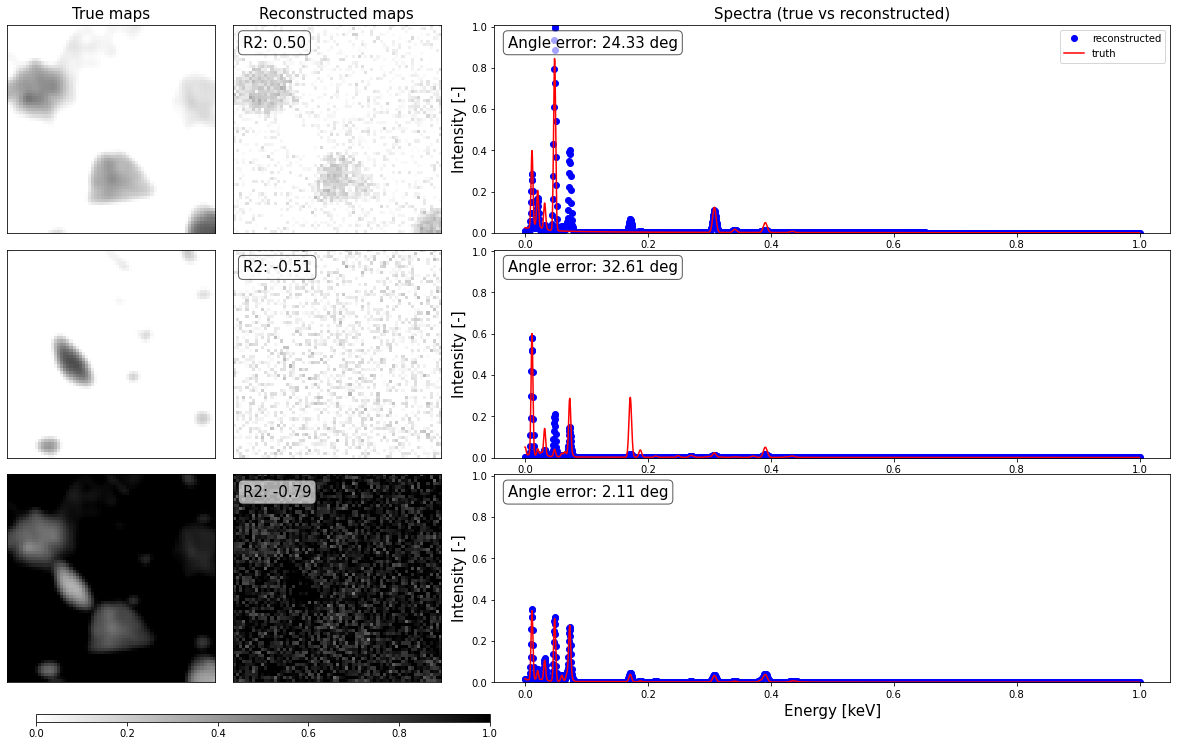

In [ ]:
G = spim.build_G("bremsstrahlung", norm = True)
# G = kmeans.cluster_centers_.T
Y = spim.X

pixels_side = 201
num_iterations = 1
# Baseline
downsampling_factors = [3]
Hflat =None
W = None
import time
from scipy import ndimage

angles_hist = []
kl_hist = []
r2_hist = []

alphas = np.arange(0,0.1,0.1)
# YSmoothedMedian = ndimage.median_filter(YVol, size=(1,3,3))
for idx in range(len(alphas)):
    alpha = alphas[idx]
    YSmoothedMapsMix =  YVol*(1-alpha)+ YSmoothedMaps*(alpha)
    Ximg = YSmoothedMapsMix.reshape((-1, pixels_side,pixels_side))+0.000000000001
    
    # Ximg = YMix.reshape((-1, pixels_side,pixels_side))+0.000000000001

    for i in range(len(downsampling_factors)):

        start_time = time.time()
        n = downsampling_factors[i]
        X = downsample(Ximg,n)

        Xflat = X.reshape((X.shape[0], -1))
        est = SmoothNMF( n_components = 3,tol=0.0001, max_iter = num_iterations, G = G, lambda_L=0, mu=0, force_simplex=False)
        D , Hs, Ws, G, losses = est.fit_transform(Xflat, update_W=True)
        Hflat = est.H_
        W = est.W_
        Wdot = spim.phases


        angle, true_inds = find_min_angle(spim.phases.T, D.T, unique=True, get_ind=True)
        angles_hist.append(sum(angle)/len(angle))


        Hflatdot_down = downsample_flat(spim.maps,n, pixels_side)

        Yest = D@Hflat
        Ydot = spim.phases@Hflatdot_down

        print(Yest.shape, Ydot.shape)


        r2 = ordered_r2(Hflatdot_down, Hflat, true_inds)
        r2_hist.append(sum(r2)/len(r2))




        plot_results_report(spim.phases, D, Hflatdot_down, Hflat, pixels_side//n, Hs, Ws, G, losses)


In [5]:
from curses.panel import bottom_panel
import hyperspy.api as hs
from esmpy.estimators import SmoothNMF
import esmpy.datasets as ds
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from esmpy.measures import find_min_angle, find_min_MSE, ordered_mse, ordered_mae, ordered_r2, ordered_kl

spim176= hs.load("../generated_datasets/71GPa_synthetic_N176.hspy")
spim17 = hs.load("../generated_datasets/71GPa_synthetic_N17.hspy")
# spim3 = hs.load("../generated_datasets/71GPa_synthetic_N18.hspy")
# spim4 = hs.load("../generated_datasets/71GPa_synthetic_N178.hspy")
spim1176 = hs.load("../generated_datasets/71GPa_synthetic_N1176.hspy")
spim11176 = hs.load("../generated_datasets/71GPa_synthetic_N11176.hspy")

spim = spim176






In [18]:
print(spim.X.shape)

(1980, 40401)


In [6]:
def runNMF(spim,lambda_, mu_, binning_factors, num_iterations, median_filter_size, alpha, usePinv):
    Ddot = spim.phases
    Hflatdot = spim.maps
    Ydot = Ddot@Hflatdot

    Y = spim.X
    G = spim.build_G("bremsstrahlung", norm = True)


    downsampling_factors = binning_factors
    Hflat =None
    W = None

    if alpha >= 0:
        YSmoothedMapsMix =  YVol*(1-alpha)+ YSmoothedMaps*(alpha)
        Ximg = YSmoothedMapsMix.reshape((-1, pixels_side,pixels_side))+0.000000000001
    else:
        Ximg = Y.reshape((-1, pixels_side,pixels_side))

    for i in range(len(downsampling_factors)):

        start_time = time.time()
        n = downsampling_factors[i]
        X = downsample(Ximg,n)
        if (median_filter_size > 0):
            X = ndimage.median_filter(X, size=(1,median_filter_size,median_filter_size))

        Xflat = X.reshape((X.shape[0], -1))
        Hflatdot_down= downsample_flat(Hflatdot,n, pixels_side)

        if (i > 0):
            factor = downsampling_factors[i-1]//downsampling_factors[i]
            H = Hflat.reshape((-1, pixels_side//n//factor, pixels_side//n//factor))
            H = H.repeat(factor, axis = 1).repeat(factor, axis = 2)
            Hflat = H.reshape((-1, pixels_side*pixels_side//n//n)) +0.01
            W =  W 
        
        est = SmoothNMF( n_components = 3,tol=0.0001, max_iter = num_iterations, G = G, Z=Z, lambda_L= lambda_, mu=mu_, force_simplex=False)
        if i > 0:
            D , Hs, Ws, _, losses = est.fit_transform(Xflat, H=Hflat, W=W, update_W=False)
        else:
            D , Hs, Ws, _, losses = est.fit_transform(Xflat, update_W=True)

        Hflat = est.H_
        W = est.W_

    if usePinv:
        print(W.shape, Hflat.shape)
        Hflat = np.linalg.pinv(D)@Ximg.reshape((-1, pixels_side*pixels_side))
        n = 1
        
    Yest = D@Hflat
    Hflatdot_down= downsample_flat(Hflatdot,n, pixels_side)


    print(Ydot.shape, Yest.shape, Hflatdot_down.shape, Hflat.shape)
    # Calculate Errors
    angle, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
    nll = np.sum(-Ydot.flatten()*np.log(Yest.flatten()+0.000000000001)+ Yest.flatten())
    r2 = ordered_r2(Hflatdot_down, Hflat, true_inds)

    plot_results_report(Ddot, D, Hflatdot_down, Hflat, pixels_side//n, Hs, Ws, G, losses)
    return sum(angle)/len(angle), nll, sum(r2)/len(r2), time.time()-start_time



In [79]:
YVol = spim.X.reshape((-1, pixels_side,pixels_side))
YSmoothedMaps = np.zeros((C,P_side,P_side))
for c in range(C):
    # print(Y[c,:,:].shape,, res.shape)
    YSmoothedMaps[c,:,:] = signal.convolve2d(YVol[c,:,:], filter_maps, boundary='symm', mode='same')

    
params = [
    (spim176, 0,0, [1], 10, -1, -1, False),
    (spim176, 10,10, [1], 10, -1, -1, False),
    (spim176, 0,0, [3,1], 10, -1, -1, False),
    (spim176, 0,0, [3], 10, -1, -1, True),
    (spim176, 0,0, [1], 10, -1, 0.9, False),
    (spim176, 0,0, [1], 10, 3, -1, False),
]

results  = []
for i in range(len(params)):
    a = runNMF(params[i][0], params[i][1], params[i][2], params[i][3], params[i][4], params[i][5], params[i][6], params[i][7])
    print(a)
    results.append(a)

NameError: name 'pixels_side' is not defined

In [11]:
# Experiment multismooth
# G = kmeans.cluster_centers_.T

pixels_side = 201
num_iterations = 1
# Baseline

import time
from scipy import ndimage

angles_hist = []
nnl_hist = []
r2_hist = []
time_hist = []

Ddot = spim.phases
Hflatdot = spim.maps
Hflatdot_down = downsample_flat(Hflatdot,1, pixels_side)
Ydot = Ddot@Hflatdot

Y = spim.X
G = spim.build_G("bremsstrahlung", norm = True)


# 1. Baseline
downsampling_factors = [1]
Hflat =None
W = None
Ximg = Y.reshape((-1, pixels_side,pixels_side))

for i in range(len(downsampling_factors)):

    start_time = time.time()
    n = downsampling_factors[i]
    X = downsample(Ximg,n)

    Xflat = X.reshape((X.shape[0], -1))
    est = SmoothNMF( n_components = 3,tol=0.0001, max_iter = num_iterations, G = G, lambda_L=0, mu=0, force_simplex=False)
    D , Hs, Ws, _, losses = est.fit_transform(Xflat, update_W=True)
    Hflat = est.H_
    HVol = Hflat.reshape((-1, pixels_side,pixels_side))
    HflatMed = ndimage.median_filter(HVol, size=(1,3,3))
    Hflat = HflatMed.reshape((-1, pixels_side*pixels_side))
    
    W = est.W_

Yest = D@Hflat
# Calculate Errors
angle, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
nll = np.sum(-Ydot.flatten()*np.log(Yest.flatten()+0.000000000001)+ Yest.flatten())
r2 = ordered_r2(Hflatdot_down, Hflat, true_inds)



plot_results_report(Ddot, D, Hflatdot_down, Hflat, pixels_side//n, Hs, Ws, G, losses)


Y = Yest
# 1. Baseline
downsampling_factors = [1]
Hflat =None
W = None
Ximg = Y.reshape((-1, pixels_side,pixels_side))

for i in range(len(downsampling_factors)):

    start_time = time.time()
    n = downsampling_factors[i]
    X = downsample(Ximg,n)

    Xflat = X.reshape((X.shape[0], -1))
    est = SmoothNMF( n_components = 3,tol=0.0001, max_iter = num_iterations, G = G, lambda_L=0, mu=0, force_simplex=False)
    D , Hs, Ws, _, losses = est.fit_transform(Xflat, update_W=True)
    Hflat = est.H_
    
    W = est.W_

Yest = D@Hflat
# Calculate Errors
angle, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
nll = np.sum(-Ydot.flatten()*np.log(Yest.flatten()+0.000000000001)+ Yest.flatten())
r2 = ordered_r2(Hflatdot_down, Hflat, true_inds)



plot_results_report(Ddot, D, Hflatdot_down, Hflat, pixels_side//n, Hs, Ws, G, losses)

{'N': 176, 'data_folder': 'None', 'model': 'EDXS', 'seed': 43, 'weight_type': 'data', 'densities': [1.2, 1.0, 0.8], 'weights_params': array([[[0.        , 0.05837955, 0.94162045],
        [0.        , 0.05735297, 0.94264703],
        [0.        , 0.05499701, 0.94500299],
        ...,
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 1.        ]],

       [[0.        , 0.04932969, 0.95067031],
        [0.        , 0.04834995, 0.95165005],
        [0.        , 0.04608505, 0.95391495],
        ...,
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 1.        ]],

       [[0.        , 0.03188602, 0.96811398],
        [0.        , 0.03099917, 0.96900083],
        [0.        , 0.02891692, 0.97108308],
        ...,
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 1.      

NameError: name 'downsample_flat' is not defined

(3, 201, 201)


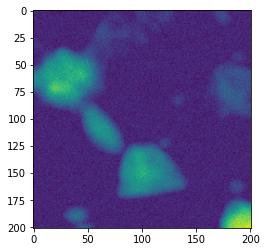

In [188]:
print(HVol.shape)
Yflat = np.sum(YVol, axis=0)
plt.imshow(Yflat)

In [ ]:
# G = kmeans.cluster_centers_.T

pixels_side = 201
num_iterations = 1
# Baseline

import time
from scipy import ndimage

angles_hist = []
nnl_hist = []
r2_hist = []
time_hist = []

Ddot = spim.phases
Hflatdot = spim.maps
Ydot = Ddot@Hflatdot

Y = spim.X
G = spim.build_G("bremsstrahlung", norm = True)


# 1. Baseline
downsampling_factors = [1]
Hflat =None
W = None
Ximg = Y.reshape((-1, pixels_side,pixels_side))

for i in range(len(downsampling_factors)):

    start_time = time.time()
    n = downsampling_factors[i]
    X = downsample(Ximg,n)

    Xflat = X.reshape((X.shape[0], -1))
    est = SmoothNMF( n_components = 3,tol=0.0001, max_iter = num_iterations, G = G, lambda_L=0, mu=0, force_simplex=False)
    D , Hs, Ws, _, losses = est.fit_transform(Xflat, update_W=True)
    Hflat = est.H_
    W = est.W_

Yest = D@Hflat
# Calculate Errors
angle, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
nll = np.sum(-Ydot.flatten()*np.log(Yest.flatten()+0.000000000001)+ Yest.flatten())
r2 = ordered_r2(Hflatdot_down, Hflat, true_inds)

# Append
angles_hist.append(sum(angle)/len(angle))
kl_hist.append(nll)
r2_hist.append(sum(r2)/len(r2))
time_hist.append(time.time()-start_time)

plot_results_report(Ddot, D, Hflatdot_down, Hflat, pixels_side//n, Hs, Ws, G, losses)


# 2. Regularization
downsampling_factors = [1]
Hflat =None
W = None
Ximg = Y.reshape((-1, pixels_side,pixels_side))

for i in range(len(downsampling_factors)):

    start_time = time.time()
    n = downsampling_factors[i]
    X = downsample(Ximg,n)

    Xflat = X.reshape((X.shape[0], -1))
    est = SmoothNMF( n_components = 3,tol=0.0001, max_iter = num_iterations, G = G, lambda_L=10, mu=10, force_simplex=False)
    D , Hs, Ws, _, losses = est.fit_transform(Xflat, update_W=True)
    Hflat = est.H_
    W = est.W_

Yest = D@Hflat
# Calculate Errors
angle, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
nll = np.sum(-Ydot.flatten()*np.log(Yest.flatten()+0.000000000001)+ Yest.flatten())
r2 = ordered_r2(Hflatdot_down, Hflat, true_inds)

# Append
angles_hist.append(sum(angle)/len(angle))
kl_hist.append(nll)
r2_hist.append(sum(r2)/len(r2))
time_hist.append(time.time()-start_time)

plot_results_report(Ddot, D, Hflatdot_down, Hflat, pixels_side//n, Hs, Ws, G, losses)

# 3. Binning (3 + 1)
downsampling_factors = [3,1]
Hflat =None
W = None
Ximg = Y.reshape((-1, pixels_side,pixels_side))

for i in range(len(downsampling_factors)):

    start_time = time.time()
    n = downsampling_factors[i]
    X = downsample(Ximg,n)
    Xflat = X.reshape((X.shape[0], -1))

    if (i > 0):
        factor = downsampling_factors[i-1]//downsampling_factors[i]
        H = Hflat.reshape((-1, pixels_side//n//factor, pixels_side//n//factor))
        H = H.repeat(factor, axis = 1).repeat(factor, axis = 2)
        Hflat = H.reshape((-1, pixels_side*pixels_side//n//n)) +0.01
        W =  W 
    
    est = SmoothNMF( n_components = 3,tol=0.0001, max_iter = num_iterations, G = G, lambda_L= 0., mu=0., force_simplex=False)
    if i > 0:
        D , Hs, Ws, losses = est.fit_transform(Xflat, H=Hflat, W=W, update_W=False)
    else:
        D , Hs, Ws, losses = est.fit_transform(Xflat, update_W=True)

    Hflat = est.H_
    W = est.W_

Yest = D@Hflat
# Calculate Errors
angle, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
nll = np.sum(-Ydot.flatten()*np.log(Yest.flatten()+0.000000000001)+ Yest.flatten())
r2 = ordered_r2(Hflatdot_down, Hflat, true_inds)

# Append
angles_hist.append(sum(angle)/len(angle))
kl_hist.append(nll)
r2_hist.append(sum(r2)/len(r2))

plot_results_report(Ddot, D, Hflatdot_down, Hflat, pixels_side//n, Hs, Ws, G, losses)

# 3.1 Binning (3 + Pinv)

# 4. Smoothing Linear Filter (alpha 0.9)
downsampling_factors = [1]
Hflat =None
W = None
alpha = 0.9
YSmoothedMapsMix =  YVol*(1-alpha)+ YSmoothedMaps*(alpha)
Ximg = YSmoothedMapsMix.reshape((-1, pixels_side,pixels_side))+0.000000000001

for i in range(len(downsampling_factors)):

    start_time = time.time()
    n = downsampling_factors[i]
    X = downsample(Ximg,n)

    Xflat = X.reshape((X.shape[0], -1))
    est = SmoothNMF( n_components = 3,tol=0.0001, max_iter = num_iterations, G = G, lambda_L=10, mu=10, force_simplex=False)
    D , Hs, Ws, _, losses = est.fit_transform(Xflat, update_W=True)
    Hflat = est.H_
    W = est.W_

Yest = D@Hflat
# Calculate Errors
angle, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
nll = np.sum(-Ydot.flatten()*np.log(Yest.flatten()+0.000000000001)+ Yest.flatten())
r2 = ordered_r2(Hflatdot_down, Hflat, true_inds)

# Append
angles_hist.append(sum(angle)/len(angle))
kl_hist.append(nll)
r2_hist.append(sum(r2)/len(r2))
time_hist.append(time.time()-start_time)

plot_results_report(Ddot, D, Hflatdot_down, Hflat, pixels_side//n, Hs, Ws, G, losses)

# 5. Smoothing Median Filter



# YSmoothedMedian = ndimage.median_filter(YVol, size=(1,3,3))
for idx in range(len(alphas)):
    alpha = alphas[idx]
    YSmoothedMapsMix =  YVol*(1-alpha)+ YSmoothedMaps*(alpha)
    Ximg = YSmoothedMapsMix.reshape((-1, pixels_side,pixels_side))+0.000000000001
    
    # Ximg = YMix.reshape((-1, pixels_side,pixels_side))+0.000000000001

    for i in range(len(downsampling_factors)):

        start_time = time.time()
        n = downsampling_factors[i]
        X = downsample(Ximg,n)

        Xflat = X.reshape((X.shape[0], -1))
        est = SmoothNMF( n_components = 3,tol=0.0001, max_iter = num_iterations, G = G, lambda_L=0, mu=0, force_simplex=False)
        D , Hs, Ws, G, losses = est.fit_transform(Xflat, update_W=True)
        Hflat = est.H_
        W = est.W_
        Wdot = spim.phases


        angle, true_inds = find_min_angle(spim.phases.T, D.T, unique=True, get_ind=True)
        angles_hist.append(sum(angle)/len(angle))


        Hflatdot_down = downsample_flat(spim.maps,n, pixels_side)

        Yest = D@Hflat
        Ydot = spim.phases@Hflatdot_down

        print(Yest.shape, Ydot.shape)

        nll = np.sum(-Ydot.flatten()*np.log(Yest.flatten()+0.000000000001)+ Yest.flatten())
        kl_hist.append(nll)

        r2 = ordered_r2(Hflatdot_down, Hflat, true_inds)
        r2_hist.append(sum(r2)/len(r2))




        plot_results_report(spim.phases, D, Hflatdot_down, Hflat, pixels_side//n, Hs, Ws, G, losses)


In [16]:
spim.metadata
spim.metadata.Truth.Params.N
print(P_side)

201


In [123]:

# YSmoothedSpectra = np.zeros((C,P_side,P_side))
# for i in range(100):
#     for j in range(100):
#     # print(Y[c,:,:].shape,, res.shape)
#         YSmoothedSpectra[:,i,j] = signal.convolve(YVol[:,i,j], filter_spectras, mode='same')

In [8]:
G = spim.build_G("bremsstrahlung", norm = True)
# G = kmeans.cluster_centers_.T
Y = spim.X


YVol = Y.reshape(1980,201,201)


pixels_side = 201
num_iterations = 1
# Baseline
downsampling_factors = [1]
Hflat =None
W = None
import time
from scipy import ndimage

angles_hist = []
kl_hist = []
r2_hist = []

alphas = np.arange(0,1.01,0.1)
# YSmoothedMedian = ndimage.median_filter(YVol, size=(1,3,3))
for idx in range(len(alphas)):
    alpha = alphas[idx]
    YSmoothedMapsMix =  YVol*(1-alpha)+ YSmoothedMaps*(alpha)
    Ximg = YSmoothedMapsMix.reshape((-1, pixels_side,pixels_side))+0.000000000001
    
    # Ximg = YMix.reshape((-1, pixels_side,pixels_side))+0.000000000001

    for i in range(len(downsampling_factors)):

        start_time = time.time()
        n = downsampling_factors[i]
        X = downsample(Ximg,n)

        Xflat = X.reshape((X.shape[0], -1))
        est = SmoothNMF( n_components = 3,tol=0.0001, max_iter = num_iterations, G = G, lambda_L=0, mu=0, force_simplex=False)
        D , Hs, Ws, G, losses = est.fit_transform(Xflat, update_W=True)
        Hflat = est.H_
        W = est.W_
        Wdot = spim.phases


        angle, true_inds = find_min_angle(spim.phases.T, D.T, unique=True, get_ind=True)
        angles_hist.append(sum(angle)/len(angle))


        Hflatdot_down = downsample_flat(spim.maps,n, pixels_side)

        Yest = D@Hflat
        Ydot = spim.phases@Hflatdot_down

        print(Yest.shape, Ydot.shape)

        nll = np.sum(-Ydot.flatten()*np.log(Yest.flatten()+0.000000000001)+ Yest.flatten())
        kl_hist.append(nll)

        r2 = ordered_r2(Hflatdot_down, Hflat, true_inds)
        r2_hist.append(sum(r2)/len(r2))




        plot_results_report(spim.phases, D, Hflatdot_down, Hflat, pixels_side//n, Hs, Ws, G, losses)


NameError: name 'YSmoothedMaps' is not defined

[20.00157237 20.0016353  12.00104661 ... 14.00122105 23.00188723
 18.00105342]


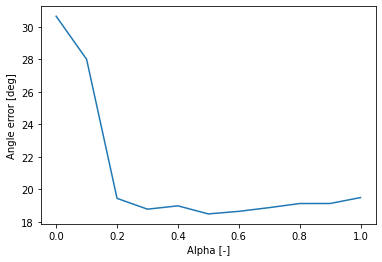

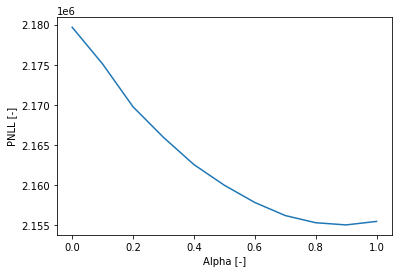

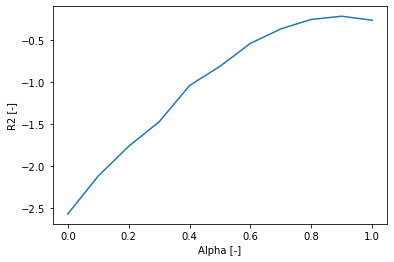

[2179663.417396994, 2175088.928217734, 2169750.842158758, 2165943.925894345, 2162555.1950929654, 2159979.0334465443, 2157835.2708773017, 2156204.414857242, 2155310.4622882553, 2155037.540531723, 2155473.4081134624]


In [67]:
plt.plot(alphas, angles_hist)
plt.xlabel("Alpha [-]")
plt.ylabel("Angle error [deg]")
plt.show()

plt.plot(alphas, kl_hist)
plt.xlabel("Alpha [-]")
plt.ylabel("PNLL [-]")
plt.show()

plt.plot(alphas, r2_hist)
plt.xlabel("Alpha [-]")
plt.ylabel("R2 [-]")
plt.show()

print(kl_hist)

/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


exits because max_iteration was reached
Stopped after 1 iterations in 0.0 minutes and 5.0 seconds.
{'N': 17, 'data_folder': 'None', 'model': 'EDXS', 'seed': 43, 'weight_type': 'data', 'densities': [1.2, 1.0, 0.8], 'weights_params': array([[[0.        , 0.05837955, 0.94162045],
        [0.        , 0.05735297, 0.94264703],
        [0.        , 0.05499701, 0.94500299],
        ...,
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 1.        ]],

       [[0.        , 0.04932969, 0.95067031],
        [0.        , 0.04834995, 0.95165005],
        [0.        , 0.04608505, 0.95391495],
        ...,
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 1.        ]],

       [[0.        , 0.03188602, 0.96811398],
        [0.        , 0.03099917, 0.96900083],
        [0.        , 0.02891692, 0.97108308],
        ...,
        [0.        , 0.        , 1.

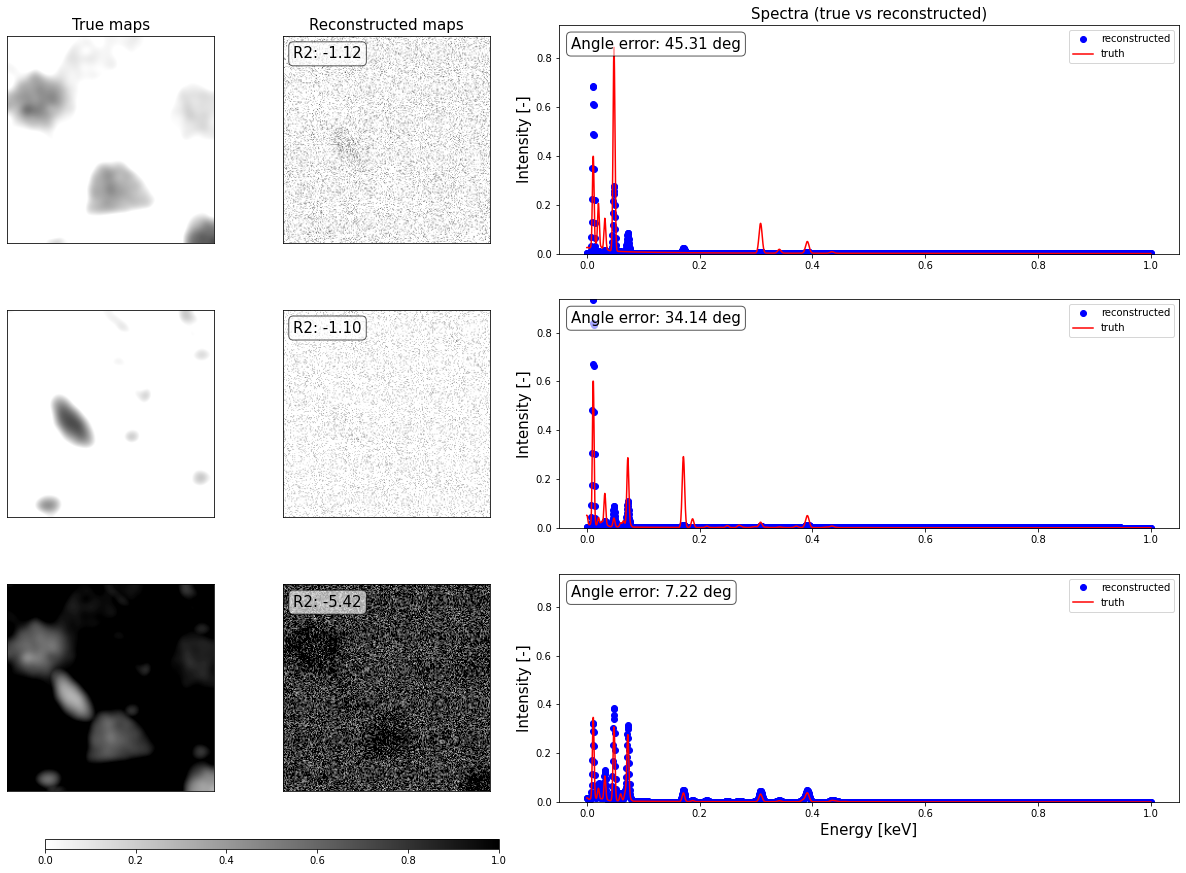

In [31]:
G = spim.build_G("bremsstrahlung", norm = True)
# G = kmeans.cluster_centers_.T
Y = spim.X


# YVol = Y.reshape(1980,201,201)


pixels_side = 201
num_iterations = 1
# Baseline
downsampling_factors = [1]
Hflat =None
W = None
import time
from scipy import ndimage

angles_hist = []
kl_hist = []
r2_hist = []

alphas = np.arange(0,0.1,0.1)
# YSmoothedMedian = ndimage.median_filter(YVol, size=(1,3,3))
for idx in range(len(alphas)):
    alpha = alphas[idx]
    YSmoothedMapsMix =  YVol*(1-alpha)+ YSmoothedMaps*(alpha)
    Ximg = YSmoothedMapsMix.reshape((-1, pixels_side,pixels_side))+0.000000000001
    
    # Ximg = YMix.reshape((-1, pixels_side,pixels_side))+0.000000000001

    for i in range(len(downsampling_factors)):

        start_time = time.time()
        n = downsampling_factors[i]
        X = downsample(Ximg,n)

        Xflat = X.reshape((X.shape[0], -1))
        est = SmoothNMF( n_components = 3,tol=0.0001, max_iter = num_iterations, G = G, lambda_L=0, mu=0, force_simplex=False)
        D , Hs, Ws, G, losses = est.fit_transform(Xflat, update_W=True)
        Hflat = est.H_
        W = est.W_
        Wdot = spim.phases


        angle, true_inds = find_min_angle(spim.phases.T, D.T, unique=True, get_ind=True)
        angles_hist.append(sum(angle)/len(angle))


        Hflatdot_down = downsample_flat(spim.maps,n, pixels_side)

        Yest = D@Hflat
        Ydot = spim.phases@Hflatdot_down

        print(Yest.shape, Ydot.shape)

        nll = np.sum(-Ydot.flatten()*np.log(Yest.flatten()+0.000000000001)+ Yest.flatten())
        kl_hist.append(nll)

        r2 = ordered_r2(Hflatdot_down, Hflat, true_inds)
        r2_hist.append(sum(r2)/len(r2))




        plot_results_report(spim.phases, D, Hflatdot_down, Hflat, pixels_side//n, Hs, Ws, G, losses)


In [29]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
print(kmeans.labels_)
print(kmeans.predict([[0, 0], [12, 3]]))
print(kmeans.cluster_centers_)

Xclus = (spim.X).T
print(((spim.X).T).shape)
kmeans = KMeans(n_clusters=14, random_state=0).fit(Xclus)
print(kmeans.labels_)
print(kmeans.cluster_centers_)


[1 1 1 0 0 0]
[1 0]
[[10.  2.]
 [ 1.  2.]]
(40401, 1980)


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


[12  1  4 ...  4  5 13]
[[ 1.81623932e-02  2.45726496e-02  1.92307692e-02 ...  2.43945489e-19
  -8.13151629e-20  2.43945489e-19]
 [ 1.89189189e-02  1.60083160e-02  1.78794179e-02 ... -1.35525272e-19
   2.46655994e-18  2.07900208e-04]
 [ 1.96496212e-02  1.65719697e-02  2.03598485e-02 ...  5.42101086e-19
   2.35813973e-18  2.36742424e-04]
 ...
 [ 1.74958994e-02  1.64024057e-02  1.80426463e-02 ...  6.50521303e-19
   2.22261445e-18  2.73373428e-04]
 [ 1.58595299e-02  1.67091476e-02  1.72755593e-02 ...  2.83205891e-04
   2.83205891e-04  6.23416249e-19]
 [ 1.44541651e-02  1.93990110e-02  1.55952834e-02 ...  8.13151629e-20
   3.80372765e-04  3.80372765e-04]]


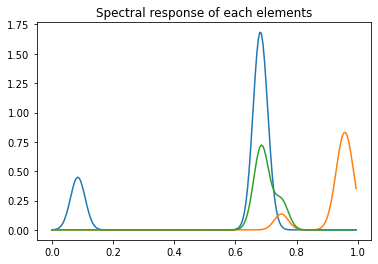

In [162]:
np.random.seed(1)
n_poisson = 300 # Average poisson number per pixel (this number will be splitted on the L dimension)

G, Wdot, Ddot, Hdot, Hdotflat, Ydot, Y, shape_2d, K = create_toy_problem(L, C, n_poisson, seed=1)
l = np.arange(0, 1, 1/L)
plt.plot(l, G[:,:3])
plt.title("Spectral response of each elements")

YVol = Y.reshape(200,100,100)


In [50]:
import math

def buildSmoothFilter(Y, N_rows, size_filter):

    # Retrieve the databuce
    Y = Y

    # Shape into a 3D strcture
    # YVol = Y.reshape(Y.shape[0],int(math.sqrt(Y.shape[1])),int(math.sqrt(Y.shape[1])))
    Yvol = Y

    # Smooth maps 
    P_side = YVol.shape[1]
    C = YVol.shape[0]
    D1, D2, D3 = size_filter[0], size_filter[1], size_filter[2]

    # Random integer between 0 and 19 (including both)
    rand_channel = np.random.randint(D1//2,C-(D1//2)-1,N_rows)
    rand_idx_x = np.random.randint(D2//2,P_side-(D2//2)-1,N_rows)
    rand_idx_y = np.random.randint(D3//2,P_side-(D3//2)-1,N_rows)
    print(rand_idx_x)

    N = np.zeros((N_rows, D1*D2*D3), dtype = np.float32)
    b = np.zeros(N_rows, dtype = np.float32)

    count = 0
    for i in range(N_rows):
        channel, idx_x, idx_y = rand_channel[i], rand_idx_x[i], rand_idx_y[i]
        flattened_img = YVol[channel-D1//2:channel+D1//2+1,idx_x-D2//2:idx_x+D2//2+1,idx_y-D3//2:idx_y+D3//2+1].flatten()
        N[i,:] = flattened_img
        b[i] = YVol[channel,idx_x,idx_y]

    print(N.shape, b.shape)

    Nmin = np.min(N, axis=1)
    Nmax = np.max(N, axis=1)
    Ndif = Nmax - Nmin
    NmaxAbs = np.max(Ndif)
    Ndif_avg = np.mean(Ndif)

    print('1',N.shape, b.shape)

    ks = Ndif_avg+(NmaxAbs-Ndif_avg)*0.1
    N = N[np.where(Ndif>ks),:]
    b = b[np.where(Ndif>ks)]
    N = N[0,:,:]
    print(N.shape, b.shape)

    # Solve the quadratic problem: minimize  1/2w^T P w + q^T w  s.t Cw <= d and Aw = b
    P_ = 2*N.T@N
    q_ = -2*N.T@b

    # Inequality constraints
    C_ = -np.eye(D1*D2*D3)
    d_ = np.zeros((D1*D2*D3,))

    # Equality constraints
    A_= np.zeros((1,D1*D2*D3))
    A_[0,(D1*D2*D3)//2] = 1
    # A_[1,:] = np.ones((D2*D3,))
    b_ = np.zeros((1,))
    # b_[1] = 1 
    
    print(A_.shape, b_.shape)

    # Solve the quadratic program
    filter_maps = quadprog_solve_qp(np.array(P_, dtype=np.double),np.array(q_, dtype=np.double), G=np.array(C_, dtype=np.double), h=np.array(d_, dtype=np.double), A=np.array(A_, dtype=np.double), b=np.array(b_, dtype=np.double))
    filter_maps = filter_maps.reshape(D1,D2,D3)

    # Plot the filter
    plt.imshow(filter_maps[D1//2,:,:])
    plt.colorbar()
    plt.show()


    # Check that the weights add up to 1
    assert abs(np.sum(filter_maps) - 1) < 0.01

    # Check that the central value is equal to 0
    assert abs(filter_maps[D2//2,D3//2]) < 0.01

    # Check that all entries are non-negative
    assert np.all(filter_maps >= 0)

   

[[ 9056  9038  9071 ...  8882  9002  8920]
 [ 9004  9041  9174 ...  8837  8898  9113]
 [ 9123  9094  9265 ...  8926  9050  8789]
 ...
 [ 9038  8996  8858 ... 12077 11868 12045]
 [ 8906  8872  8826 ... 11891 11859 11978]
 [ 8976  9183  8969 ... 11812 11933 12299]]


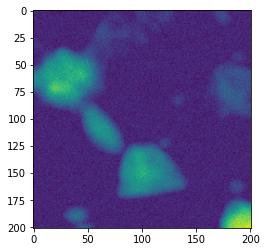

In [12]:
print(Yflat)
plt.imshow(Yflat)

(1980, 201, 201)


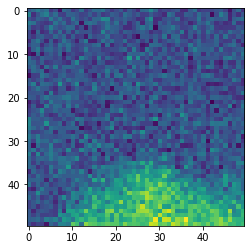

(1980, 201, 201)
(198, 201, 201)
(201, 201)
[ 55 162  22 ...  22  66  75]
(250000, 121) (250000,)
1 (250000, 121) (250000,)
(13510, 121) (13510,)
(1, 121) (1,)


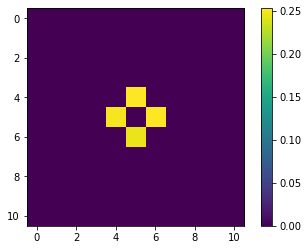

IndexError: index 5 is out of bounds for axis 0 with size 1

In [56]:
Y = spim1176.X
import math
YVol = Y.reshape(Y.shape[0],int(math.sqrt(Y.shape[1])),int(math.sqrt(Y.shape[1])))
print(YVol.shape)

YVol_bin = YVol.reshape(198, 10, 201, 201).sum(1)
plt.imshow(np.sum(YVol_bin, axis=0)[:50,:50])
plt.show()
print(YVol.shape)
print(YVol_bin.shape)
YVol =  ndimage.median_filter(YVol, size=(1,3,3))
Yflat = np.sum(YVol, axis=0)
print(Yflat.shape)
buildSmoothFilter(Yflat, 250000, (1,11,11))

Running DCT
n: 201
Generating DCT basis images
Complete


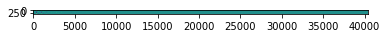

In [59]:
'''
Discrete Cosine Transform
Author: Andrew Chalmers, 2014
    
This calculates the DCT at different frequencies in two dimensions. 
Some packages don't allow you to specify the specific basis (u,v), but
instead sum across the frequencies giving you the final result.
Useful applications for specifying a certain basis can be for educational
purposes (visualising the basis functions), or if you need to split the 
basises into a dictionary for learning.
I've left this unoptimised for clarity. 
Resources:
Image and video processing: From Mars to Hollywood with a stop at the hospital,
lecture 10. By Guillermo Sapiro from Duke University
https://www.youtube.com/watch?v=pZuaOjfsv0Y&list=PLZ9qNFMHZ-A79y1StvUUqgyL-O0fZh2rs&index=10
https://www.youtube.com/watch?v=_bltj_7Ne2c&list=PLZ9qNFMHZ-A79y1StvUUqgyL-O0fZh2rs&index=11
'''

import sys
from math import cos,sqrt,pi
import numpy as n_
import pylab as p_
import matplotlib.cm as cm

def dct(x, y, u, v, n):
    # Normalisation
    def alpha(a):
        if a==0:
            return sqrt(1.0/n)
        else:
            return sqrt(2.0/n)
    return alpha(u) * alpha(v) * cos(((2*x+1)*(u*pi))/(2*n)) * cos(((2*y+1)*(v*pi))/(2*n))

def getBasisImage(u, v, n):
    # for a given (u,v), make a DCT basis image
    basisImg = n_.zeros((n,n))
    for y in range(0, n):
        for x in range(0, n):
            basisImg[y,x] = dct(x, y, u, v, n)
    return basisImg

if __name__ == '__main__':
    print("Running DCT")

    N_freq = 20
    Z = np.zeros((N_freq*N_freq,n*n))


    # n (int): assume square image, so we don't have different xres and yres
    try:
        n = int(sys.argv[1])
    except:
        n = 201
    print("n: %d" % n)

    # We can get different frequencies by setting u and v
    print("Generating DCT basis images")
    imageSet = []
    for u in range(0, N_freq):
        for v in range(0, N_freq):
            basisImg = getBasisImage(u, v, n)
    
            Z[u*N_freq+v,:] = basisImg.flatten()
            imageSet.append(basisImg)

    print("Complete" )

    plt.imshow(Z)
    plt.show()

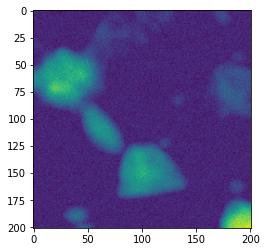

(400, 40401)
(40401, 400)
(1, 400)
(1, 40401)


In [60]:
plt.imshow(Yflat)
plt.show()
print(Z.shape)

Yflatten = Yflat.reshape(1,Yflat.shape[0]*Yflat.shape[0])
print(np.linalg.pinv(Z).shape)
E = Yflatten@np.linalg.pinv(Z)
print(E.shape)

print(Yflatten.shape)

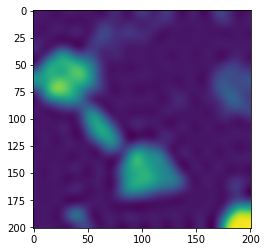

(1, 400)


In [62]:
recon = E@Z
plt.imshow(recon.reshape(Yflat.shape[0],Yflat.shape[0]))
plt.show()
print(E.shape)


In [74]:
G = spim.build_G("bremsstrahlung", norm = True)

H = np.zeros((3,201*201))
G = np.zeros((2000,14))
print(( np.sum(H, axis=1,  keepdims=True).T).shape)
print(np.sum(G, axis=0,  keepdims=True).T.shape)

print((np.sum(G, axis=0,  keepdims=True).T @ np.sum(H, axis=1,  keepdims=True).T).shape)

(1, 3)
(14, 1)
(14, 3)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


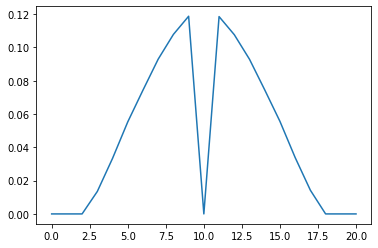

In [164]:
# Smooth spectras



for i_ in range(10,190):
    for i in range(100):
        for j in range(100):
            flattened_img = YVol[i_-10:i_+11,i,j].flatten()
            N[(i)*90+(j)+90*90*(i_-10),:] = flattened_img
            b[(i)*90+(j)+90*90*(i_-10)] = YVol[i_,i,j]
P = 2*N.T@N
q = -2*N.T@b
G = -np.eye(21)
h = np.zeros((21,))
A = np.zeros((1,21))
A[0,21//2] = 1
b = np.zeros((1,))
print(A)

filter_spectras = quadprog_solve_qp(np.array(P, dtype=np.double),np.array(q, dtype=np.double), G=np.array(G, dtype=np.double), h=np.array(h, dtype=np.double), A=np.array(A, dtype=np.double), b=np.array(b, dtype=np.double))
plt.plot(filter_spectras)
plt.show()

In [9]:
losses = []
variances = []
YdotVol = Ydot.reshape(200,100,100)
alphas = np.arange(0.95,1.01,0.001)
YSmoothedMaps = np.zeros((200,100,100))
filter_maps_flattened = filter_maps.flatten()
for c in range(200):
    # print(Y[c,:,:].shape,, res.shape)
    YSmoothedMaps[c,:,:] = signal.convolve2d(YVol[c,:,:], filter_maps, boundary='symm', mode='same')
YSmoothedSpectra = np.zeros((200,100,100))
for i in range(100):
    for j in range(100):
    # print(Y[c,:,:].shape,, res.shape)
        YSmoothedSpectra[:,i,j] = signal.convolve(YVol[:,i,j], filter_spectras, mode='same')


a = np.sum(N*filter_maps_flattened*filter_maps_flattened, axis=1)
print(np.mean((N[1000,(11*11)//2])/(a[1000]+N[1000,(11*11)//2]+0.0000000000000000001)))

print(1-1/(1+np.sum(filter_maps_flattened*filter_maps_flattened)))

for i in range(len(alphas)):
    alpha = alphas[i]
    YMix =  YVol*(1-alpha)+ YSmoothedMaps*(alpha)
    loss = np.sum((YdotVol[:,5:95,5:95]-YMix[:,5:95,5:95])**2)
    print(loss)
    print(np.mean(YMix), np.mean(YVol), np.mean(YSmoothedMaps))
    print(np.var(YMix),(1-alpha)**2*np.var(YVol) + alpha**2* np.var(YSmoothedMaps) + 2*cov[1,0]*alpha*(1-alpha))
    variances.append(np.var(YMix))
    losses.append(loss)

plt.plot(alphas,losses)
plt.show()

plt.plot(alphas, variances)
plt.show()

alpha = 0.1

YSmoothedMapsMix =  YVol*(1-alpha)+ YSmoothedMaps*(alpha)
YSmoothedSpectraMix =  YVol*(1-alpha)+ YSmoothedSpectra*(alpha)



NameError: name 'Ydot' is not defined

In [252]:
print(np.mean(filter_maps_flattened))

0.008264462809917357


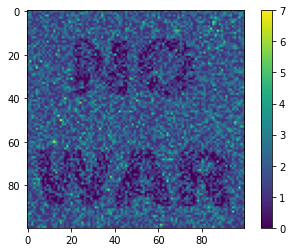

(1620000, 1331) (1620000,)
(1331, 1331) (1331,) (121, 121) (121,) (121,) (1,)
(1331, 1331) (1331,) (121, 121) (121,)


ValueError: G and C must have the same first dimension. Received G as (1331,1331) and C as (121, 121)

In [ ]:

# X = np.zeros((90*90*200, 11*11*11), dtype = np.float32)
# b = np.zeros((90*90*200), dtype = np.float32)
# for i_ in range(5,195):
#     for i in range(5,95):
#         for j in range(5,95):
#             flattened_img = YVol[i_-5:i_+6,i-5:i+6,j-5:j+6].flatten()
#             X[(i-5)*90+(j-5)+90*90*(i_-5),:] = flattened_img
#             b[(i-5)*90+(j-5)+90*90*(i_-5)] = YVol[i_,i,j]

# print(X.shape,b.shape)
# P = 2*X.T@X
# q = -2*X.T@b
# G = -np.eye(121*11)
# G[(121**11)//2,(121**11)//2] = 1
# h = np.zeros(((121**11),))
# A = np.ones(((121**11),))
# b = np.ones((1,))
# print(P.shape, q.shape, G.shape, h.shape, A.shape, b.shape)

# res = quadprog_solve_qp(np.array(P, dtype=np.double),np.array(q, dtype=np.double), G=np.array(G, dtype=np.double), h=np.array(h, dtype=np.double))
# plt.imshow(res.reshape(11,11))
# plt.colorbar()
# plt.show()

# res = res.reshape(11,11)
# f1 = signal.convolve2d(im1, res, boundary='symm', mode='same')
# plt.imshow(f1)
# plt.colorbar()
# plt.show()



# plt.imshow(0.8*f1 + 0.2*im1)
# plt.colorbar()
# plt.show()



(100, 100) (121,)


ValueError: convolve2d inputs must both be 2-D arrays

In [14]:
losses = []
YdotVol = Ydot.reshape(200,100,100)
alphas = np.arange(0.9,1,0.01)
for i in range(len(alphas)):
    alpha = alphas[i]
    smoothedY = np.zeros((200,100,100))
    for c in range(200):
        # print(Y[c,:,:].shape,, res.shape)
        smoothedY[c,:,:] = signal.convolve2d(Y[c,:,:], res, boundary='symm', mode='same')
    smoothedY =  Y*(1-alpha)+ smoothedY*(alpha)
    loss = np.sum(np.abs(YdotVol-smoothedY)**2)
    print(loss)

    losses.append(loss)

plt.plot(alphas,losses)
plt.show()

alpha = 0.1
smoothedY = np.zeros((200,100,100))
for c in range(200):
    # print(Y[c,:,:].shape,, res.shape)
    smoothedY[c,:,:] = signal.convolve2d(Y[c,:,:], res, boundary='symm', mode='same')
smoothedY =  Y*(1-alpha)+ smoothedY*(alpha)

Y = Y.reshape(200,100,100)



NameError: name 'Ydot' is not defined

In [27]:
G = spim.build_G("bremsstrahlung", norm = True)
# G = kmeans.cluster_centers_.T
Y = spim.X
pixels_side = 201
num_iterations = 10
# Baseline
downsampling_factors = [3]
Hflat =None
W = None
import time
from scipy import ndimage

angles_hist = []

alphas = np.arange(0,0.1,0.2)

for idx in range(len(alphas)):
    alpha = alphas[idx]
    YSmoothedMapsMix =  YVol*(1-alpha)+ YSmoothedMaps*(alpha)
    Ximg = YSmoothedMapsMix.reshape((-1, pixels_side,pixels_side))+0.000000000001

    for i in range(len(downsampling_factors)):

        start_time = time.time()
        n = downsampling_factors[i]
        X = downsample(Ximg,n)
        # X = ndimage.median_filter(X, size=(1,3,3))
        print(X.shape)
        Xflat = X.reshape((X.shape[0], -1))
        print(Xflat.shape)
        print(Xflat.shape, G.shape)
        est = SmoothNMF( n_components = 3,tol=0.0001, max_iter = num_iterations, G = G, lambda_L=0, mu=0, force_simplex=False)
        D , Hs, Ws, G, losses = est.fit_transform(Xflat, update_W=True)
        Hflat = est.H_
        W = est.W_

        Hdotflat_down = downsample_flat(Hdotflat, n, pixels_side)

        angle, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
        angles_hist.append(sum(angle)/len(angle))

        r2 = ordered_r2(Hdotflat_down, Hflat, true_inds)


        plot_results(Ddot, D, Hdotflat_down, Hflat, pixels_side//n, Hs, Ws, G, losses)

(1980, 67, 67)
(1980, 4489)


AttributeError: 'function' object has no attribute 'shape'

[12.789272287920241, 12.842619866557063, 12.905056628004607, 12.95708142258036, 13.018859565075227, 13.090425298047776, 13.168696233096071, 13.26878851537282, 13.435101185481633, 13.433059116280733]


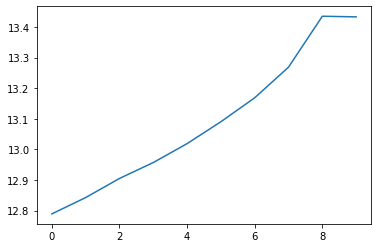

In [256]:
print(angles_hist)

plt.plot(angles_hist)
plt.show()

In [190]:
def runProblem(downsampling_factors, max_iter, tol, ):
    Hflat =None
    W = None

    for i in range(len(downsampling_factors)):
        start_time = time.time()
        n = downsampling_factors[i]
        X = downsample(Ximg,n)
        Xflat = X.reshape((X.shape[0], -1))
        if (i > 0):
            factor = downsampling_factors[i-1]//downsampling_factors[i]
            H = Hflat.reshape((-1, pixels_side//n//factor, pixels_side//n//factor))
            H = H.repeat(factor, axis = 1).repeat(factor, axis = 2)
            Hflat = H.reshape((-1, pixels_side*pixels_side//n//n)) +0.001
            W =  W 

        
        est = SmoothNMF( n_components = 3,tol=tol, max_iter =max_iter, G = None, lambda_L=lambdas[j], mu=mus[j], force_simplex=False)

        if i > 0:
            D , Hs, Ws, G, losses = est.fit_transform(Xflat, W=W, H=Hflat, update_W=False)

        else:
            D , Hs, Ws, G, losses = est.fit_transform(Xflat, W=W, H=Hflat, update_W=False)


        Hflat = est.H_
        W = est.W_

        # Wdot = spim.phases
        Hdotflat_down = downsample_flat(Hdotflat, n, pixels_side)
        times_exp[-1].append(time.time()-start_time)

        angle, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
        r2 = ordered_r2(Hdotflat_down, Hflat[true_inds,:], true_inds)

        angle_max_exp[-1].append(sum(angle)/len(angle))
        r2_max_exp[-1].append(sum(r2)/len(r2))

        plot_results(Ddot, D, Hdotflat_down, Hflat, pixels_side//n, Hs, Ws, G, losses)
    return 

In [12]:
def downsample(X,n):
    b = X.shape[2]//n
    return X.reshape(X.shape[0], -1, n, b, n).sum((-1, -3)) /(n*n)

def downsample_flat(X,n, pixels_side):
    X = X.reshape((-1, pixels_side,pixels_side))
    X = downsample(X,n)
    return X.reshape((-1, pixels_side*pixels_side//n//n))

def checkerboard(X):
    n = X.shape[2]
    if n % 2 != 0:
        raise ValueError("n must be even")
    evens = np.array([i*2 for i in range(n//2)])
    odds = np.array([i*2+1 for i in range(n//2)])
    X_1 = X[:,evens][:,:,evens]
    X_2 = X[:,evens]
    X_2 = X_2[:,:,odds]
    X_3 = X[:,odds]
    X_3 = X_3[:,:,evens]
    X_4 = X[:,odds]
    X_4 = X_4[:,:,odds]
    return X_1, X_2, X_3, X_4

def NNL(D,H,Y):
    return np.sum(-Y*np.log(D@H+0.0000001) + D@H)

In [17]:


angle_max_exp = []
r2_max_exp = []
kl_max_exp = []
times_exp = []
import time
from scipy import ndimage
pixels_side = 201
Ximg = Y.reshape((-1, pixels_side,pixels_side))
num_iterations = 20




# Baseline
downsampling_factors = [1]
Hflat =None
W = None
start_time = time.time()
n = downsampling_factors[0]
X = downsample(Ximg,n)
XsCheckerboard = checkerboard(X)
print(XsCheckerboard[0].shape)
print(XsCheckerboard[1].shape)

Xflats= [XsCheckerboard[i].reshape((XsCheckerboard[i].shape[0], -1)) for i in range(4)]
    

loss_regs = []

n = 3
m = 3
lambdas = [10**((i//n)-1) for i in range(n*m)]
mus = [10**((i%n)-1) for i in range(n*m)]
for j in range(len(mus)):

    # For every 
    est = SmoothNMF( n_components = 3,tol=0.0001, max_iter = num_iterations, G = None, lambda_L=lambdas[j], mu=mus[j], force_simplex=False)
    Hs_reg = []
    Ds_reg = []
    Ws_reg = []
    loss_reg = 0
    for i in range(3):
        D , Hs, Ws, G, losses = est.fit_transform(Xflats[i], W=None, H=None, update_W=True)
        Hflat = est.H_
        W = est.W_
        loss_reg += NNL(D,Hflat,Xflats[3])
        print(loss_reg)

        times_exp.append(time.time()-start_time)

        angle, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
        plt.imshow(Hflat[true_inds[0]].reshape(50,50))
        plt.show()
        # r2 = ordered_r2(Hdotflat, Hflat, true_inds)

        # angle_max_exp.append(sum(angle)/len(angle))
        # r2_max_exp.append(sum(r2)/len(r2))
        # kl_max_exp.append(ordered_kl(Hdotflat, Hflat, true_inds))

        # plot_results(Ddot, D, Hdotflat, Hflat, pixels_side//n, Hs, Ws, G, losses)
    loss_regs.append(loss_reg)


n = 3
m = 3
labels = ["$\mu$ ="+str(mus[i])+"$\lambda$ ="+str(lambdas[i]) for i in range(n*m)]

from matplotlib.colors import LinearSegmentedColormap

cmap_red_green = LinearSegmentedColormap.from_list("gradients", [(1,0,0),(0,1,0)], N=100)
cmap_green_red = LinearSegmentedColormap.from_list("gradients", [(0,1,0),(1,0,0)], N=100)


Z = [loss_regs[i] for i in range(n*m)]
Z = np.array(Z)
Z = np.reshape(Z, (n,m))

plt.show()
fig = plt.figure(figsize = (10,10))
plt.imshow(Z, cmap=cmap_green_red,origin='lower')
plt.yticks([i for i in range(n)], [str(10**((i)-1)) for i in range(n)])
plt.xticks([i for i in range(m)], [str(10**((i)-1)) for i in range(m)])
plt.ylabel("$\lambda$")
plt.xlabel("$\mu$")
cbar = plt.colorbar()
plt.title("Avg. angle error [deg]")
# plt.draw()
plt.show()
print("fsdfs")


# Find index of lowest loss_reg
min_loss_reg = np.argmin(loss_reg)
num_iterations = 200



print(lambdas[min_loss_reg], mus[min_loss_reg])
est = SmoothNMF( n_components = 3,tol=0.0001, max_iter = num_iterations, G = None, lambda_L=lambdas[min_loss_reg], mu=mus[min_loss_reg], force_simplex=False)

D , Hs, Ws, G, losses = est.fit_transform_checkerboard(Xflats, update_W=True)
Hflat = est.H_
W = est.W_

times_exp.append(time.time()-start_time)

angle, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
r2 = ordered_r2(Hdotflat, Hflat, true_inds)

angle_max_exp.append(sum(angle)/len(angle))
r2_max_exp.append(sum(r2)/len(r2))
kl_max_exp.append(ordered_kl(Hdotflat, Hflat, true_inds))
print(Hflat.shape)
plot_results(Ddot, D, Hdotflat, Hflat, pixels_side, Hs, Ws, G, losses)xr






ValueError: n must be even

In [72]:
print(spim.maps.shape)

AttributeError: 'Signal2D' object has no attribute 'maps'

[55033.105063879615, 55032.85484974536, 55034.204687257065, 55033.04137351257, 55032.874865636986, 55034.21522338161, 55033.109986457814, 55032.86036537781, 55034.13828343479]
(200, 50, 50)


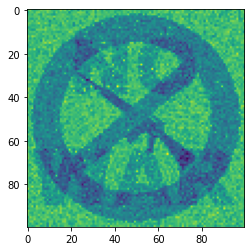

In [65]:
print(loss_regs)
plt.imshow(est.H_[0].reshape(100,100))

print(X[:,::2,1::2].shape)

# Solve the problem

3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  21.135 it/s
It 20 / 100: loss 0.002,  22.278 it/s
exits because of relative change < tol: 0.00010807557705382135
exits because of relative change < tol: 0.00010193291705051613
exits because of relative change < tol: 9.623211566509661e-05
It 30 / 100: loss 0.002,  22.764 it/s
exits because of relative change < tol: 9.089235578925301e-05
exits because of relative change < tol: 8.584885042841883e-05
exits because of relative change < tol: 8.105169338952395e-05
exits because of relative change < tol: 7.646445210445724e-05
exits because of relative change < tol: 7.206252556306354e-05
exits because of relative change < tol: 6.783125496675025e-05
exits because of relative change < tol: 6.376380068189109e-05
exits because of relative change < tol: 5.985887610320645e-05
exits because of relative change < tol: 5.611851456010771e-05
exits because of relative change < tol: 5.254608610378925e-05
It 40 / 100: loss 0.002,  23.076 it/s
exits because of relative change < tol: 

/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  11.043 it/s
It 20 / 100: loss 0.002,  13.007 it/s
It 30 / 100: loss 0.002,  13.965 it/s
It 40 / 100: loss 0.002,  14.108 it/s
It 50 / 100: loss 0.002,  14.514 it/s
It 60 / 100: loss 0.002,  14.779 it/s
It 70 / 100: loss 0.002,  14.734 it/s
It 80 / 100: loss 0.002,  14.919 it/s
It 90 / 100: loss 0.002,  15.073 it/s
exits because max_iteration was reached
Stopped after 100 iterations in 0.0 minutes and 7.0 seconds.
[[1.03050837e+00 9.34333760e-01 1.03119725e+00 ... 1.11961366e+00
  1.03301267e+00 9.77033710e-01]
 [1.00000000e-04 1.00000000e-04 1.00000000e-04 ... 1.00000000e-04
  1.00000000e-04 1.00000000e-04]
 [1.00000000e-04 1.00000000e-04 1.00000000e-04 ... 1.00000000e-04
  1.00000000e-04 1.00000000e-04]]
[[1.03050837e+00 9.34333760e-01 1.03119725e+00 ... 1.11961366e+00
  1.03301267e+00 9.77033710e-01]
 [1.00000000e-04 1.00000000e-04 1.00000000e-04 ... 1.00000000e-04
  1.00000000e-04 1.00000000e-04]
 [1.00000000e-04 1.00000000e-04 1.00000000e-04 ... 1.00000000

/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 40 / 100: loss 0.000,  206.268 it/s
It 50 / 100: loss 0.000,  206.012 it/s
exits because of relative change < tol: 0.00020379603272333645
exits because of relative change < tol: 0.0001883828307736564
exits because of relative change < tol: 0.00017432784356508104
exits because of relative change < tol: 0.0001615242210635976
exits because of relative change < tol: 0.0001498689931463724
exits because of relative change < tol: 0.00013926370854322104
exits because of relative change < tol: 0.0001296150509068364
It 60 / 100: loss 0.000,  207.928 it/s
exits because of relative change < tol: 0.00012083535131700534
exits because of relative change < tol: 0.00011284294767229399
exits because of relative change < tol: 0.0001055623775911317
exits because of relative change < tol: 9.89244077823648e-05
exits because of relative change < tol: 9.286592217432051e-05
exits because of relative change < tol: 8.732969249672147e-05
exits because of relative change < tol: 8.22640658865324e-05
exits becaus

/Users/maxmartinezruts/Documents/GitHub/esmpy/esmpy/measures.py:227: RuntimeWarning: invalid value encountered in log
  return np.sum(true_maps * np.log(true_maps / (algo_maps+ 0.000001) +0.000001))/p
/Users/maxmartinezruts/Documents/GitHub/esmpy/esmpy/measures.py:227: RuntimeWarning: invalid value encountered in log
  return np.sum(true_maps * np.log(true_maps / (algo_maps+ 0.000001) +0.000001))/p


3
It 10 / 100: loss 0.016,  20.312 it/s
It 20 / 100: loss 0.014,  21.018 it/s
It 30 / 100: loss 0.014,  21.228 it/s
exits because of relative change < tol: 0.0003247532598459466
exits because of relative change < tol: 0.00023436798092109218
exits because of relative change < tol: 0.00016879806269252517
exits because of relative change < tol: 0.00012147614334125456
exits because of relative change < tol: 8.748385667600532e-05
exits because of relative change < tol: 6.31629767024546e-05
exits because of relative change < tol: 4.5828158728825835e-05
exits because of relative change < tol: 3.3444212914234034e-05
It 40 / 100: loss 0.014,  21.281 it/s
exits because of relative change < tol: 2.4667281359784158e-05
exits because of relative change < tol: 1.850387871286193e-05
exits because of relative change < tol: 1.4152393413423225e-05
exits because of relative change < tol: 1.1055621460288925e-05
exits because of relative change < tol: 8.826186692966418e-06
exits because of relative change 

/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.000,  21.683 it/s
It 20 / 100: loss 0.000,  22.711 it/s
It 30 / 100: loss 0.000,  23.134 it/s
It 40 / 100: loss 0.000,  22.970 it/s
exits because of relative change < tol: 0.00012752638184090686
exits because of relative change < tol: 0.00011726939467839708
exits because of relative change < tol: 0.0001079728235116972
exits because of relative change < tol: 9.95241497420972e-05
exits because of relative change < tol: 9.182702933627724e-05
exits because of relative change < tol: 8.479953084953227e-05
exits because of relative change < tol: 7.837222524105374e-05
exits because of relative change < tol: 7.248627614355653e-05
exits because of relative change < tol: 6.709163039415869e-05
exits because of relative change < tol: 6.214537634666681e-05
It 50 / 100: loss 0.000,  23.062 it/s
exits because of relative change < tol: 5.7610304324820626e-05
exits because of relative change < tol: 5.3453688954483136e-05
exits because of relative change < tol: 4.9646295377994625e-05


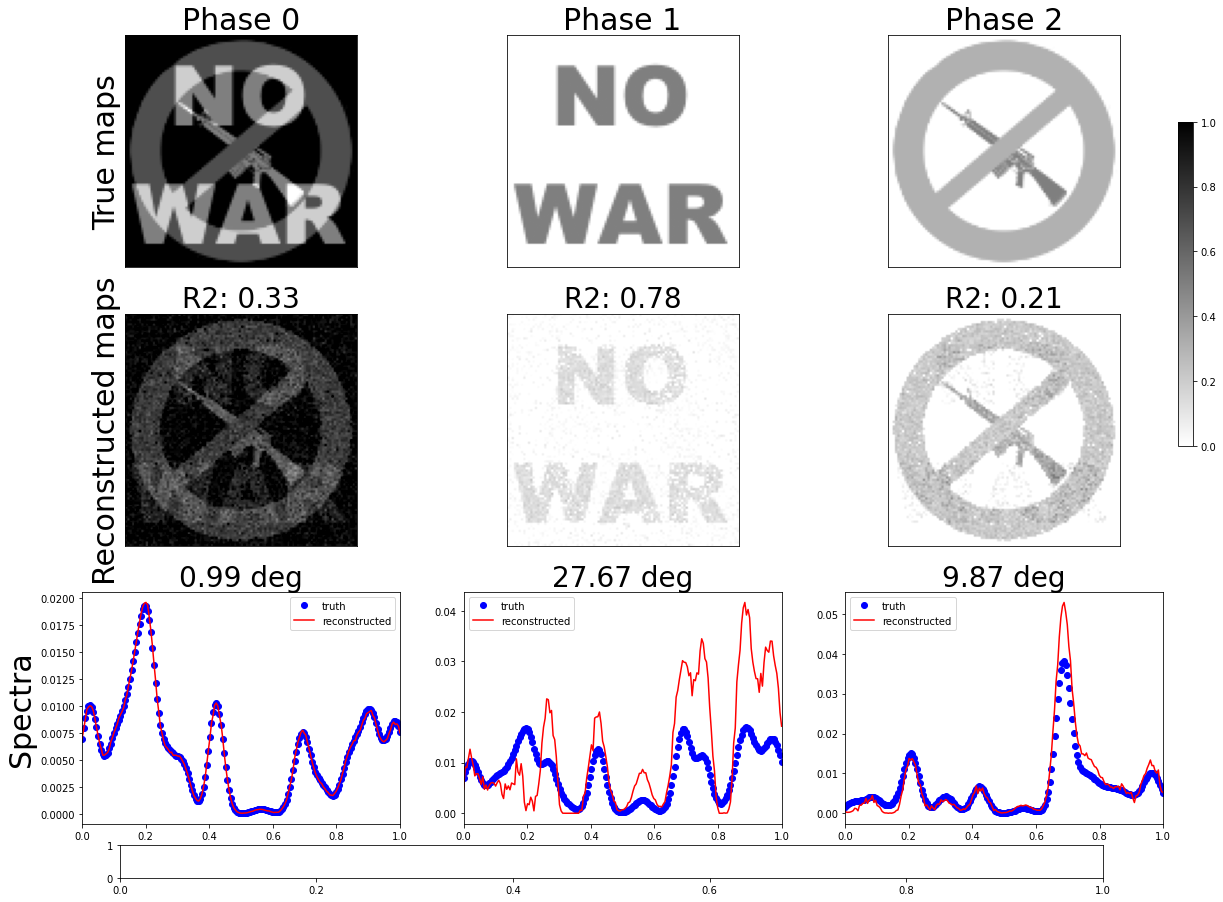

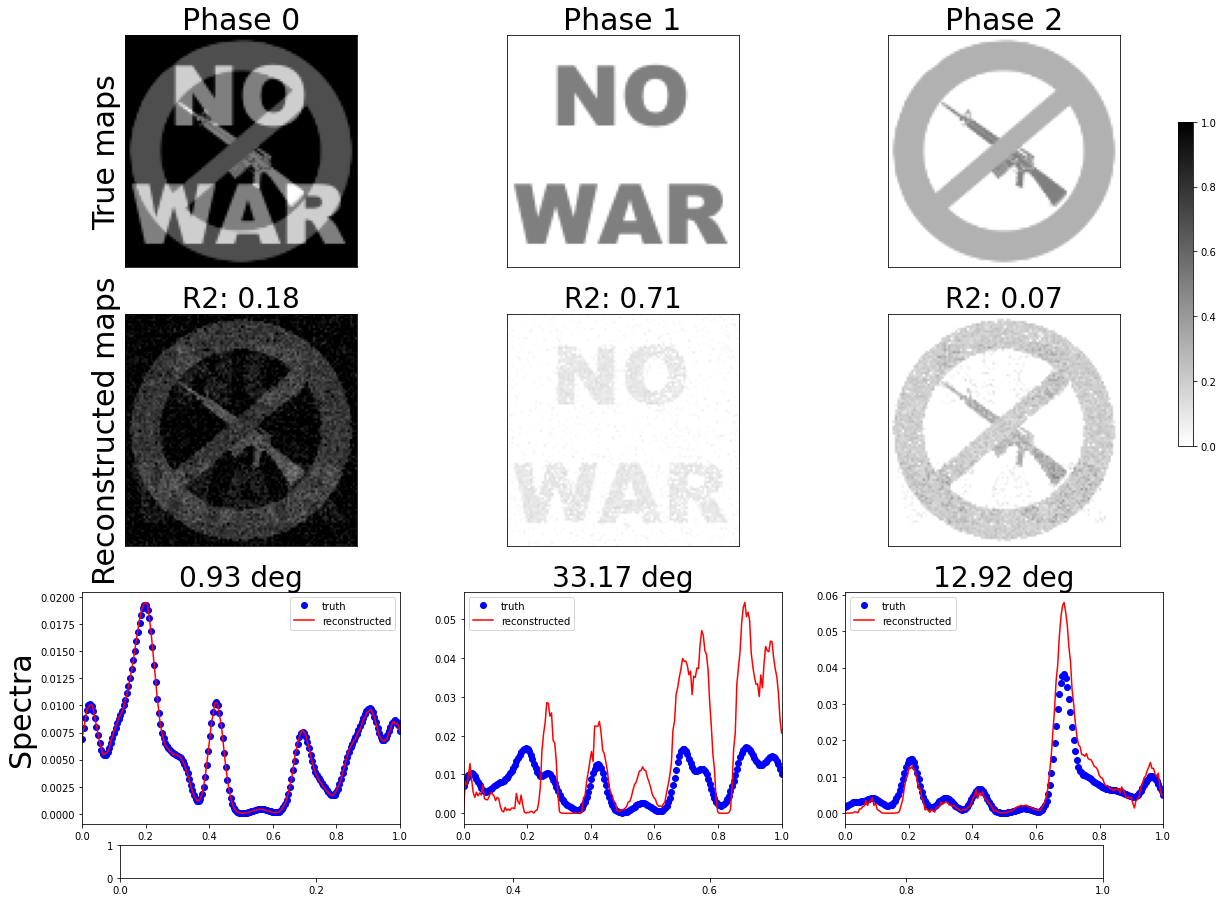

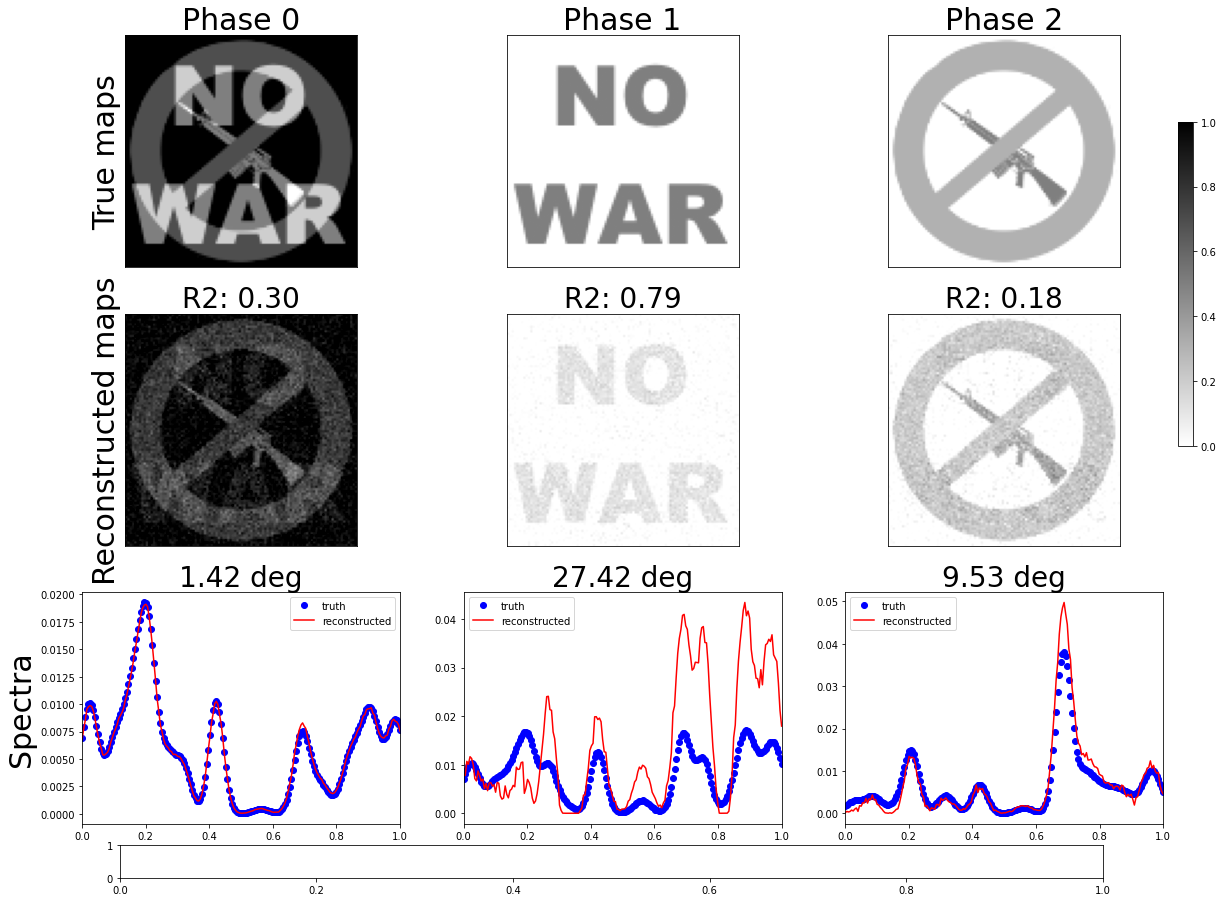

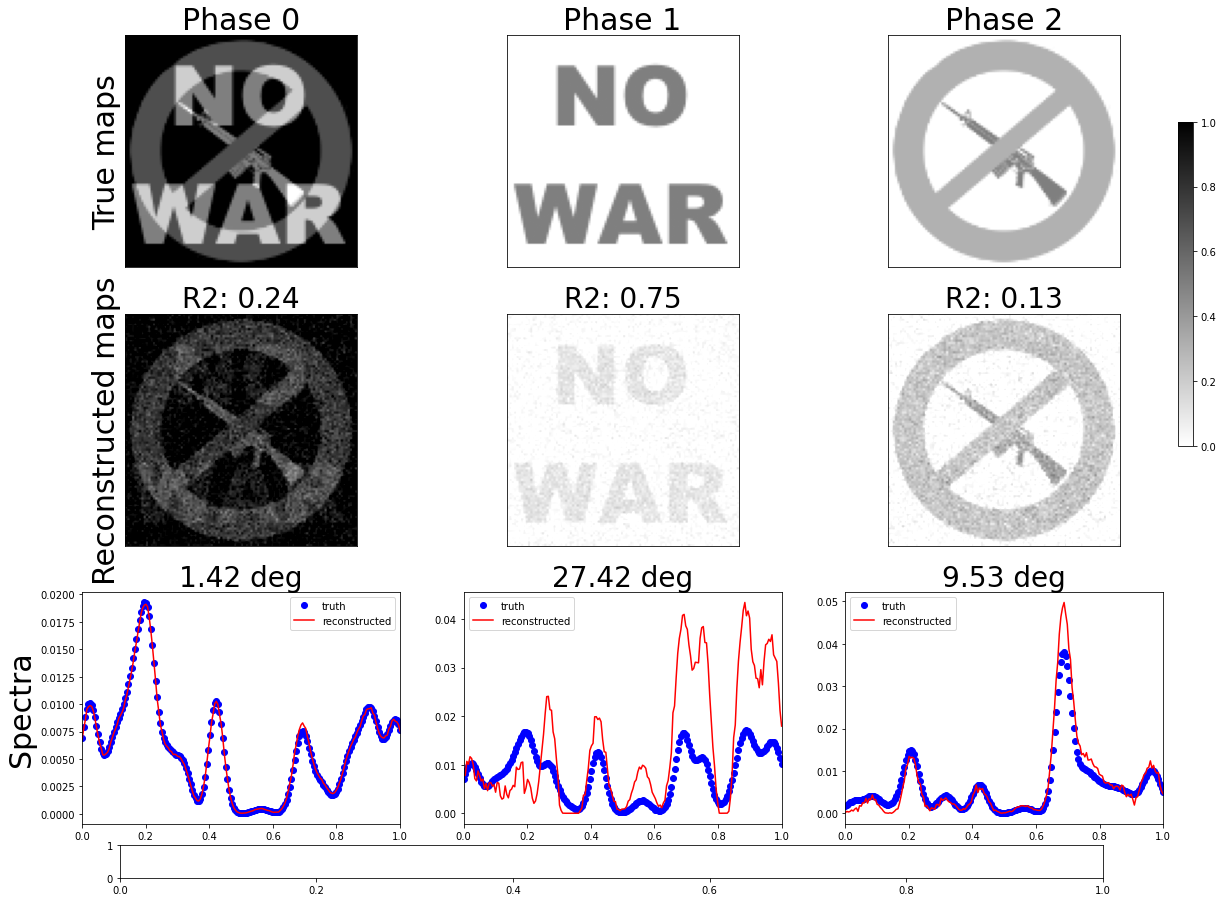

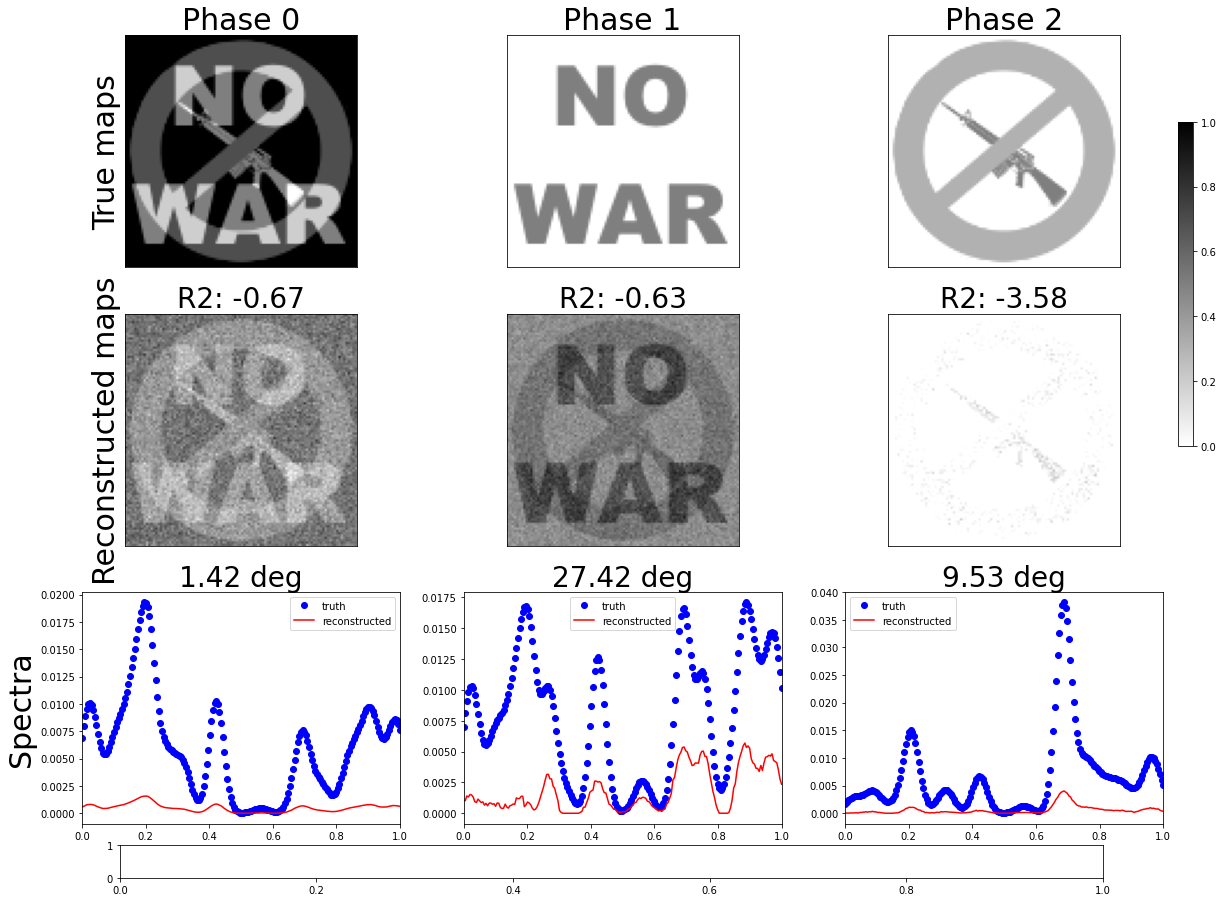

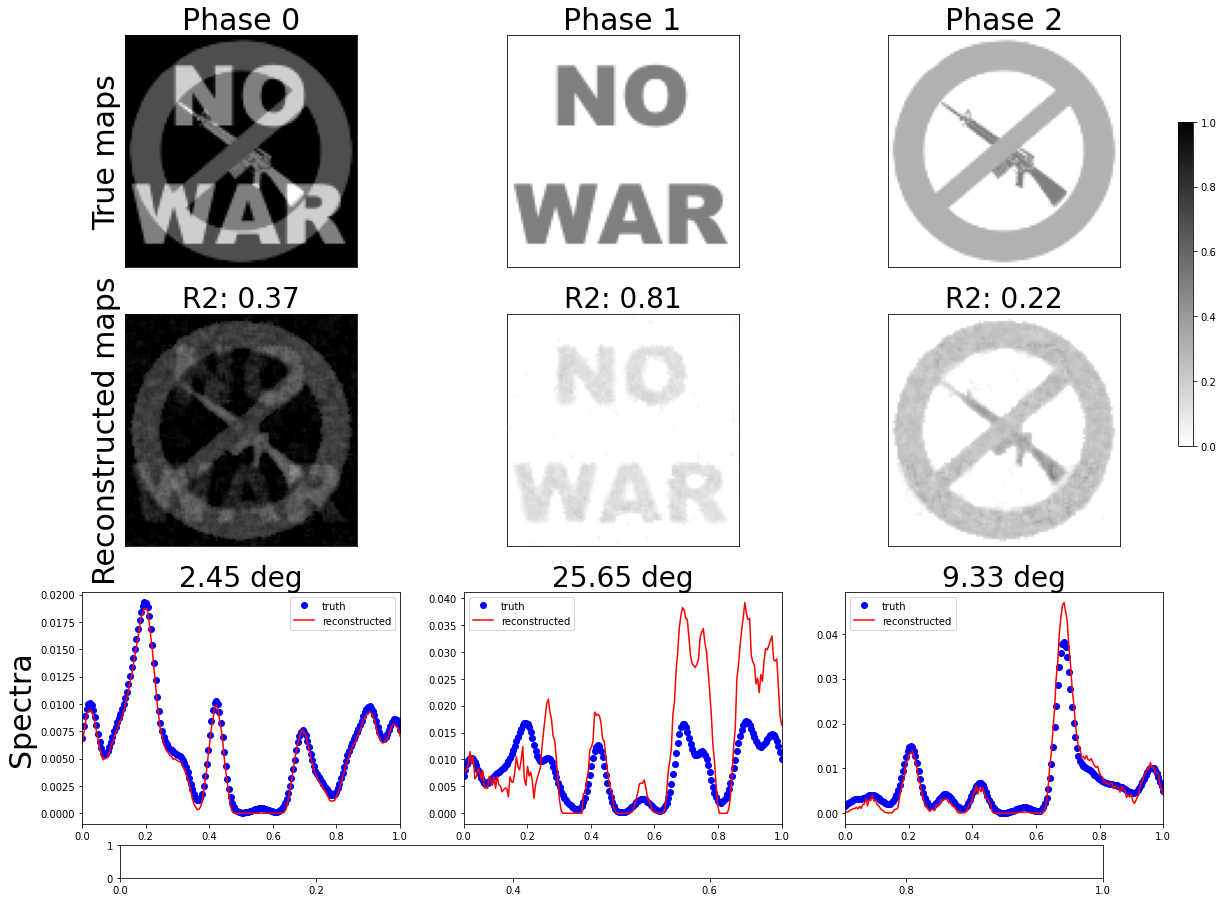

In [26]:
angle_max_exp = []
r2_max_exp = []
kl_max_exp = []
times_exp = []
import time
from scipy import ndimage

pixels_side = 100
Ximg = Y.reshape((-1, pixels_side,pixels_side))
num_iterations = 100




# Baseline
downsampling_factors = [1]
Hflat =None
W = None

for i in range(len(downsampling_factors)):
    start_time = time.time()
    n = downsampling_factors[i]
    X = downsample(Ximg,n)
    Xflat = X.reshape((X.shape[0], -1))
    est = SmoothNMF( n_components = 3,tol=0.0001, max_iter = num_iterations, G = None, lambda_L=0, mu=0, force_simplex=False)
    D , Hs, Ws, G, losses = est.fit_transform(Xflat, W=W, H=Hflat, update_W=True)
    Hflat = est.H_
    W = est.W_

    times_exp.append(time.time()-start_time)

    angle, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
    r2 = ordered_r2(Hdotflat, Hflat, true_inds)

    angle_max_exp.append(sum(angle)/len(angle))
    r2_max_exp.append(sum(r2)/len(r2))
    kl_max_exp.append(ordered_kl(Hdotflat, Hflat, true_inds))

    plot_results(Ddot, D, Hdotflat, Hflat, pixels_side//n, Hs, Ws, G, losses)

downsampling_factors = [1]
Hflat =None
W = None

# Baseline with regularization
for i in range(len(downsampling_factors)):
    start_time = time.time()
    n = downsampling_factors[i]
    X = downsample(Ximg,n)
    Xflat = X.reshape((X.shape[0], -1))
    est = SmoothNMF( n_components = 3,tol=0.0001, max_iter = num_iterations, G = None, lambda_L=10, mu=10, force_simplex=False)
    D , Hs, Ws, G, losses = est.fit_transform(Xflat, W=W, H=Hflat, update_W=True)
    Hflat = est.H_
    W = est.W_

    # Wdot = spim.phases
    Hdotflat_down = downsample_flat(Hdotflat, n, pixels_side)
    times_exp.append(time.time()-start_time)

    angle, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
    r2 = ordered_r2(Hdotflat_down, Hflat, true_inds)

    angle_max_exp.append(sum(angle)/len(angle))
    r2_max_exp.append(sum(r2)/len(r2))
    kl_max_exp.append(ordered_kl(Hdotflat, Hflat, true_inds))

    plot_results(Ddot, D, Hdotflat_down, Hflat, pixels_side//n, Hs, Ws, G, losses)



# Downsample 
downsampling_factors = [4,1]
Hflat =None
W = None

for i in range(len(downsampling_factors)):
    start_time = time.time()
    n = downsampling_factors[i]
    X = downsample(Ximg,n)
    Xflat = X.reshape((X.shape[0], -1))
    if (i > 0):
        factor = downsampling_factors[i-1]//downsampling_factors[i]
        H = Hflat.reshape((-1, pixels_side//n//factor, pixels_side//n//factor))
        H = H.repeat(factor, axis = 1).repeat(factor, axis = 2)
        Hflat = H.reshape((-1, pixels_side*pixels_side//n//n)) +0.001
        W =  W 

    
    est = SmoothNMF( n_components = 3,tol=0.0001, max_iter = num_iterations, G = None, lambda_L=0, mu=0, force_simplex=False)

    if i > 0:
        D , Hs, Ws, G, losses = est.fit_transform(Xflat, W=W, H=Hflat, update_W=False)

    else:
        D , Hs, Ws, G, losses = est.fit_transform(Xflat, W=W, H=Hflat, update_W=True)


    Hflat = est.H_
    W = est.W_

    if (i == 0):
        intermediateW = W.copy()
        intermediateTime = time.time()-start_time

    # Wdot = spim.phases
    Hdotflat_down = downsample_flat(Hdotflat, n, pixels_side)
times_exp.append(time.time()-start_time)

angle, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
r2 = ordered_r2(Hdotflat_down, Hflat, true_inds)

angle_max_exp.append(sum(angle)/len(angle))
r2_max_exp.append(sum(r2)/len(r2))
kl_max_exp.append(ordered_kl(Hdotflat, Hflat, true_inds))


plot_results(Ddot, D, Hdotflat_down, Hflat, pixels_side//n, Hs, Ws, G, losses)


start_time = time.time()
# Downsample with regularization
Hflat = np.linalg.pinv(intermediateW)@Xflat
Hdotflat_down = downsample_flat(Hdotflat, n, pixels_side)
times_exp.append(time.time()-start_time + intermediateTime)

angle, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
r2 = ordered_r2(Hdotflat_down, Hflat, true_inds)

angle_max_exp.append(sum(angle)/len(angle))
r2_max_exp.append(sum(r2)/len(r2))
kl_max_exp.append(ordered_kl(Hdotflat, Hflat, true_inds))
plot_results(Ddot, D, Hdotflat_down, Hflat, pixels_side//n, Hs, Ws, G, losses)

downsampling_factors = [1]
W = intermediateW
Hflat = None
# Downsampling with regularization
for i in range(len(downsampling_factors)):
    start_time = time.time()
    n = downsampling_factors[i]
    X = downsample(Ximg,n)
    Xflat = X.reshape((X.shape[0], -1))
    est = SmoothNMF( n_components = 3,tol=0.0001, max_iter = num_iterations, G = None, lambda_L=10, mu=10, force_simplex=False)
    D , Hs, Ws, G, losses = est.fit_transform(Xflat, W=W , H=Hflat, update_W=False)
    Hflat = est.H_
    W = est.W_

    # Wdot = spim.phases
    Hdotflat_down = downsample_flat(Hdotflat, n, pixels_side)
    times_exp.append(time.time()-start_time)

    angle, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
    r2 = ordered_r2(Hdotflat_down, Hflat, true_inds)

    angle_max_exp.append(sum(angle)/len(angle))
    r2_max_exp.append(sum(r2)/len(r2))
    kl_max_exp.append(ordered_kl(Hdotflat, Hflat, true_inds))

    plot_results(Ddot, D, Hdotflat_down, Hflat, pixels_side//n, Hs, Ws, G, losses)


downsampling_factors = [1]
Hflat =None
W = None

# Median Filter
for i in range(len(downsampling_factors)):
    start_time = time.time()
    n = downsampling_factors[i]
    X = downsample(Ximg,n)
    X = ndimage.median_filter(X, size=(1,3,3))
    Xflat = X.reshape((X.shape[0], -1))
    est = SmoothNMF( n_components = 3,tol=0.0001, max_iter = num_iterations, G = None, lambda_L=0, mu=0, force_simplex=False)
    D , Hs, Ws, G, losses = est.fit_transform(Xflat, W=W, H=Hflat, update_W=True)
    Hflat = est.H_
    W = est.W_

    # Wdot = spim.phases
    Hdotflat_down = downsample_flat(Hdotflat, n, pixels_side)
    times_exp.append(time.time()-start_time)

    angle, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
    r2 = ordered_r2(Hdotflat_down, Hflat, true_inds)

    angle_max_exp.append(sum(angle)/len(angle))
    r2_max_exp.append(sum(r2)/len(r2))
    kl_max_exp.append(ordered_kl(Hdotflat, Hflat, true_inds))

    plot_results(Ddot, D, Hdotflat_down, Hflat, pixels_side//n, Hs, Ws, G, losses)



# plt.scatter(r2_max_exp, angle_max_exp)
# plt.title("Avg R2 and Angle error (all experiments)")
# plt.xlabel("Avg R2 error [-]")
# plt.ylabel("Avg angle error [deg]")
# plt.xlim(1, min(r2_max_exp))  
# plt.ylim(0, max(angle_max_exp)) 

# annotations = ['baseline', 'regulatization ($\lambda$ = 10, $\mu$ = 10)', 'smoothing median filter of size (1,10,10)', 'downsampling (16->8->4->2->1)', 'Intermediate smoothing']

# # Add annotations to each data point
# for i in range(len(r2_max_exp)):
#     plt.annotate(annotations[i], xy=(r2_max_exp[i], angle_max_exp[i]), ha='center')


# plt.grid()
# plt.show()




[8.85182809829712, 8.96083116531372, 13.431919813156128, 4.97885799407959, 0.9459829330444336, 10.13037371635437, 8.68415379524231]


ValueError: x and y must have same first dimension, but have shapes (1,) and (6,)

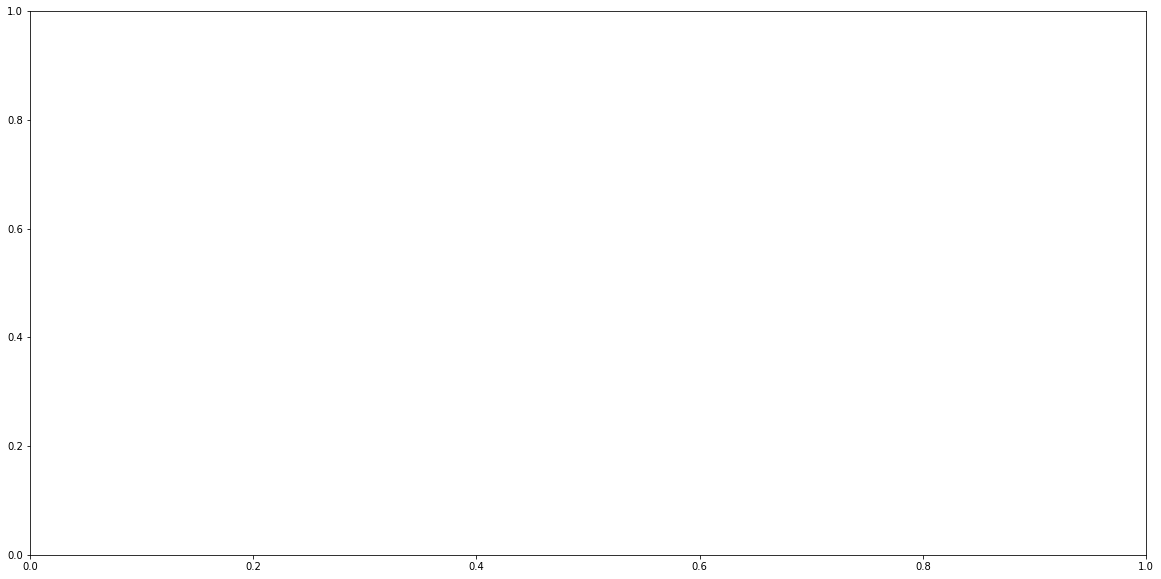

In [19]:
print(times_exp)
fig = plt.figure(figsize = (20,10))

plt.plot(dfs, [times_exp[i]/1000 for i in range(6)])
plt.plot(dfs, [times_exp[5]/1000*(dfs[5]/dfs[i])*(dfs[5]/dfs[i]) for i in range(6)])
plt.plot(dfs, [times_exp[5]/1000*(dfs[5]/dfs[i]) for i in range(6)])

# plt.xlim(max(dfs), 0)  # decreasing time
plt.xticks(dfs)
plt.title('Computation time/iteration vs downsampling factor')
plt.ylabel('Avg. time/iteration [s]')
plt.xlabel('Downsampling factor [-]')

plt.yscale('log',base=10) 
plt.legend(['Obtained', 'Quadratic Relation', 'Linear Relation'])
plt.grid()
plt.show()

[4.436645030975342, 6.7286460399627686, 2.532628059387207, 0.5054931640625, 5.003535985946655, 4.5930280685424805]


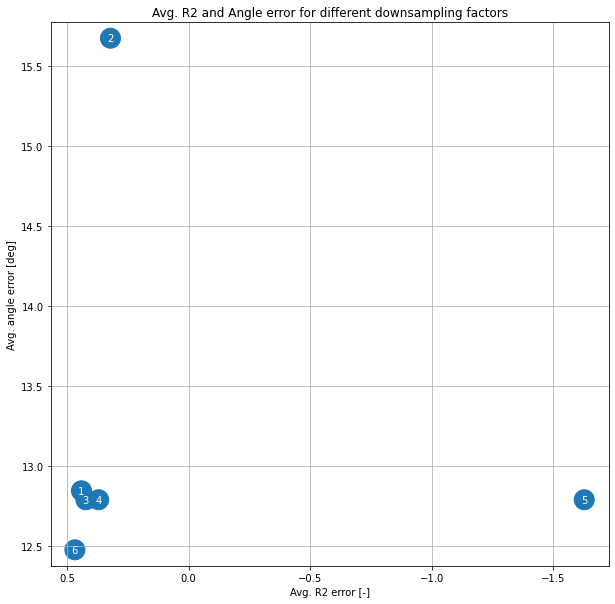

[4.436645030975342, 6.7286460399627686, 2.532628059387207, 0.5054931640625, 5.003535985946655, 4.5930280685424805]


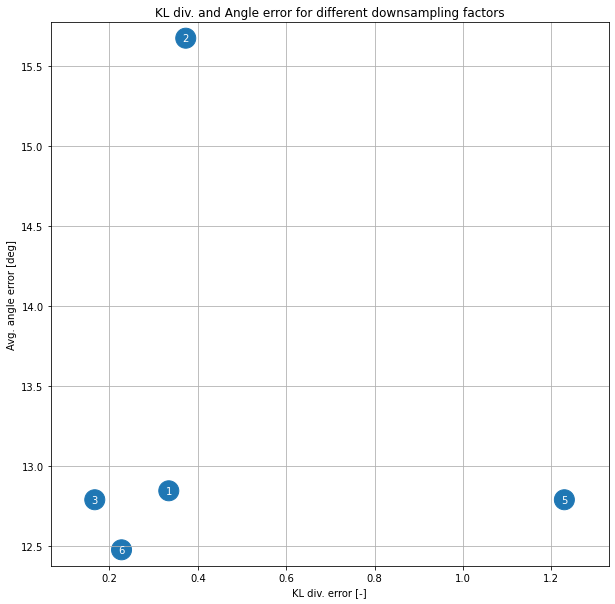

300
[0.3344562562237691, 0.3728307080104906, 0.16701428116474312, nan, 1.2294502021686369, 0.22755074310018417]
[0.3344562562237691, 0.3728307080104906, 0.16701428116474312, nan, 1.2294502021686369, 0.22755074310018417]


In [27]:

fig = plt.figure(figsize = (10,10))

plt.scatter(r2_max_exp, angle_max_exp, [400 for i in range(len(times_exp))])
plt.title("Avg. R2 and Angle error for different downsampling factors")
plt.xlabel("Avg. R2 error [-]")
plt.ylabel("Avg. angle error [deg]")
plt.xlim(max(r2_max_exp)+0.1, min(r2_max_exp)-0.1)  
plt.ylim(min(angle_max_exp)-0.1, max(angle_max_exp)+0.1) 

annotations = ['1','2','3','4','5','6','7','8']

# Add annotations to each data point
for i in range(len(r2_max_exp)):
    plt.annotate(annotations[i], xy=(r2_max_exp[i], angle_max_exp[i]), va='center',ha='center', color='white')

print(times_exp)
plt.grid()
plt.show()


fig = plt.figure(figsize = (10,10))


plt.scatter(kl_max_exp, angle_max_exp, [400 for i in range(len(times_exp))])
plt.title("KL div. and Angle error for different downsampling factors")
plt.xlabel("KL div. error [-]")
plt.ylabel("Avg. angle error [deg]")
plt.xlim(min(kl_max_exp)-0.1, max(kl_max_exp)+0.1)  
plt.ylim(min(angle_max_exp)-0.1, max(angle_max_exp)+0.1) 

annotations = ['1','2','3','4','5','6','7','8']

# Add annotations to each data point
for i in range(len(r2_max_exp)):
    plt.annotate(annotations[i], xy=(kl_max_exp[i], angle_max_exp[i]), va='center',ha='center', color='white')

print(times_exp)
plt.grid()
plt.show()
print(n_poisson)
print(kl_max_exp)
print(kl_max_exp)


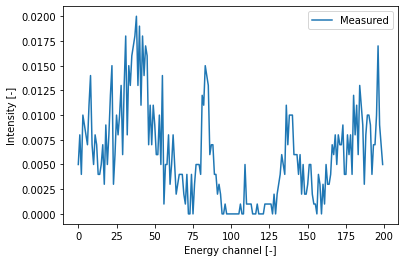

In [212]:
angle_max_exp = []
r2_max_exp = []
times_exp = []

pixels_side = 100
Ximg = Y.reshape((-1, pixels_side,pixels_side))
num_iterations = 200


X = downsample(Ximg,1)
# Xdot_ = downsample(XimgDot, 10)
plt.plot(X[:,0,0])
# plt.plot(Xdot_[:,0,0])
plt.xlabel('Energy channel [-]')
plt.ylabel('Intensity [-]')
plt.legend(['Measured', 'Ground Truth'])
# plt.savefig("../results/df10_spectral.png",bbox_inches='tight')
plt.show()

3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  11.685 it/s
It 20 / 100: loss 0.002,  13.051 it/s
exits because of relative change < tol: 0.00010274829618930273
exits because of relative change < tol: 9.689283455517722e-05
It 30 / 100: loss 0.002,  13.621 it/s
exits because of relative change < tol: 9.137036335590842e-05
exits because of relative change < tol: 8.612528186622446e-05
exits because of relative change < tol: 8.111888950858104e-05
exits because of relative change < tol: 7.632679414687137e-05
exits because of relative change < tol: 7.173595288358805e-05
exits because of relative change < tol: 6.734152870603152e-05
exits because of relative change < tol: 6.314378317127287e-05
exits because of relative change < tol: 5.914525268537886e-05
exits because of relative change < tol: 5.5348449156686426e-05
exits because of relative change < tol: 5.1754260820707235e-05
It 40 / 100: loss 0.002,  13.895 it/s
exits because of relative change < tol: 4.836112057379109e-05
exits because of relative change < tol:

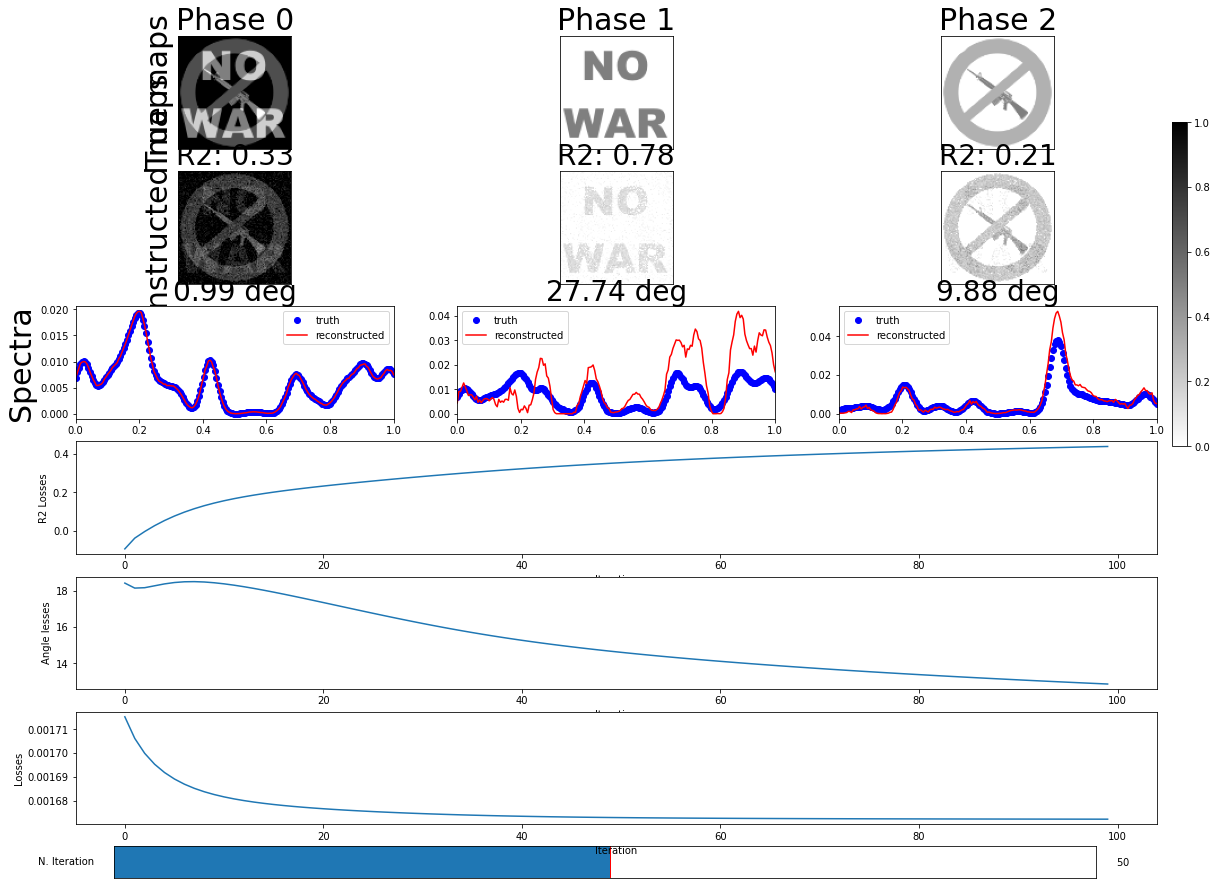

angles :  [0.9894785839635516, 9.875466230634176, 27.73801967678361]
mse :  [0.04919642668176973, 0.005249104176837972, 0.034432268887871785]
mae :  [0.1515124961674132, 0.04467414281775658, 0.09797745728133066]
r2 :  [0.33083507612400986, 0.7836962596846606, 0.20525036848040357]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  14.364 it/s
It 20 / 100: loss 0.002,  16.275 it/s
exits because of relative change < tol: 0.00010300391436271509
exits because of relative change < tol: 9.690272443827682e-05
It 30 / 100: loss 0.002,  15.859 it/s
exits because of relative change < tol: 9.113524684972248e-05
exits because of relative change < tol: 8.565860145507503e-05
exits because of relative change < tol: 8.044574327312854e-05
exits because of relative change < tol: 7.548163120411475e-05
exits because of relative change < tol: 7.075929569297984e-05
exits because of relative change < tol: 6.627620104149908e-05
exits because of relative change < tol: 6.203121742613827e-05
exits because of relative change < tol: 5.8022410647680405e-05
exits because of relative change < tol: 5.4245728082454014e-05
exits because of relative change < tol: 5.069453147236253e-05
It 40 / 100: loss 0.002,  15.578 it/s
exits because of relative change < tol: 4.7359819521948253e-05
exits because of relative change < tol

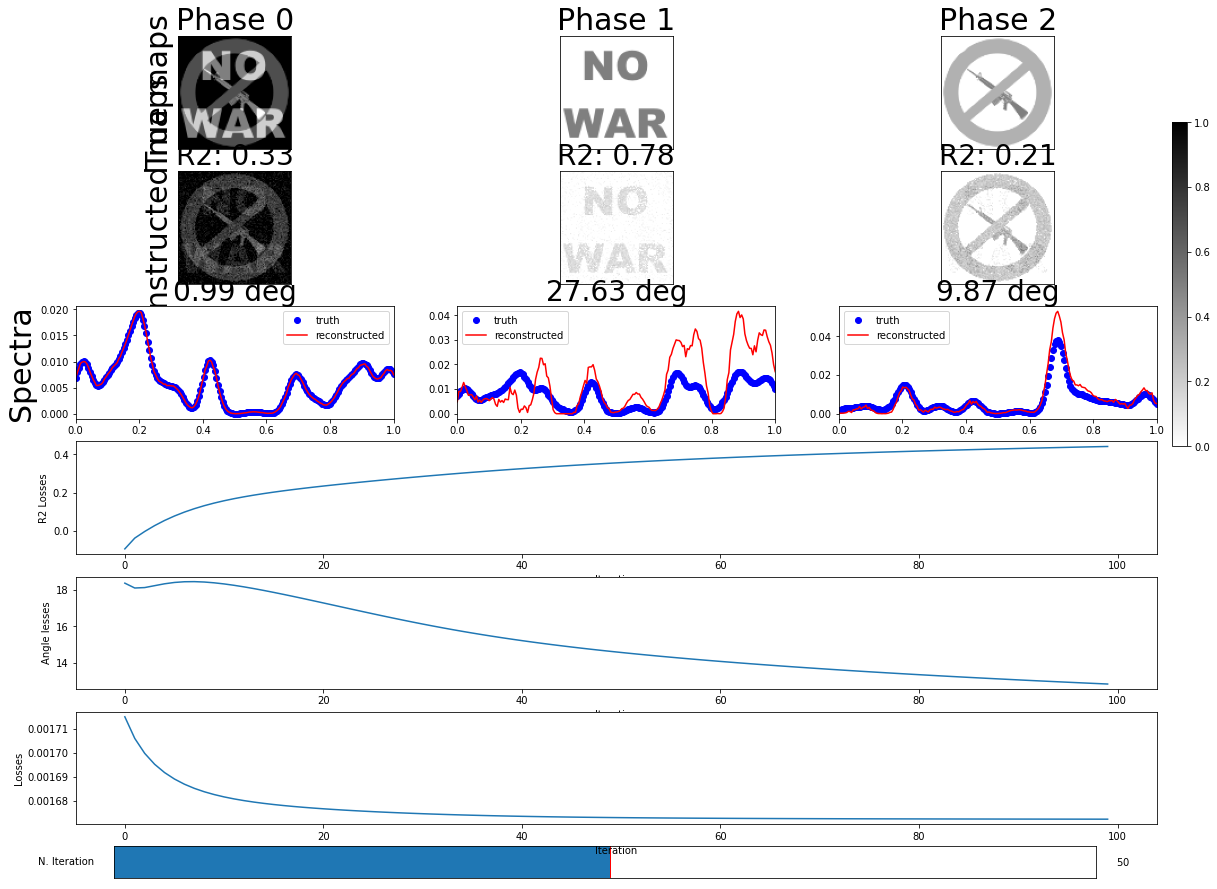

angles :  [0.9946812243314666, 9.867407058709015, 27.63486709234736]
mse :  [0.04903852166033074, 0.005240407230139626, 0.0343192258204974]
mae :  [0.15137709930759877, 0.044628147363182206, 0.09784968100480694]
r2 :  [0.332982884588522, 0.7840546412364073, 0.2078595760360894]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  14.264 it/s
It 20 / 100: loss 0.002,  14.647 it/s
exits because of relative change < tol: 0.0001026986356142746
exits because of relative change < tol: 9.693835188049349e-05
It 30 / 100: loss 0.002,  14.797 it/s
exits because of relative change < tol: 9.151616334283943e-05
exits because of relative change < tol: 8.637486195326688e-05
exits because of relative change < tol: 8.14720461449371e-05
exits because of relative change < tol: 7.677818377995709e-05
exits because of relative change < tol: 7.227457834081479e-05
exits because of relative change < tol: 6.795119620055682e-05
exits because of relative change < tol: 6.380437061408894e-05
exits because of relative change < tol: 5.9834493510253574e-05
exits because of relative change < tol: 5.604388549185101e-05
exits because of relative change < tol: 5.243505239852453e-05
It 40 / 100: loss 0.002,  15.527 it/s
exits because of relative change < tol: 4.9009483080281904e-05
exits because of relative change < tol: 4

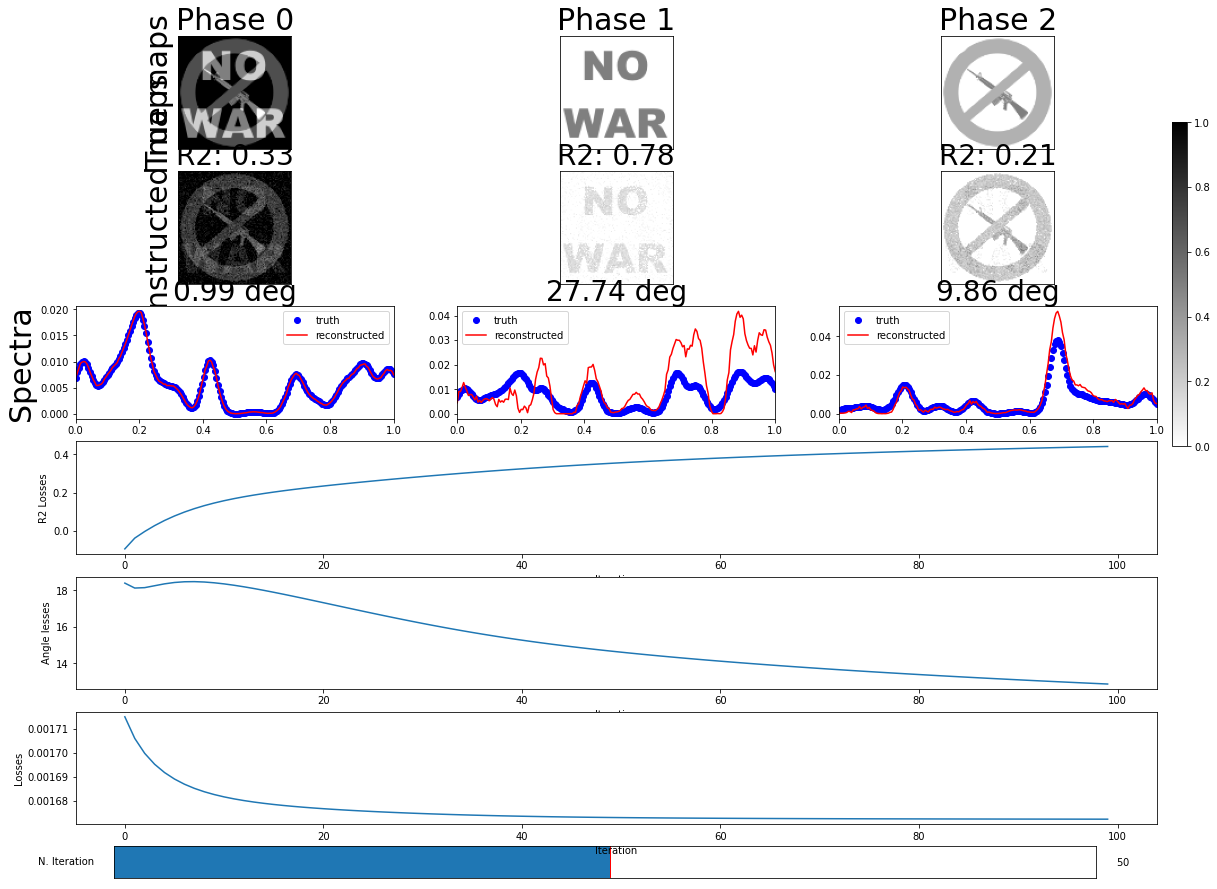

angles :  [0.989794893065603, 9.861818078974371, 27.735506943067705]
mse :  [0.04916172654803549, 0.005233643919916393, 0.034399349058401724]
mae :  [0.15156126893268987, 0.04459144647859986, 0.09793723556600337]
r2 :  [0.33130706390676, 0.7843333419916055, 0.2060102086880362]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  14.232 it/s
It 20 / 100: loss 0.002,  14.633 it/s
exits because of relative change < tol: 0.00010854275251198447
exits because of relative change < tol: 0.00010215912184221196
exits because of relative change < tol: 9.620179929154107e-05
It 30 / 100: loss 0.002,  14.558 it/s
exits because of relative change < tol: 9.060039788018955e-05
exits because of relative change < tol: 8.530062650578132e-05
exits because of relative change < tol: 8.026266494492175e-05
exits because of relative change < tol: 7.545926224373784e-05
exits because of relative change < tol: 7.087353812323643e-05
exits because of relative change < tol: 6.649652832534535e-05
exits because of relative change < tol: 6.2324610466484e-05
exits because of relative change < tol: 5.8357032739341685e-05
exits because of relative change < tol: 5.45937959663045e-05
exits because of relative change < tol: 5.103409857466506e-05
It 40 / 100: loss 0.002,  14.583 it/s
exits because of relative change < tol: 4.

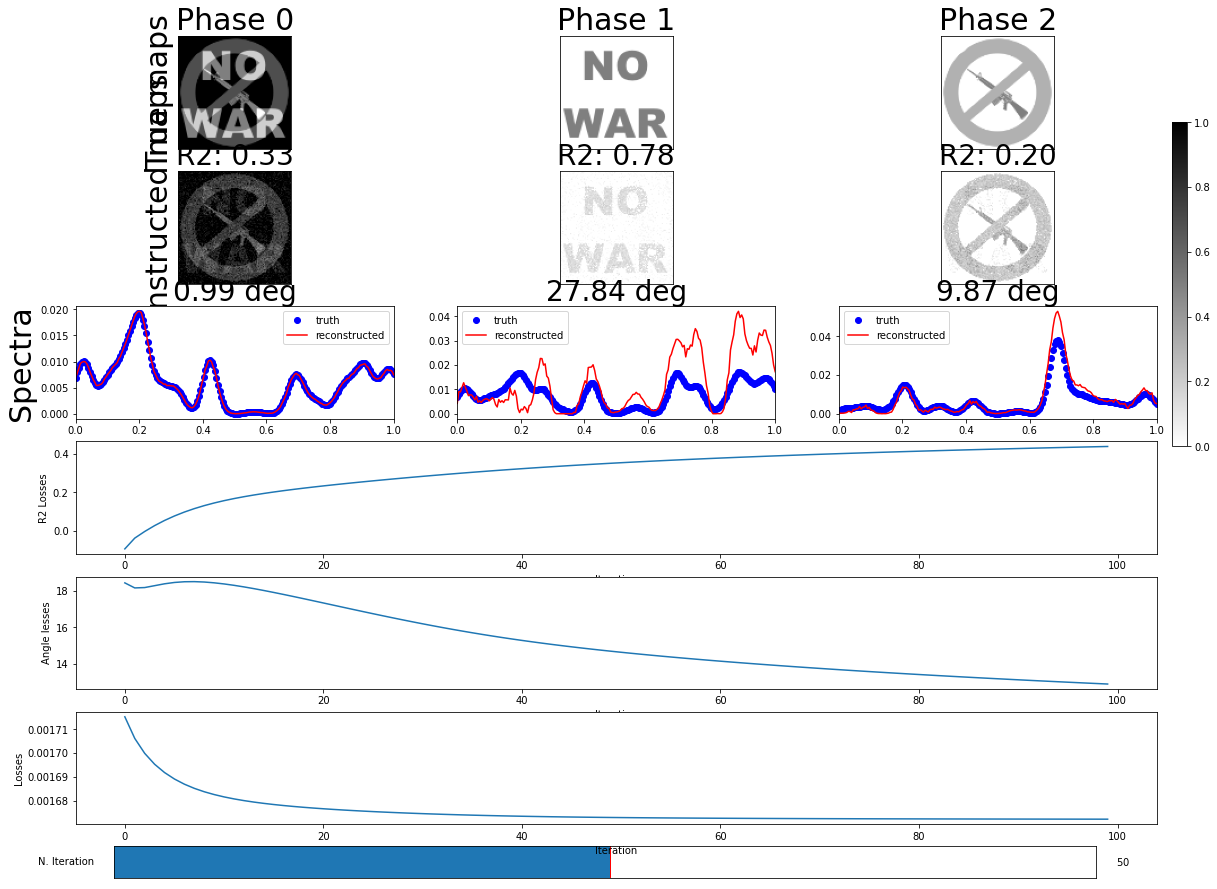

angles :  [0.9853264749632445, 9.866562062547445, 27.842333858769962]
mse :  [0.0493110303904338, 0.005236153532704513, 0.034536712092773834]
mae :  [0.15168029859957016, 0.04459148262635555, 0.09809513441098704]
r2 :  [0.3292762478277971, 0.7842299265106919, 0.20283965895437917]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  13.347 it/s
It 20 / 100: loss 0.002,  14.111 it/s
exits because of relative change < tol: 0.00010756942693663245
exits because of relative change < tol: 0.00010149914827164186
exits because of relative change < tol: 9.587502545428697e-05
It 30 / 100: loss 0.002,  14.428 it/s
exits because of relative change < tol: 9.06152433765992e-05
exits because of relative change < tol: 8.565369634265096e-05
exits because of relative change < tol: 8.093869567804982e-05
exits because of relative change < tol: 7.643160738701304e-05
exits because of relative change < tol: 7.210542159680532e-05
exits because of relative change < tol: 6.794317912887682e-05
exits because of relative change < tol: 6.39361796683162e-05
exits because of relative change < tol: 6.008197426846505e-05
exits because of relative change < tol: 5.6382250360744014e-05
exits because of relative change < tol: 5.28408046967969e-05
It 40 / 100: loss 0.002,  14.462 it/s
exits because of relative change < tol: 4.

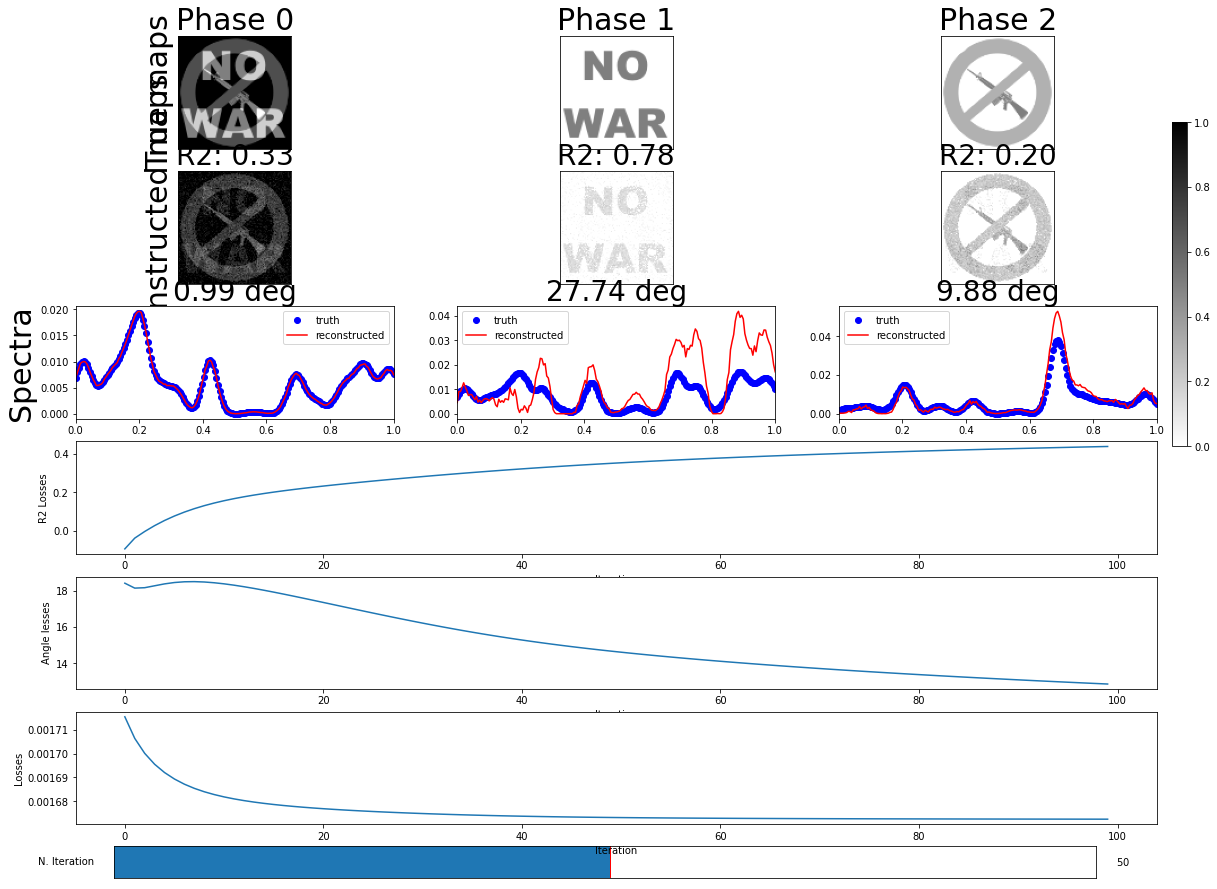

angles :  [0.988735542010114, 9.879055347334234, 27.74065712368913]
mse :  [0.049196179193246974, 0.005248911153342503, 0.034443183017874426]
mae :  [0.1515685238314411, 0.04465407155652925, 0.0979843482481237]
r2 :  [0.3308384424383879, 0.7837042137474173, 0.20499845360293223]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  14.261 it/s
It 20 / 100: loss 0.002,  14.715 it/s
exits because of relative change < tol: 0.00010816135695734218
exits because of relative change < tol: 0.00010202954431748119
exits because of relative change < tol: 9.633927575050015e-05
It 30 / 100: loss 0.002,  14.844 it/s
exits because of relative change < tol: 9.101067552957439e-05
exits because of relative change < tol: 8.59794677253613e-05
exits because of relative change < tol: 8.119569029370464e-05
exits because of relative change < tol: 7.66222913414388e-05
exits because of relative change < tol: 7.223361831333765e-05
exits because of relative change < tol: 6.801374705887192e-05
exits because of relative change < tol: 6.395461022778622e-05
exits because of relative change < tol: 6.00539570507228e-05
exits because of relative change < tol: 5.631327314637728e-05
exits because of relative change < tol: 5.2735852783325525e-05
It 40 / 100: loss 0.002,  14.867 it/s
exits because of relative change < tol: 4.

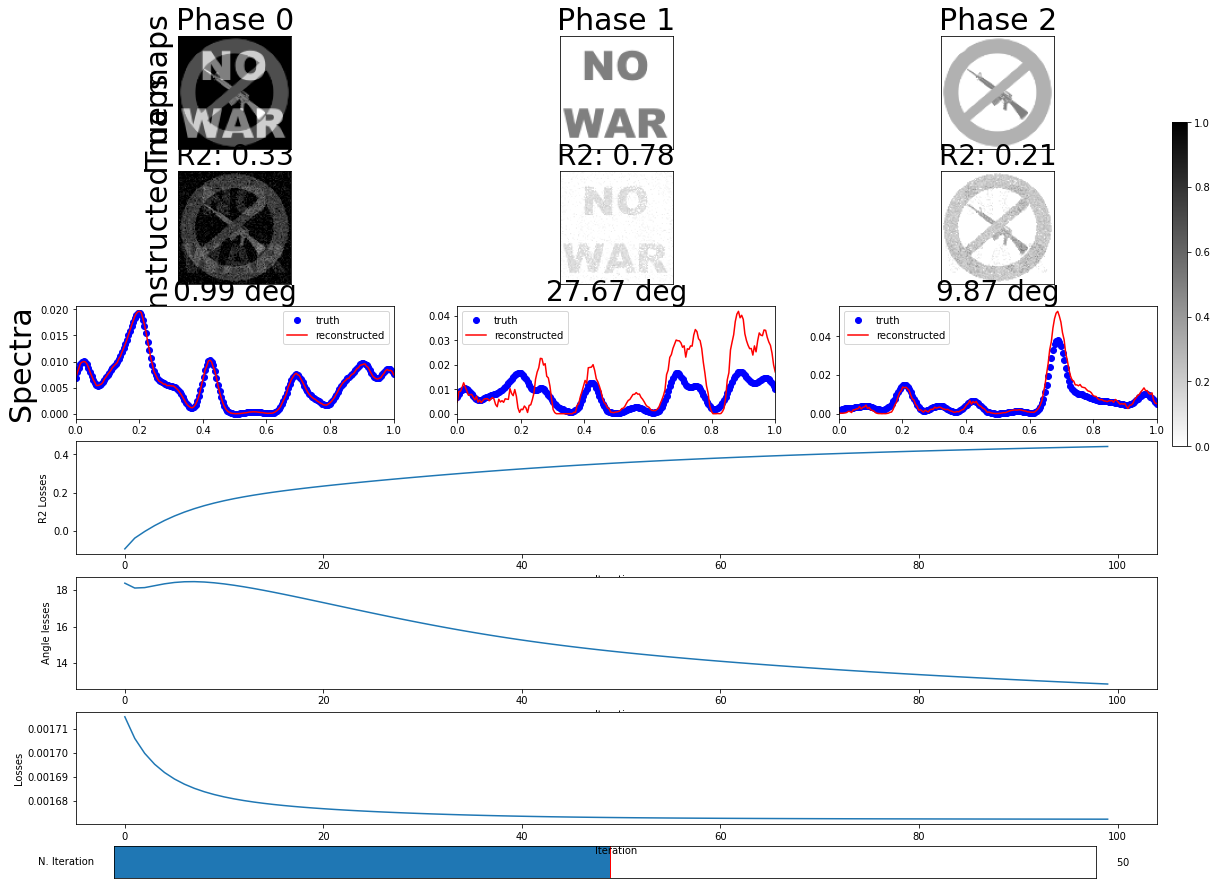

angles :  [0.9930054889850565, 9.86527968760369, 27.668795227457494]
mse :  [0.04903904084562555, 0.005237260643339785, 0.03433642205394393]
mae :  [0.15140872860830795, 0.04460272493370943, 0.09785452837675707]
r2 :  [0.33297582268155623, 0.7841843049792296, 0.20746266056590468]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  14.127 it/s
It 20 / 100: loss 0.002,  15.979 it/s
exits because of relative change < tol: 0.00010556131422341526
exits because of relative change < tol: 9.956647381038923e-05
exits because of relative change < tol: 9.409247031325157e-05
It 30 / 100: loss 0.002,  15.609 it/s
exits because of relative change < tol: 8.906272996177994e-05
exits because of relative change < tol: 8.441064639891252e-05
exits because of relative change < tol: 8.007717382701956e-05
exits because of relative change < tol: 7.600906216105145e-05
exits because of relative change < tol: 7.215799341698109e-05
exits because of relative change < tol: 6.848066151573819e-05
exits because of relative change < tol: 6.493961714940476e-05
exits because of relative change < tol: 6.150452390876133e-05
exits because of relative change < tol: 5.8153375155276795e-05
exits because of relative change < tol: 5.4873233320223556e-05
It 40 / 100: loss 0.002,  15.372 it/s
exits because of relative change < tol:

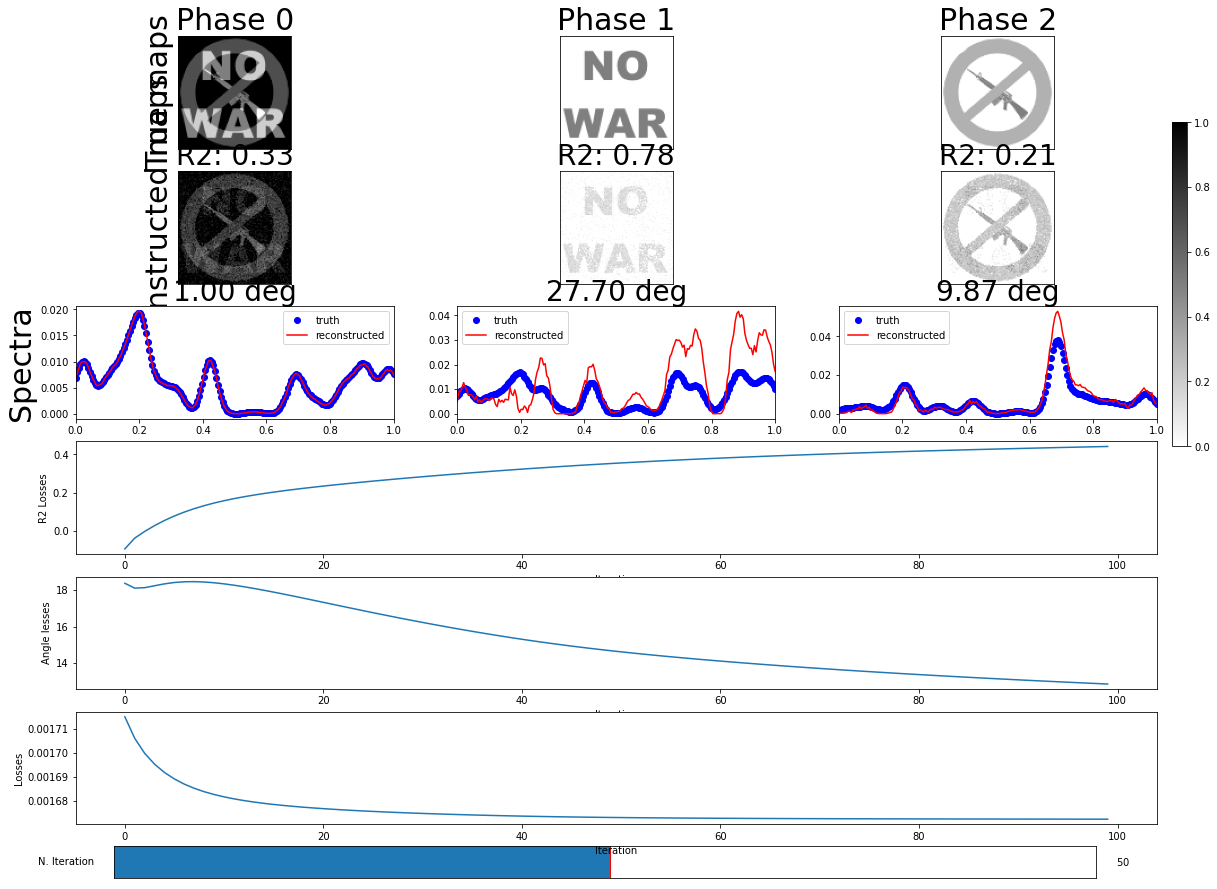

angles :  [0.997797624716334, 9.87000842735811, 27.703713380284437]
mse :  [0.04909441422446812, 0.005239387248930895, 0.03438852156686797]
mae :  [0.1514914096304153, 0.04462460535349329, 0.09793610214797961]
r2 :  [0.33222263946608344, 0.7840966723607797, 0.2062601238166255]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  14.097 it/s
It 20 / 100: loss 0.002,  14.511 it/s
exits because of relative change < tol: 0.00010332481347122924
exits because of relative change < tol: 9.728674430966456e-05
exits because of relative change < tol: 9.175432880796186e-05
It 30 / 100: loss 0.002,  12.604 it/s
exits because of relative change < tol: 8.666678746500302e-05
exits because of relative change < tol: 8.197844413823022e-05
exits because of relative change < tol: 7.765498811158932e-05
exits because of relative change < tol: 7.366949096786035e-05
exits because of relative change < tol: 6.999855089126852e-05
exits because of relative change < tol: 6.66188841959428e-05
exits because of relative change < tol: 6.350462873475124e-05
exits because of relative change < tol: 6.062557324667238e-05
exits because of relative change < tol: 5.794647628745834e-05
exits because of relative change < tol: 5.542757047330947e-05
It 40 / 100: loss 0.002,  13.650 it/s
exits because of relative change < tol: 5.

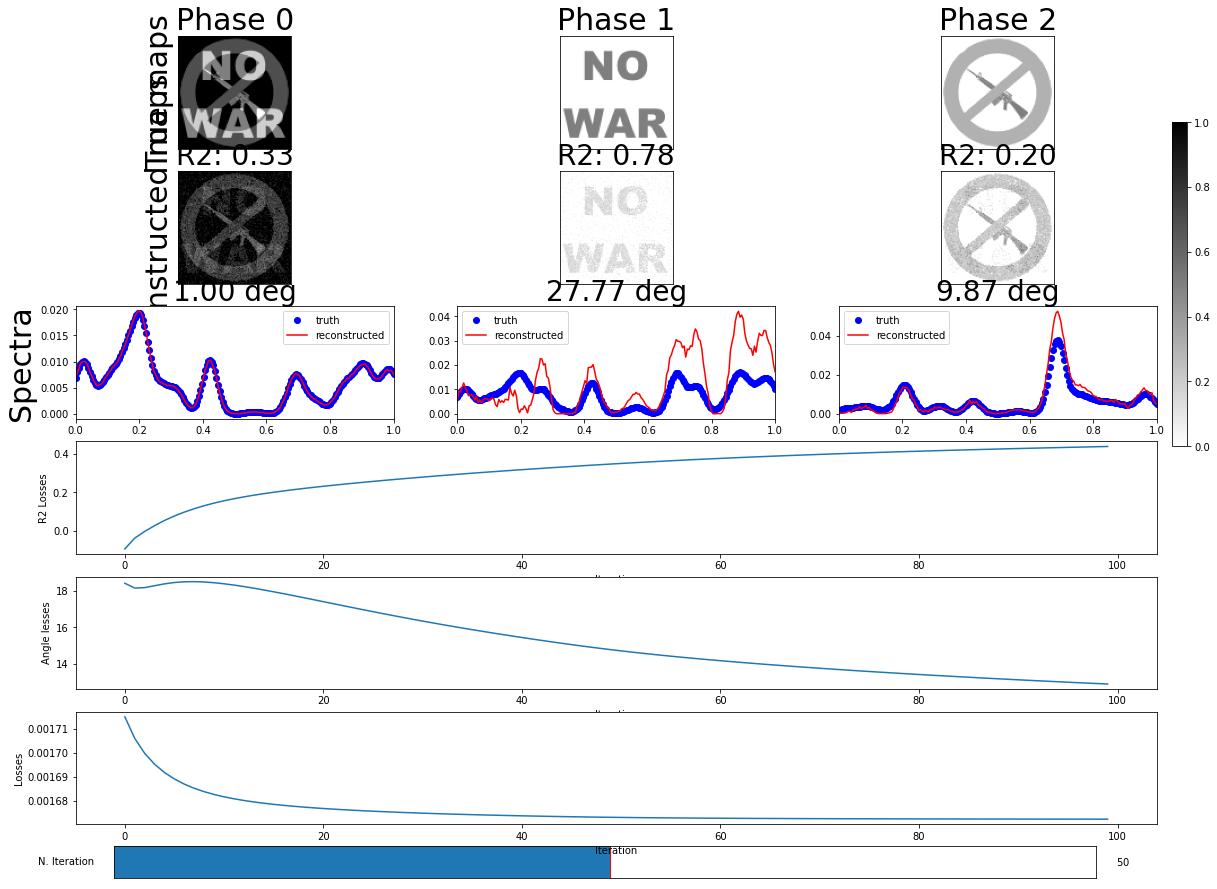

angles :  [0.9960831738596009, 9.874843946616087, 27.772243525191076]
mse :  [0.04920784559253356, 0.0052410969458556705, 0.03450910454189638]
mae :  [0.15159696112952648, 0.04464459758950952, 0.09808064312552936]
r2 :  [0.33067975723059817, 0.7840262196078573, 0.2034768836158869]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  13.571 it/s
It 20 / 100: loss 0.002,  14.142 it/s
exits because of relative change < tol: 0.00010321929573655268
exits because of relative change < tol: 9.727888756771605e-05
It 30 / 100: loss 0.002,  14.357 it/s
exits because of relative change < tol: 9.164675637137593e-05
exits because of relative change < tol: 8.627765588808468e-05
exits because of relative change < tol: 8.114401509641397e-05
exits because of relative change < tol: 7.62319082948683e-05
exits because of relative change < tol: 7.153684244927791e-05
exits because of relative change < tol: 6.705976624670283e-05
exits because of relative change < tol: 6.280363928269533e-05
exits because of relative change < tol: 5.877080312611268e-05
exits because of relative change < tol: 5.496127669866797e-05
exits because of relative change < tol: 5.137197152922455e-05
It 40 / 100: loss 0.002,  14.443 it/s
exits because of relative change < tol: 4.7996702979898637e-05
exits because of relative change < tol: 4

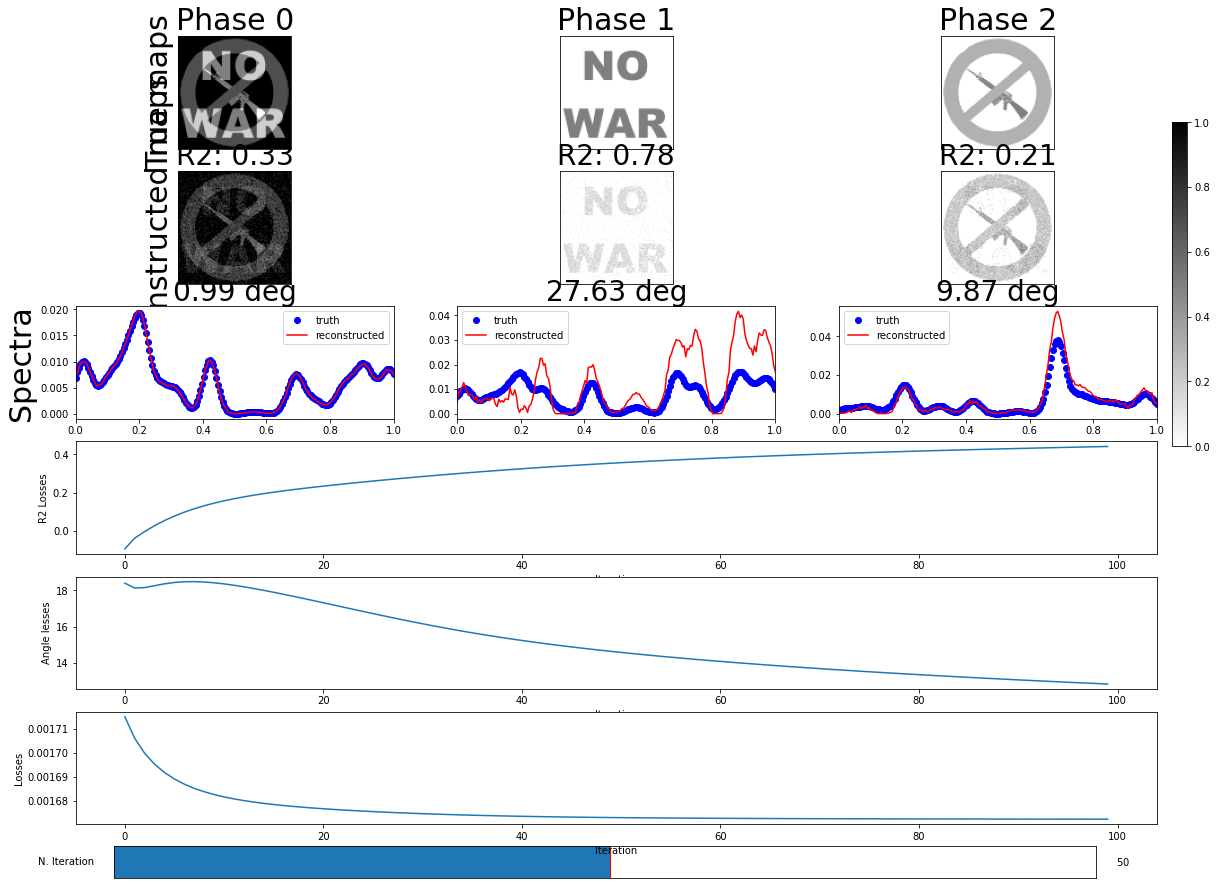

angles :  [0.9927316017069094, 9.868910580724593, 27.633865649596196]
mse :  [0.04903248116373285, 0.005240681263465926, 0.034318774111945165]
mae :  [0.15137364798096709, 0.04461760799366761, 0.0978435011534397]
r2 :  [0.3330650468250651, 0.7840433489412932, 0.20787000216300577]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  13.953 it/s
It 20 / 100: loss 0.002,  14.438 it/s
exits because of relative change < tol: 0.00010304419909925284
exits because of relative change < tol: 9.669461251307111e-05
It 30 / 100: loss 0.002,  14.572 it/s
exits because of relative change < tol: 9.070519567346837e-05
exits because of relative change < tol: 8.503918714411642e-05
exits because of relative change < tol: 7.967349798800684e-05
exits because of relative change < tol: 7.459465375388798e-05
exits because of relative change < tol: 6.979492739857845e-05
exits because of relative change < tol: 6.526902648338104e-05
exits because of relative change < tol: 6.101157320462714e-05
exits because of relative change < tol: 5.701548194191865e-05
exits because of relative change < tol: 5.32712112026895e-05
exits because of relative change < tol: 4.976676579217185e-05
It 40 / 100: loss 0.002,  14.605 it/s
exits because of relative change < tol: 4.648825411629818e-05
exits because of relative change < tol: 4.

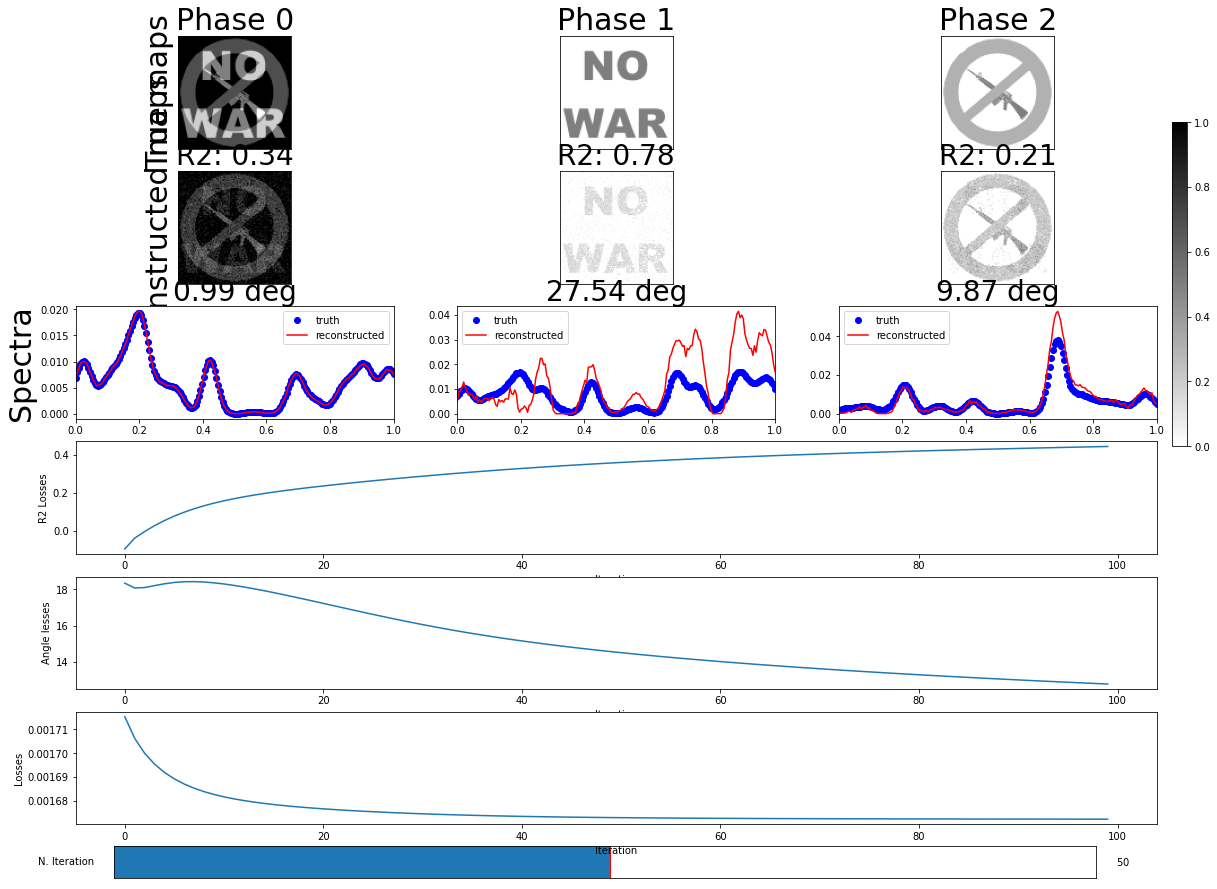

angles :  [0.9911843548742622, 9.868838044659821, 27.5386775187071]
mse :  [0.048843967062489946, 0.005233208164511656, 0.03415710673918493]
mae :  [0.15116151248207674, 0.044597085951358084, 0.09768092589676725]
r2 :  [0.3356291969618982, 0.7843512984887014, 0.21160153334232912]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  14.091 it/s
It 20 / 100: loss 0.002,  14.475 it/s
exits because of relative change < tol: 0.00010246113231638976
exits because of relative change < tol: 9.658276515831967e-05
It 30 / 100: loss 0.002,  14.466 it/s
exits because of relative change < tol: 9.103093017963248e-05
exits because of relative change < tol: 8.575396458762965e-05
exits because of relative change < tol: 8.071687073432037e-05
exits because of relative change < tol: 7.589833234417311e-05
exits because of relative change < tol: 7.128745768648185e-05
exits because of relative change < tol: 6.688049389316898e-05
exits because of relative change < tol: 6.26777548191508e-05
exits because of relative change < tol: 5.868099589129527e-05
exits because of relative change < tol: 5.489142534469066e-05
exits because of relative change < tol: 5.1308454459180944e-05
It 40 / 100: loss 0.002,  14.477 it/s
exits because of relative change < tol: 4.7929179951994964e-05
exits because of relative change < tol: 

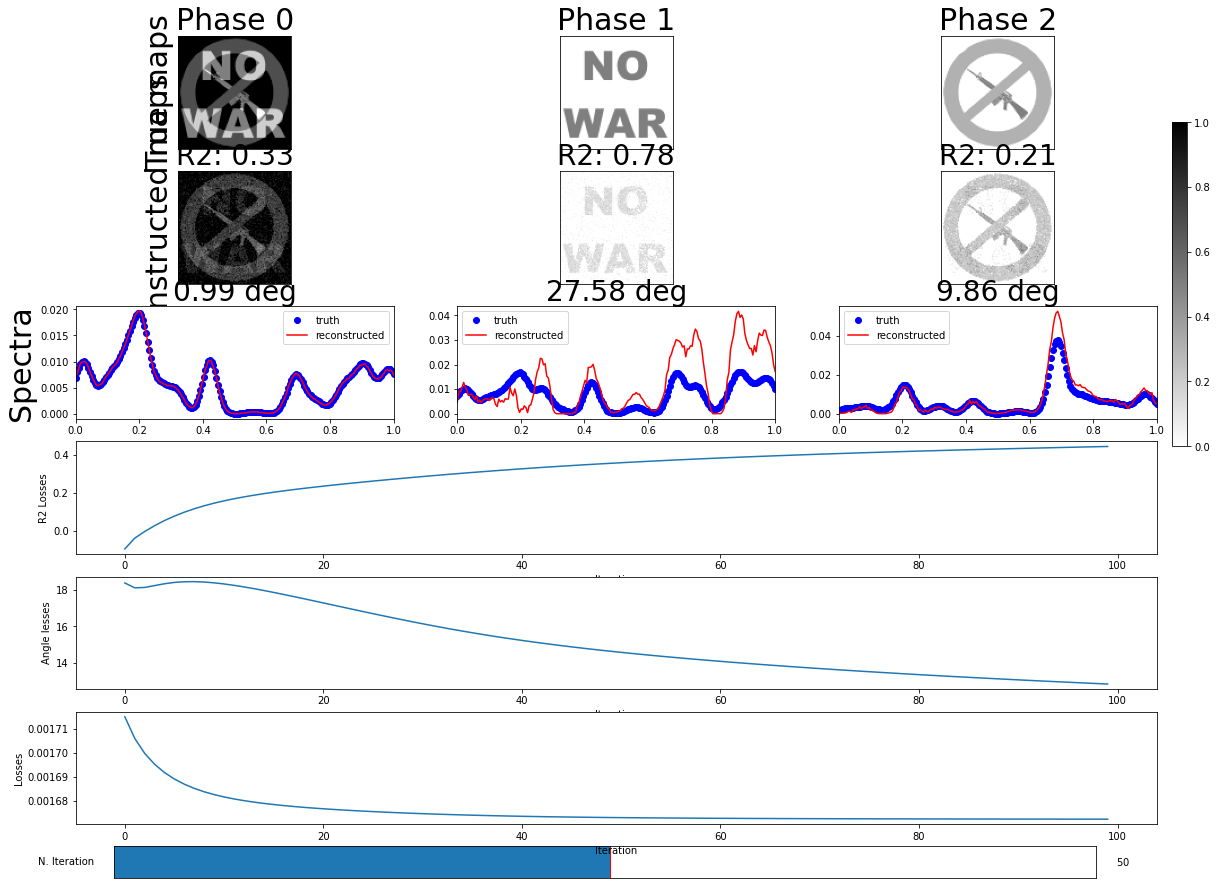

angles :  [0.9883717503289315, 9.85995188841369, 27.584156195476023]
mse :  [0.04898313318604976, 0.005231774808981197, 0.034254077523574136]
mae :  [0.15132931497289245, 0.044566775227942466, 0.09774140835781364]
r2 :  [0.3337362731306531, 0.784410363836234, 0.20936329875452264]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  13.831 it/s
It 20 / 100: loss 0.002,  15.772 it/s
exits because of relative change < tol: 0.00010789354575446838
exits because of relative change < tol: 0.00010177741070173858
exits because of relative change < tol: 9.611612577547827e-05
It 30 / 100: loss 0.002,  15.542 it/s
exits because of relative change < tol: 9.0828430894305e-05
exits because of relative change < tol: 8.584796274174836e-05
exits because of relative change < tol: 8.112204215683706e-05
exits because of relative change < tol: 7.661043420317701e-05
exits because of relative change < tol: 7.228409762313279e-05
exits because of relative change < tol: 6.812384514960362e-05
exits because of relative change < tol: 6.411881456303661e-05
exits because of relative change < tol: 6.0264712634496415e-05
exits because of relative change < tol: 5.656189817111926e-05
exits because of relative change < tol: 5.301346717724079e-05
It 40 / 100: loss 0.002,  15.371 it/s
exits because of relative change < tol: 4

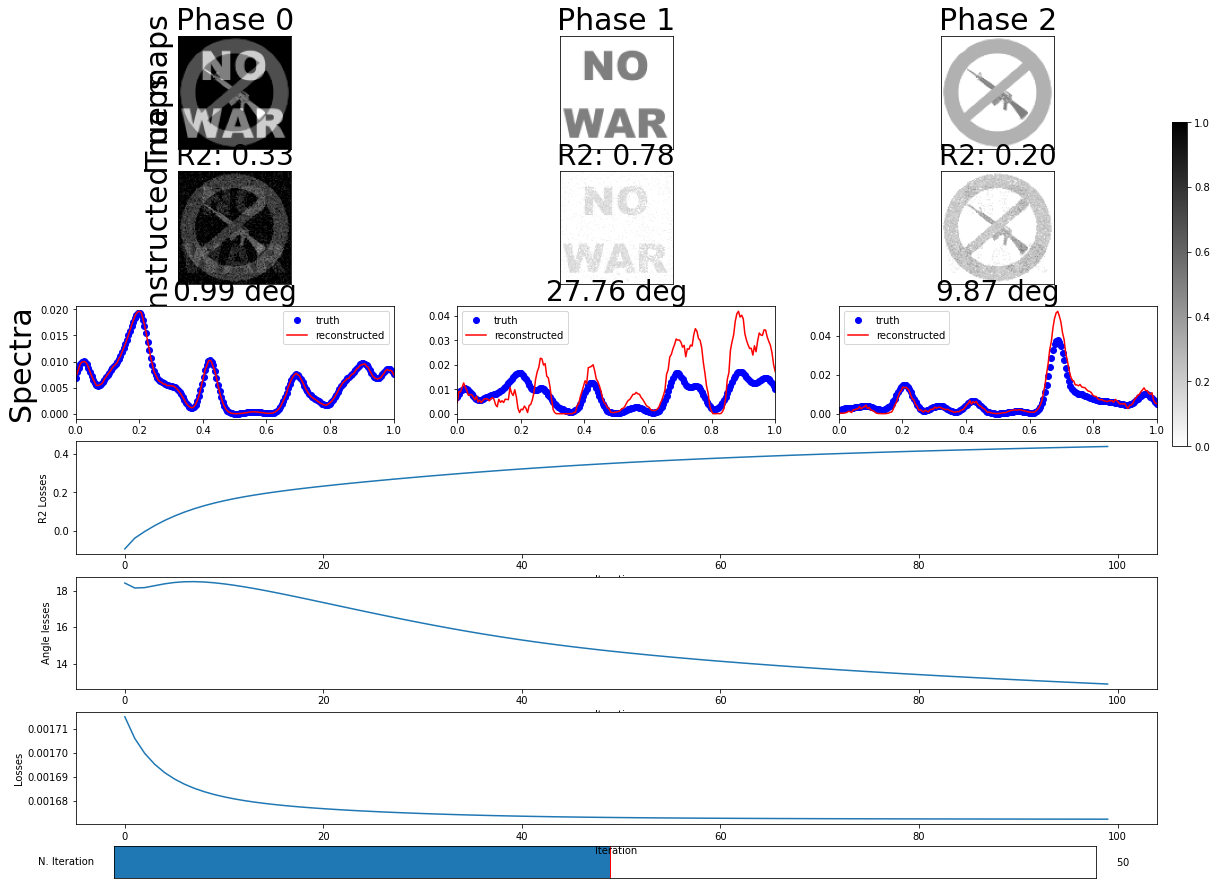

angles :  [0.9900395571468733, 9.87122557861159, 27.75743291441945]
mse :  [0.04919387465556605, 0.005240547297437986, 0.03444937031213343]
mae :  [0.15155075714069502, 0.044612806415984696, 0.09801872397948741]
r2 :  [0.3308697885317089, 0.784048869379056, 0.20485564135177148]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  13.998 it/s
It 20 / 100: loss 0.002,  14.532 it/s
exits because of relative change < tol: 0.00010369213752354184
exits because of relative change < tol: 9.75436927766757e-05
It 30 / 100: loss 0.002,  13.993 it/s
exits because of relative change < tol: 9.171833330652892e-05
exits because of relative change < tol: 8.617952534540508e-05
exits because of relative change < tol: 8.090592874278015e-05
exits because of relative change < tol: 7.588705978344949e-05
exits because of relative change < tol: 7.11190691496101e-05
exits because of relative change < tol: 6.660104042843275e-05
exits because of relative change < tol: 6.233209216413567e-05
exits because of relative change < tol: 5.83094252319208e-05
exits because of relative change < tol: 5.4527324694825966e-05
exits because of relative change < tol: 5.097700829168419e-05
It 40 / 100: loss 0.002,  14.848 it/s
exits because of relative change < tol: 4.764712785043633e-05
exits because of relative change < tol: 4.4

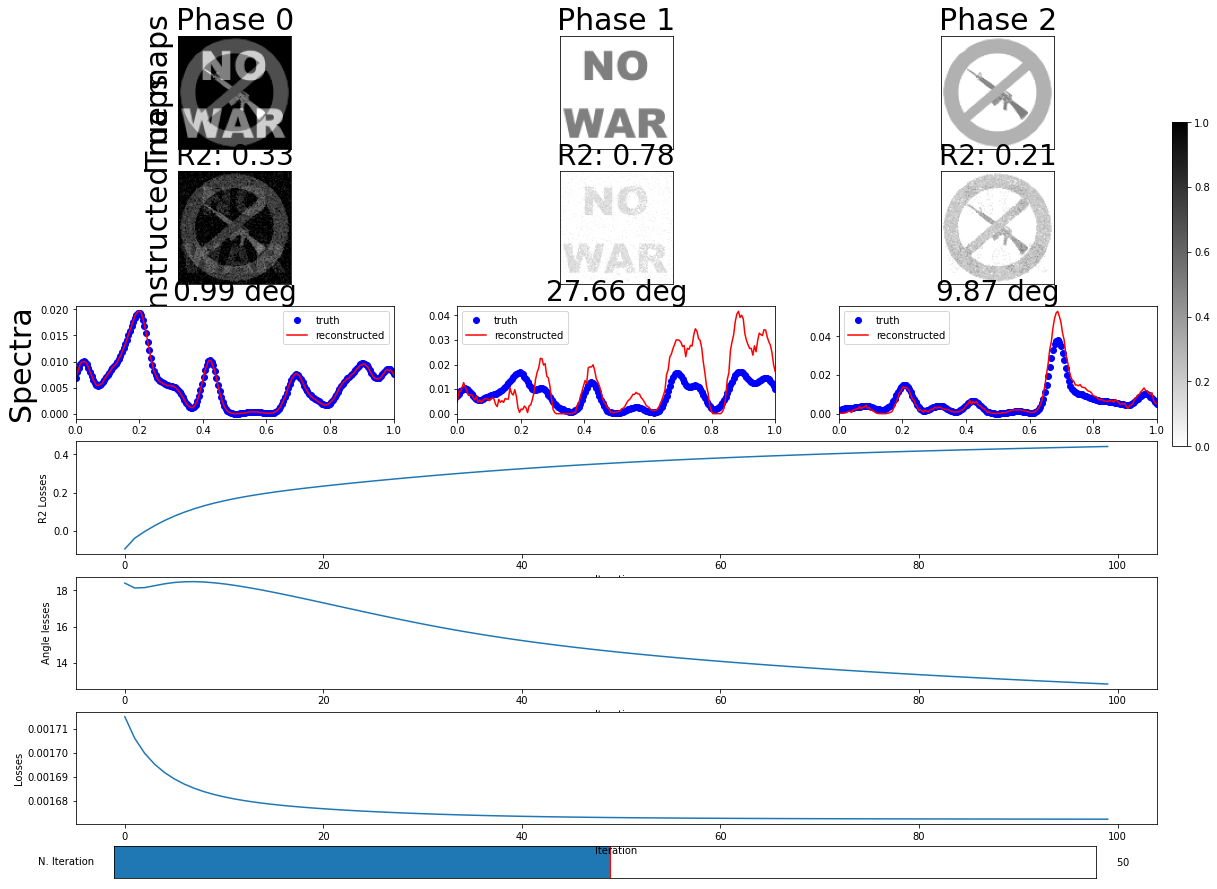

angles :  [0.9900950489456616, 9.86562233702152, 27.664358637853656]
mse :  [0.049068539139676785, 0.0052413144478527475, 0.034326506767399505]
mae :  [0.15140723086028407, 0.044627568183253565, 0.09785585730354598]
r2 :  [0.3325745898070438, 0.7840172568412769, 0.20769152060278617]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  14.022 it/s
It 20 / 100: loss 0.002,  14.464 it/s
exits because of relative change < tol: 0.00010271177649309622
exits because of relative change < tol: 9.654857936049258e-05
It 30 / 100: loss 0.002,  14.639 it/s
exits because of relative change < tol: 9.073358056198174e-05
exits because of relative change < tol: 8.522882375403512e-05
exits because of relative change < tol: 8.001034295542444e-05
exits because of relative change < tol: 7.506397323509509e-05
exits because of relative change < tol: 7.03813937305011e-05
exits because of relative change < tol: 6.595678143263155e-05
exits because of relative change < tol: 6.178431177447167e-05
exits because of relative change < tol: 5.7856591235202645e-05
exits because of relative change < tol: 5.4163981055401924e-05
exits because of relative change < tol: 5.069466546444768e-05
It 40 / 100: loss 0.002,  14.606 it/s
exits because of relative change < tol: 4.7435255365611255e-05
exits because of relative change < tol:

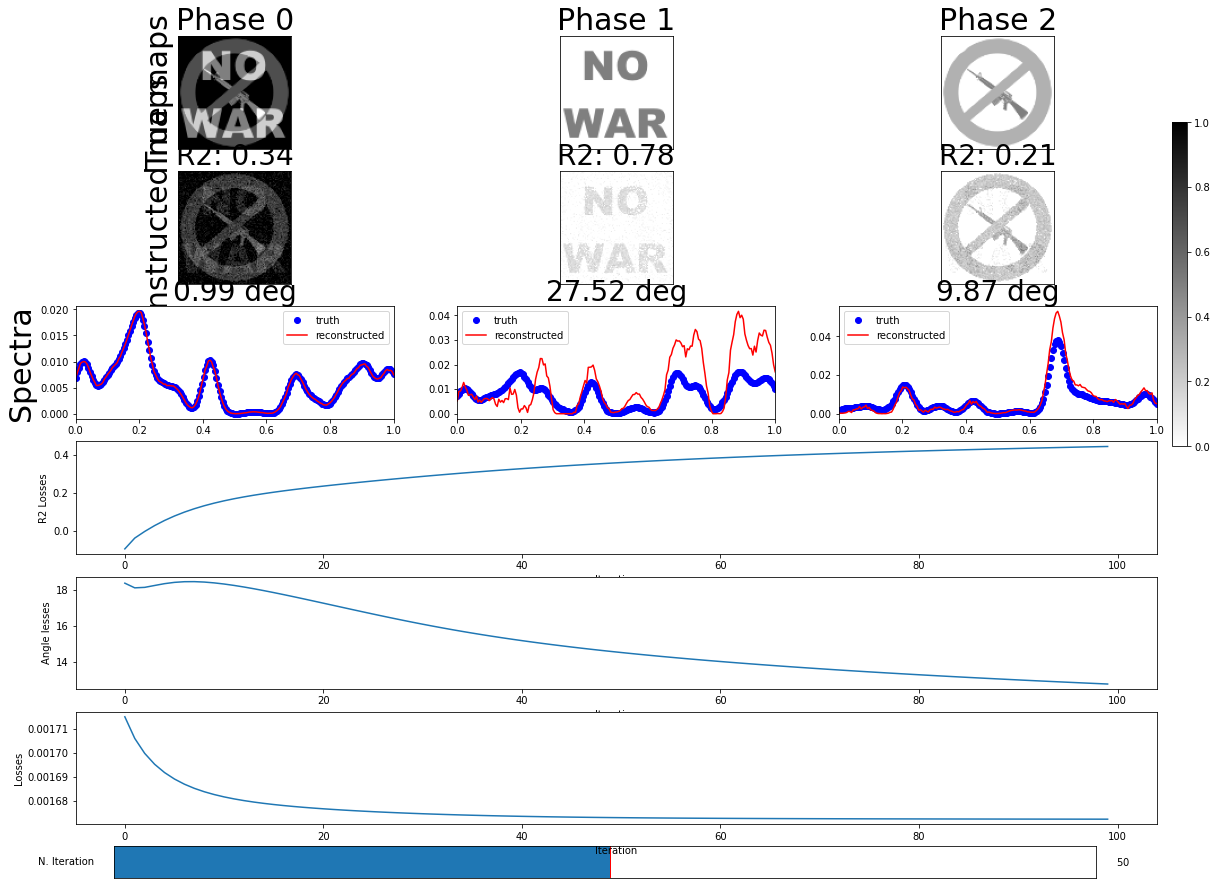

angles :  [0.9897413789518597, 9.865701147529062, 27.521193645868763]
mse :  [0.04885403275287429, 0.005235505183077878, 0.034174342406936196]
mae :  [0.15113063492256257, 0.04460681488516794, 0.09765658557080287]
r2 :  [0.33549228443808077, 0.7842566435360259, 0.21120370766784569]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  13.803 it/s
It 20 / 100: loss 0.002,  14.321 it/s
exits because of relative change < tol: 0.0001026065078598902
exits because of relative change < tol: 9.676984709359792e-05
It 30 / 100: loss 0.002,  14.533 it/s
exits because of relative change < tol: 9.127104665558685e-05
exits because of relative change < tol: 8.60533948172684e-05
exits because of relative change < tol: 8.107694193782031e-05
exits because of relative change < tol: 7.631599784846742e-05
exits because of relative change < tol: 7.175622984462237e-05
exits because of relative change < tol: 6.739156235702972e-05
exits because of relative change < tol: 6.32211122691076e-05
exits because of relative change < tol: 5.9246417127253835e-05
exits because of relative change < tol: 5.5469193559577505e-05
exits because of relative change < tol: 5.188979318904744e-05
It 40 / 100: loss 0.002,  14.561 it/s
exits because of relative change < tol: 4.850640870191254e-05
exits because of relative change < tol: 4.

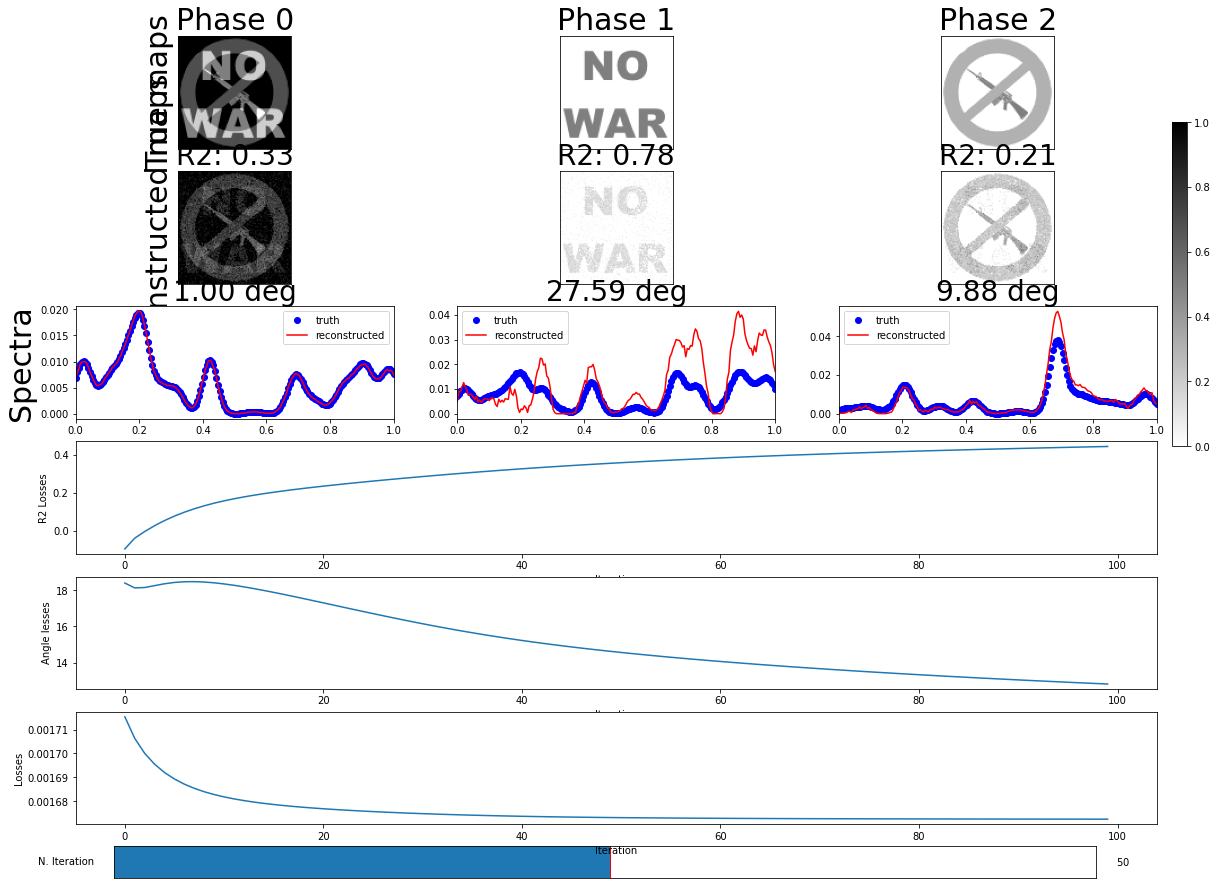

angles :  [0.9961276925366594, 9.877868251257368, 27.58734543858159]
mse :  [0.04901532996276022, 0.00524602570741532, 0.034271882474947106]
mae :  [0.1513838628180636, 0.044644498718560105, 0.09780019423838135]
r2 :  [0.33329833576223666, 0.7838231164640526, 0.2089523331400006]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  13.666 it/s
It 20 / 100: loss 0.002,  14.336 it/s
exits because of relative change < tol: 0.00010458980774482815
exits because of relative change < tol: 9.839647104494915e-05
exits because of relative change < tol: 9.273980778773954e-05
It 30 / 100: loss 0.002,  14.481 it/s
exits because of relative change < tol: 8.755964292410311e-05
exits because of relative change < tol: 8.280769428927979e-05
exits because of relative change < tol: 7.844367842377282e-05
exits because of relative change < tol: 7.443155004362728e-05
exits because of relative change < tol: 7.073625660014323e-05
exits because of relative change < tol: 6.73213137343979e-05
exits because of relative change < tol: 6.41474306837974e-05
exits because of relative change < tol: 6.117232939702469e-05
exits because of relative change < tol: 5.8351789961623877e-05
exits because of relative change < tol: 5.564180540009321e-05
It 40 / 100: loss 0.002,  14.568 it/s
exits because of relative change < tol: 5.

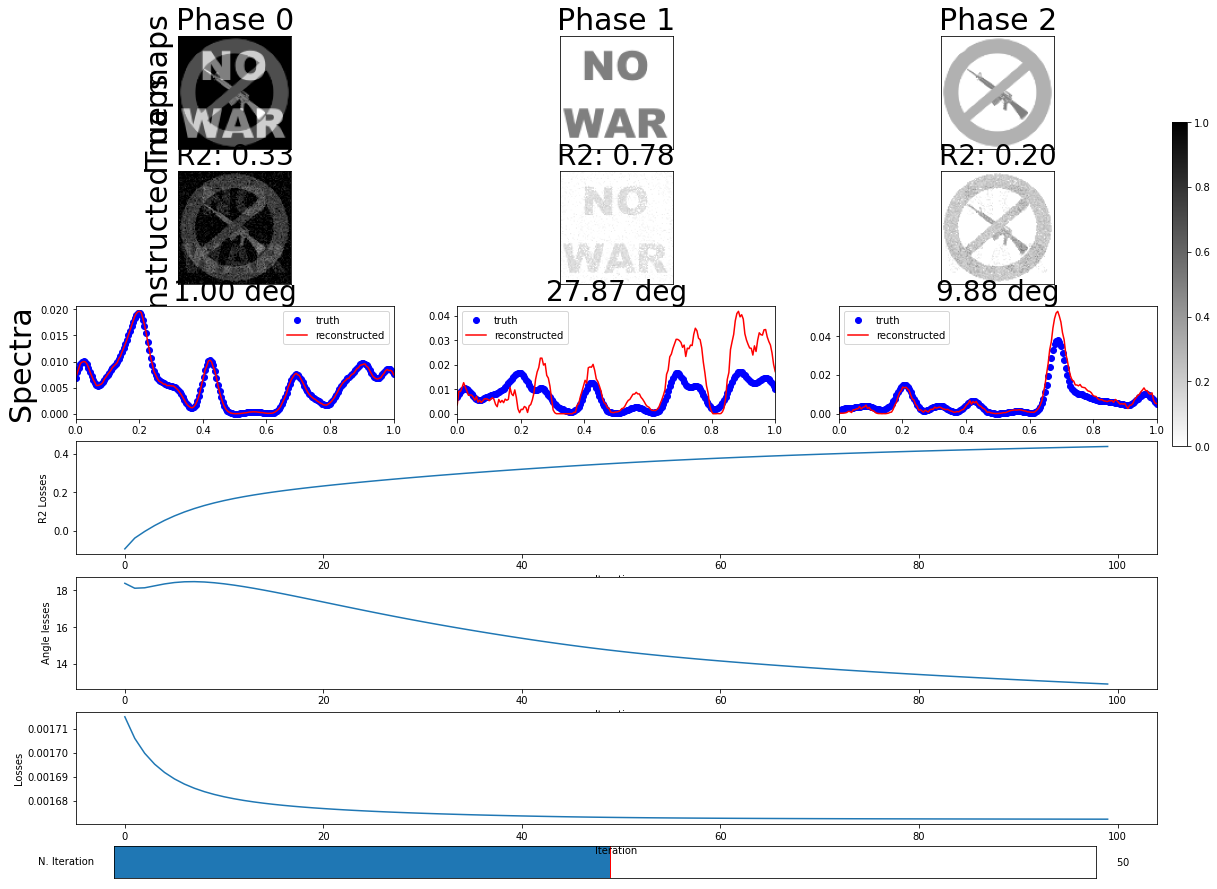

angles :  [0.9957668205525664, 9.877055540183774, 27.866252878322356]
mse :  [0.04929621231058898, 0.005241876087830201, 0.03454849841605303]
mae :  [0.1516997202867935, 0.044624763008034446, 0.09817868782068791]
r2 :  [0.3294778018824338, 0.7839941129249549, 0.20256761251696276]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  13.915 it/s
It 20 / 100: loss 0.002,  13.129 it/s
exits because of relative change < tol: 0.00010296790745856174
exits because of relative change < tol: 9.70941538713928e-05
It 30 / 100: loss 0.002,  13.507 it/s
exits because of relative change < tol: 9.154766838256277e-05
exits because of relative change < tol: 8.627555228091667e-05
exits because of relative change < tol: 8.124188613915415e-05
exits because of relative change < tol: 7.642480708372698e-05
exits because of relative change < tol: 7.181325698759016e-05
exits because of relative change < tol: 6.740364390050298e-05
exits because of relative change < tol: 6.319666998673209e-05
exits because of relative change < tol: 5.919457683207494e-05
exits because of relative change < tol: 5.539902047090387e-05
exits because of relative change < tol: 5.180970432216554e-05
It 40 / 100: loss 0.002,  13.716 it/s
exits because of relative change < tol: 4.842378434540117e-05
exits because of relative change < tol: 4.

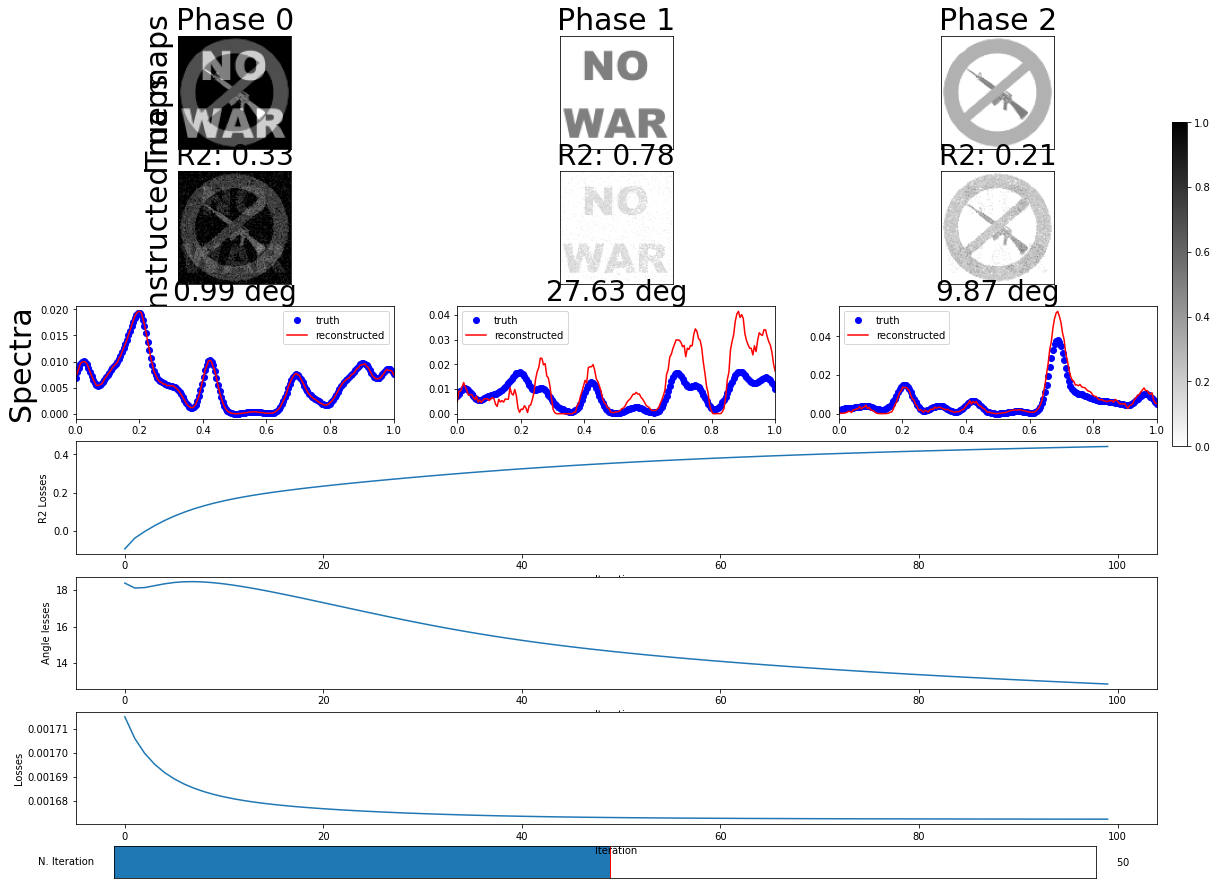

angles :  [0.9945428646883143, 9.870887144772675, 27.631539614156498]
mse :  [0.04902644936554158, 0.005243284711443902, 0.034306015766015094]
mae :  [0.1513628581024555, 0.04464133039801021, 0.09783542528475994]
r2 :  [0.33314709074674265, 0.7839360667239127, 0.20816448437559953]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  13.155 it/s
It 20 / 100: loss 0.002,  13.910 it/s
exits because of relative change < tol: 0.00010217461532903398
exits because of relative change < tol: 9.580175122640636e-05
exits because of relative change < tol: 8.996650807846974e-05
It 30 / 100: loss 0.002,  14.174 it/s
exits because of relative change < tol: 8.461389443348324e-05
exits because of relative change < tol: 7.970219683776092e-05
exits because of relative change < tol: 7.519943967835218e-05
exits because of relative change < tol: 7.10798238121512e-05
exits because of relative change < tol: 6.732042575277944e-05
exits because of relative change < tol: 6.389834556912635e-05
exits because of relative change < tol: 6.078841971924383e-05
exits because of relative change < tol: 5.796157813990967e-05
exits because of relative change < tol: 5.5383921008381026e-05
exits because of relative change < tol: 5.301659111138811e-05
It 40 / 100: loss 0.002,  14.467 it/s
exits because of relative change < tol: 5

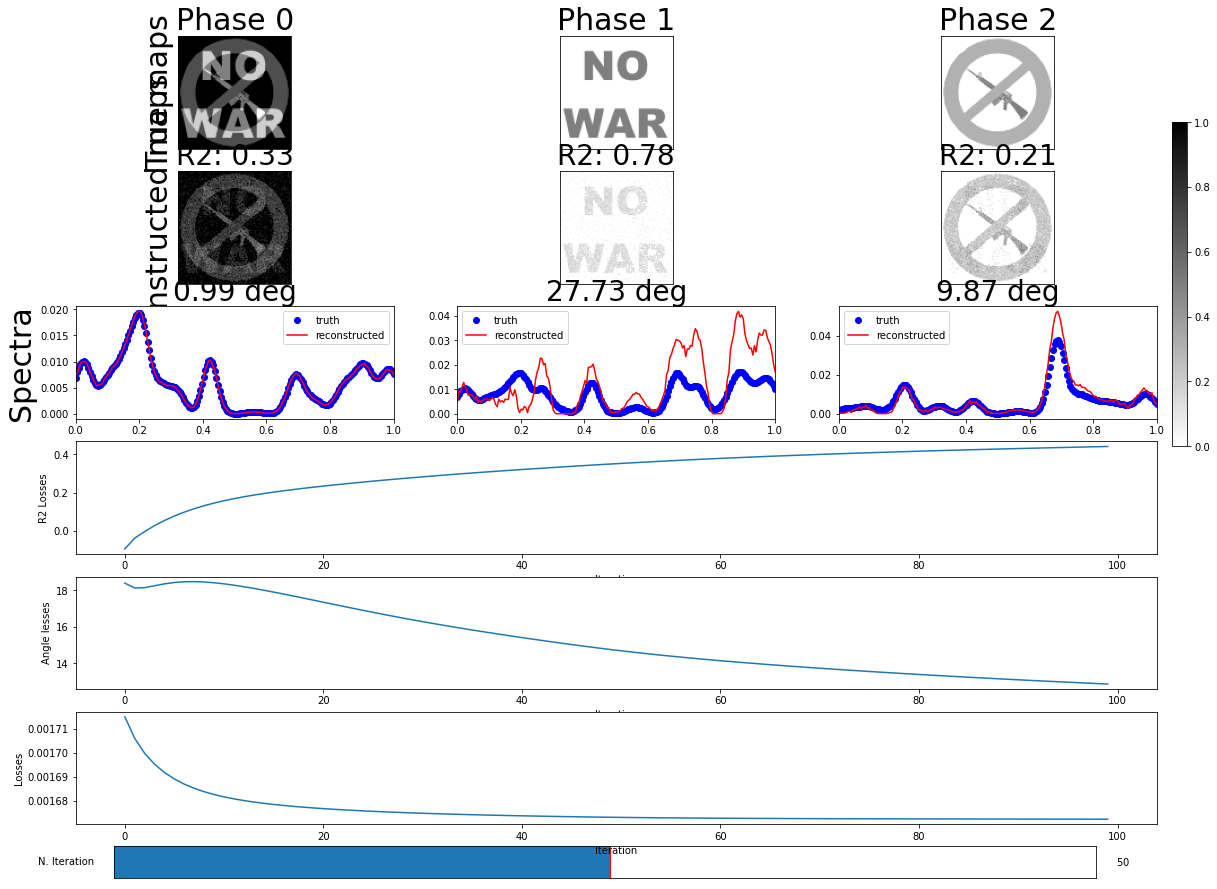

angles :  [0.9916612613661682, 9.865557725564006, 27.72700250602423]
mse :  [0.04911753508329371, 0.005225553031178815, 0.03441571957271307]
mae :  [0.15156407631334706, 0.044551107176771826, 0.09795220986656725]
r2 :  [0.33190815183396216, 0.784666749262152, 0.20563235208325958]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  13.829 it/s
It 20 / 100: loss 0.002,  14.422 it/s
exits because of relative change < tol: 0.00010176156649620395
exits because of relative change < tol: 9.53636406714432e-05
exits because of relative change < tol: 8.949526928165806e-05
It 30 / 100: loss 0.002,  14.524 it/s
exits because of relative change < tol: 8.409773722472184e-05
exits because of relative change < tol: 7.912662381754154e-05
exits because of relative change < tol: 7.454882506514933e-05
exits because of relative change < tol: 7.033952770850902e-05
exits because of relative change < tol: 6.647931669166138e-05
exits because of relative change < tol: 6.29515148463584e-05
exits because of relative change < tol: 5.9739810328165684e-05
exits because of relative change < tol: 5.682622088685123e-05
exits because of relative change < tol: 5.41894583539188e-05
exits because of relative change < tol: 5.180376504765328e-05
It 40 / 100: loss 0.002,  14.523 it/s
exits because of relative change < tol: 4.9

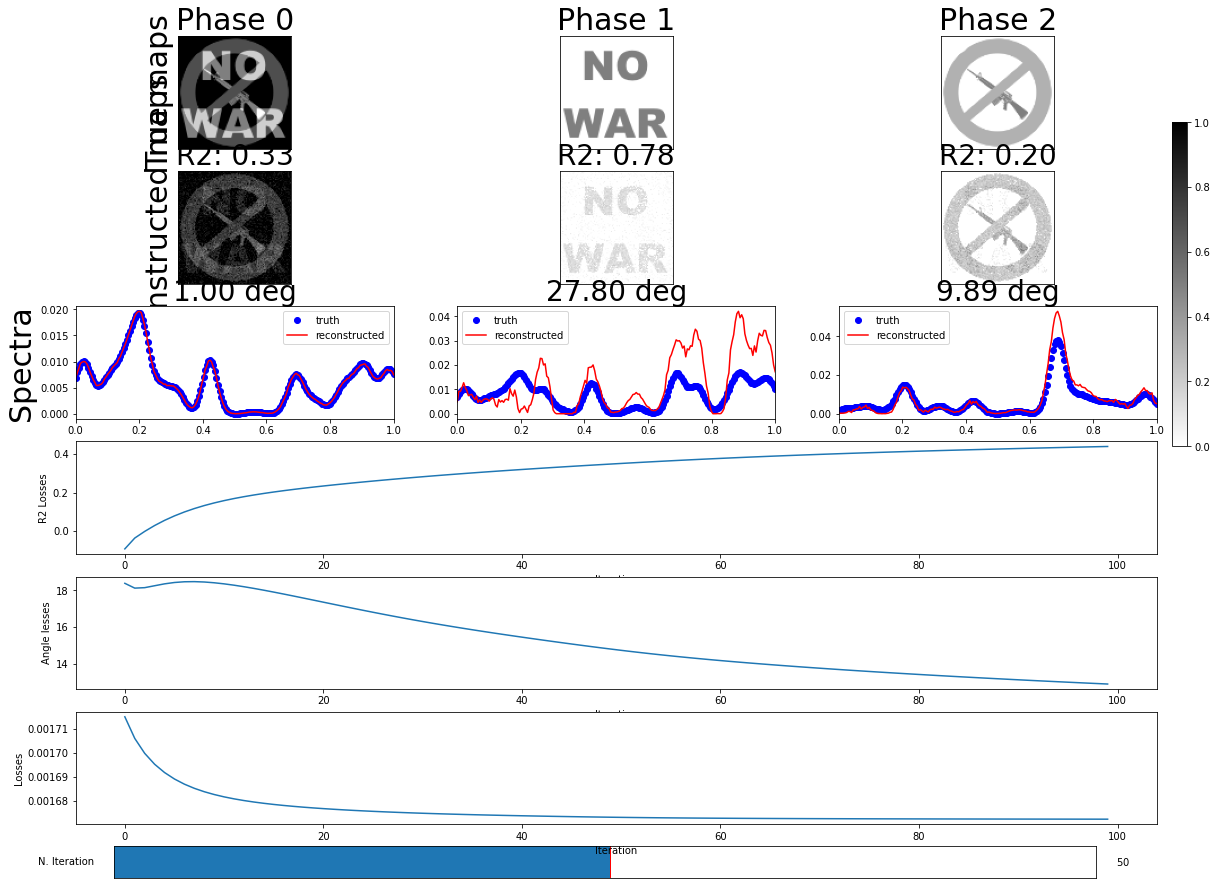

angles :  [0.9987081974708802, 9.88545889235413, 27.799541173472058]
mse :  [0.04917929750007804, 0.0052354584291423945, 0.03451376603265796]
mae :  [0.1515693883550019, 0.04461134510974555, 0.09810338164675532]
r2 :  [0.33106806555710266, 0.7842585701602228, 0.2033692892520893]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  13.809 it/s
It 20 / 100: loss 0.002,  14.345 it/s
exits because of relative change < tol: 0.00010338307643810827
exits because of relative change < tol: 9.723999170291878e-05
It 30 / 100: loss 0.002,  14.508 it/s
exits because of relative change < tol: 9.142232822254878e-05
exits because of relative change < tol: 8.589191624185372e-05
exits because of relative change < tol: 8.062636294167638e-05
exits because of relative change < tol: 7.561464348293435e-05
exits because of relative change < tol: 7.085278486638699e-05
exits because of relative change < tol: 6.63400607877507e-05
exits because of relative change < tol: 6.20759882997188e-05
exits because of relative change < tol: 5.805827683052614e-05
exits because of relative change < tol: 5.4281742041026644e-05
exits because of relative change < tol: 5.073808155456803e-05
It 40 / 100: loss 0.002,  14.544 it/s
exits because of relative change < tol: 4.741632018077817e-05
exits because of relative change < tol: 4.

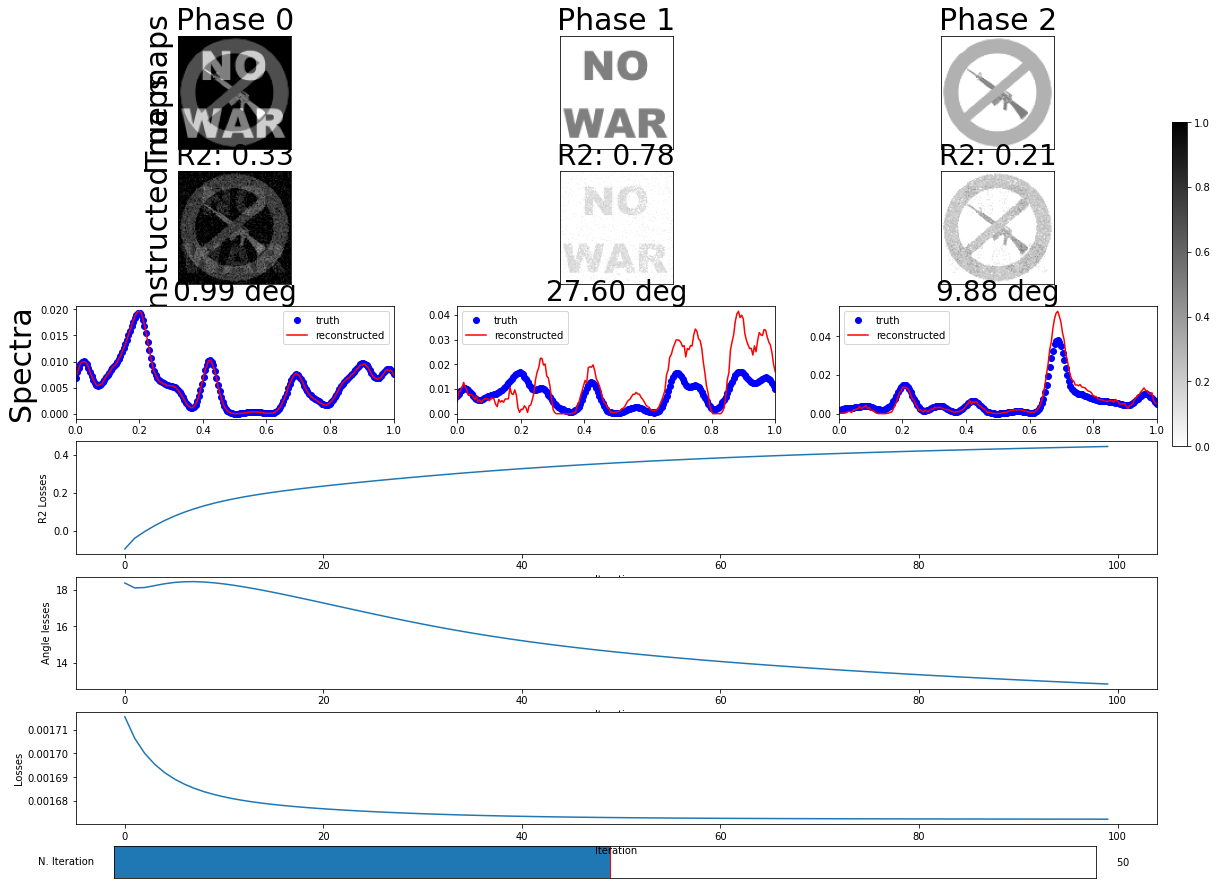

angles :  [0.9927422040099843, 9.875786287338308, 27.603841032292312]
mse :  [0.04899837215655202, 0.005244526076602326, 0.034266009410743925]
mae :  [0.15134138346924222, 0.04464333696710294, 0.09779083710445595]
r2 :  [0.3335289941629742, 0.7838849128664509, 0.2090878924790197]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  13.447 it/s
It 20 / 100: loss 0.002,  14.188 it/s
exits because of relative change < tol: 0.0001034437163797722
exits because of relative change < tol: 9.719800351384197e-05
It 30 / 100: loss 0.002,  14.336 it/s
exits because of relative change < tol: 9.128475401752873e-05
exits because of relative change < tol: 8.56699428396263e-05
exits because of relative change < tol: 8.033428885435845e-05
exits because of relative change < tol: 7.526850985048842e-05
exits because of relative change < tol: 7.046886516794194e-05
exits because of relative change < tol: 6.593345265004083e-05
exits because of relative change < tol: 6.165952678331136e-05
exits because of relative change < tol: 5.764190554573431e-05
exits because of relative change < tol: 5.387237581128111e-05
exits because of relative change < tol: 5.03398954079757e-05
It 40 / 100: loss 0.002,  14.475 it/s
exits because of relative change < tol: 4.703133594264182e-05
exits because of relative change < tol: 4.39

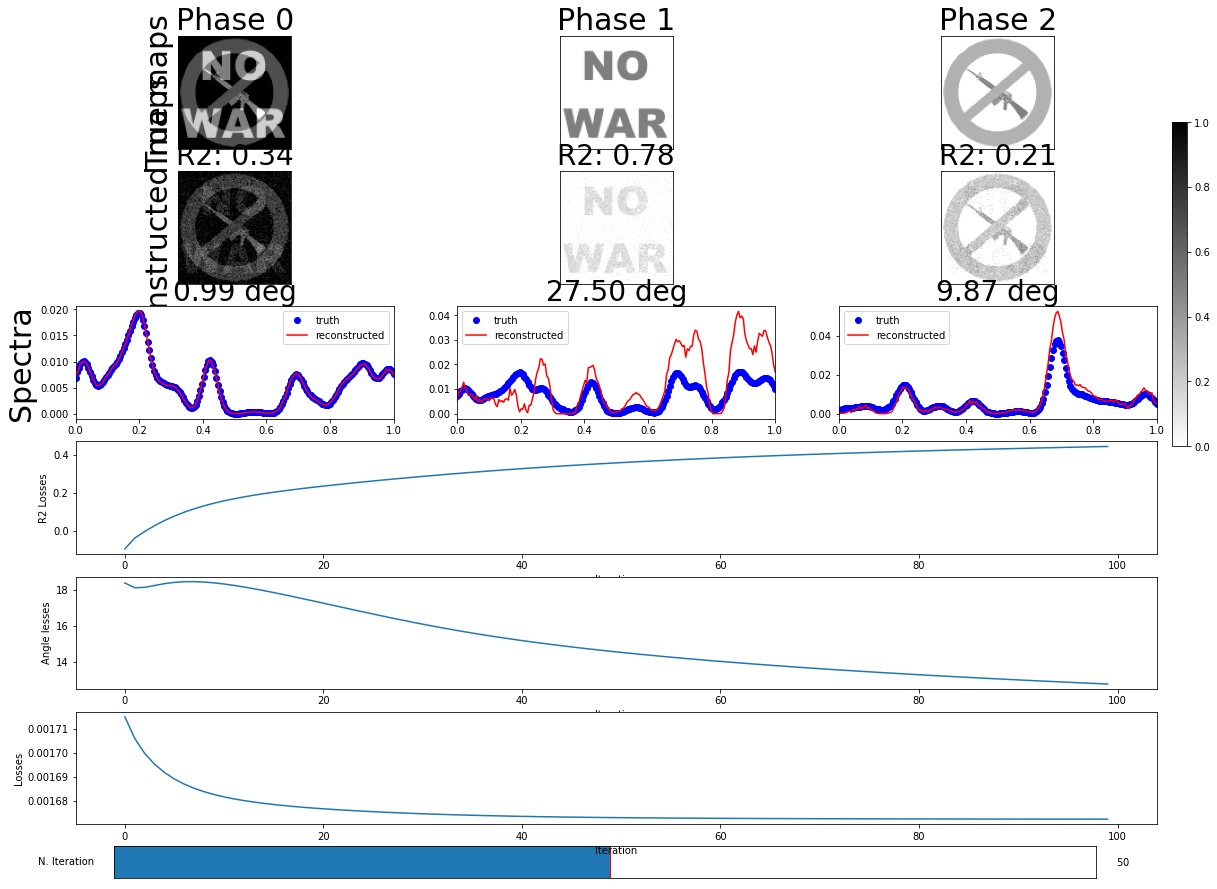

angles :  [0.9860142133130517, 9.865433945377251, 27.496395965558335]
mse :  [0.048841014433429975, 0.005239422748481484, 0.034119995089818854]
mae :  [0.15105494564936667, 0.04460134364074992, 0.0976064348940806]
r2 :  [0.33566935832997746, 0.7840952095043926, 0.21245812718907275]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  10.671 it/s
It 20 / 100: loss 0.002,  12.513 it/s
exits because of relative change < tol: 0.00010860418553026089
exits because of relative change < tol: 0.00010237349975108253
exits because of relative change < tol: 9.655143101537688e-05
It 30 / 100: loss 0.002,  13.035 it/s
exits because of relative change < tol: 9.106405885341144e-05
exits because of relative change < tol: 8.585596860441979e-05
exits because of relative change < tol: 8.088820865607556e-05
exits because of relative change < tol: 7.613569787712234e-05
exits because of relative change < tol: 7.158427513624775e-05
exits because of relative change < tol: 6.722762086081224e-05
exits because of relative change < tol: 6.3064298682136e-05
exits because of relative change < tol: 5.9095166178332104e-05
exits because of relative change < tol: 5.5321354238493845e-05
exits because of relative change < tol: 5.1742927566531024e-05
It 40 / 100: loss 0.002,  13.302 it/s
exits because of relative change < tol:

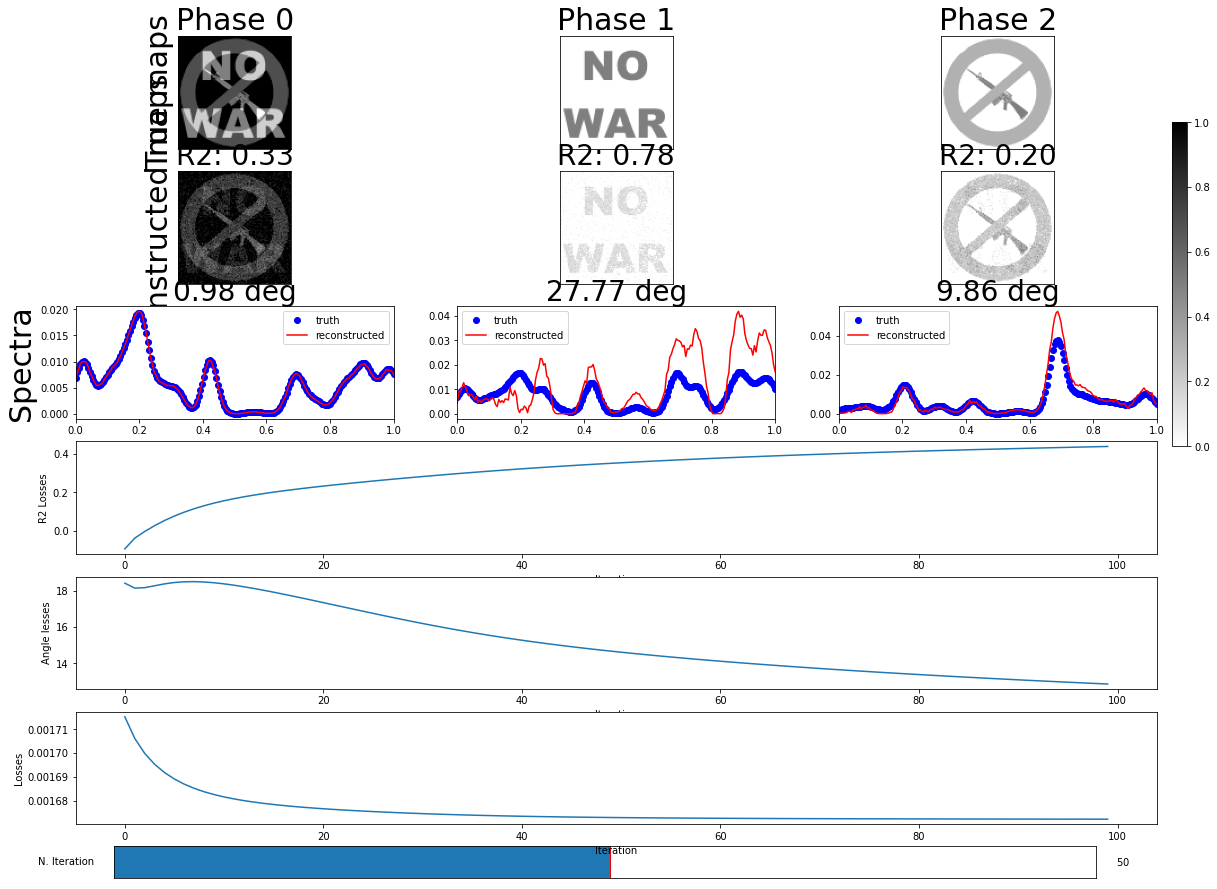

angles :  [0.9817131151285795, 9.859967922730208, 27.77420105152933]
mse :  [0.04922973671792328, 0.005232813487563584, 0.03447926260038171]
mae :  [0.1515599441938189, 0.04457740089851363, 0.09798408160625172]
r2 :  [0.33038199631089293, 0.7843675622352776, 0.20416568144387326]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  11.580 it/s
It 20 / 100: loss 0.002,  12.942 it/s
exits because of relative change < tol: 0.00010211592664143762
exits because of relative change < tol: 9.580430311696258e-05
exits because of relative change < tol: 9.002124062482804e-05
It 30 / 100: loss 0.002,  13.527 it/s
exits because of relative change < tol: 8.471010860027539e-05
exits because of relative change < tol: 7.982822069434448e-05
exits because of relative change < tol: 7.53433791553308e-05
exits because of relative change < tol: 7.123033925215558e-05
exits because of relative change < tol: 6.746748586688965e-05
exits because of relative change < tol: 6.403392119150403e-05
exits because of relative change < tol: 6.090708344282229e-05
exits because of relative change < tol: 5.8060972615613235e-05
exits because of relative change < tol: 5.546504274951776e-05
exits because of relative change < tol: 5.308381980698843e-05
It 40 / 100: loss 0.002,  14.485 it/s
exits because of relative change < tol: 5

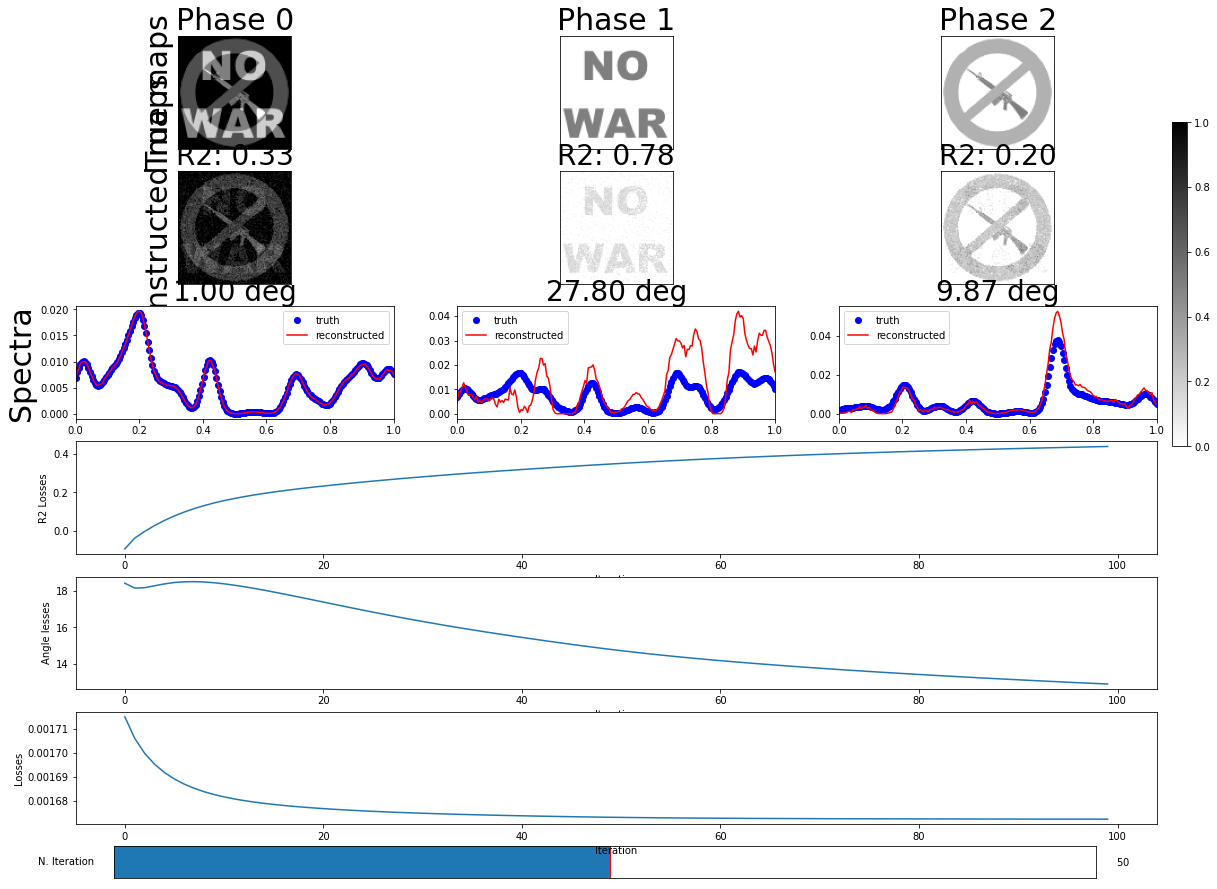

angles :  [0.9993153971033676, 9.874320307465982, 27.800802677391108]
mse :  [0.04921947211030731, 0.005245955453201793, 0.03453133999563138]
mae :  [0.1515948374658884, 0.0446639762180012, 0.09812229280144948]
r2 :  [0.3305216144871964, 0.7838260114816873, 0.202963655204477]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  11.661 it/s
It 20 / 100: loss 0.002,  12.954 it/s
exits because of relative change < tol: 0.00010250336798110398
exits because of relative change < tol: 9.655266321240384e-05
It 30 / 100: loss 0.002,  13.516 it/s
exits because of relative change < tol: 9.0942199973976e-05
exits because of relative change < tol: 8.56222090455869e-05
exits because of relative change < tol: 8.055920863756224e-05
exits because of relative change < tol: 7.573278943838032e-05
exits because of relative change < tol: 7.113211667788981e-05
exits because of relative change < tol: 6.675247353295169e-05
exits because of relative change < tol: 6.259215323936376e-05
exits because of relative change < tol: 5.864995852301177e-05
exits because of relative change < tol: 5.4923475640147036e-05
exits because of relative change < tol: 5.14081724208071e-05
It 40 / 100: loss 0.002,  13.690 it/s
exits because of relative change < tol: 4.8097244078603476e-05
exits because of relative change < tol: 4.4

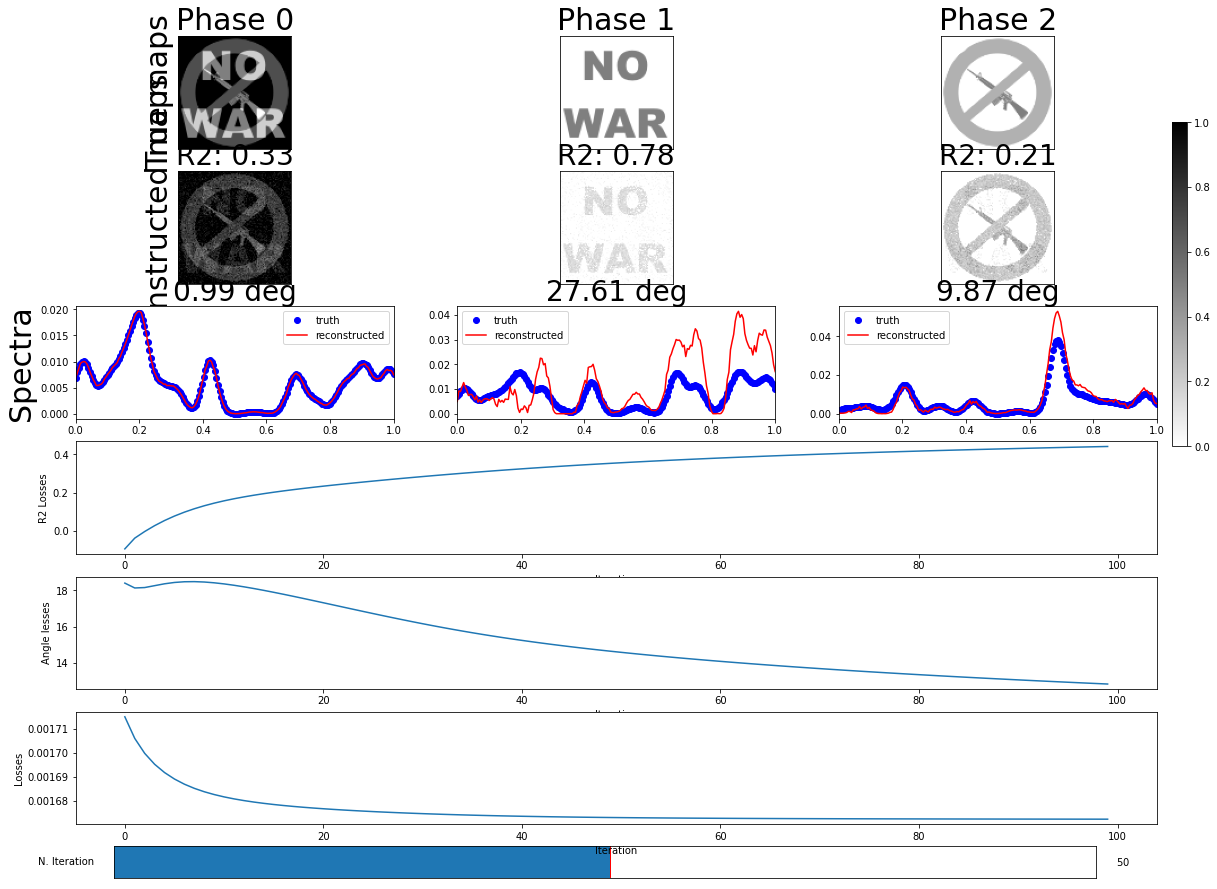

angles :  [0.992280360711423, 9.86917693976888, 27.613189142633043]
mse :  [0.049037051028699645, 0.005241060243101913, 0.034308487256823506]
mae :  [0.15138817453249814, 0.044630135420833696, 0.09781625034120126]
r2 :  [0.33300288797433364, 0.7840277320455324, 0.20810743857313763]
3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 100: loss 0.002,  13.958 it/s
It 20 / 100: loss 0.002,  14.492 it/s
exits because of relative change < tol: 0.00010738204830817634
exits because of relative change < tol: 0.00010132250864577208
exits because of relative change < tol: 9.572628709013522e-05
It 30 / 100: loss 0.002,  14.679 it/s
exits because of relative change < tol: 9.051383093240759e-05
exits because of relative change < tol: 8.561905269662711e-05
exits because of relative change < tol: 8.098801540419339e-05
exits because of relative change < tol: 7.657791113104643e-05
exits because of relative change < tol: 7.235626199791881e-05
exits because of relative change < tol: 6.83001419098001e-05
exits because of relative change < tol: 6.439519056242544e-05
exits because of relative change < tol: 6.063427087757824e-05
exits because of relative change < tol: 5.7015768256032354e-05
exits because of relative change < tol: 5.354167851465663e-05
It 40 / 100: loss 0.002,  14.670 it/s
exits because of relative change < tol: 

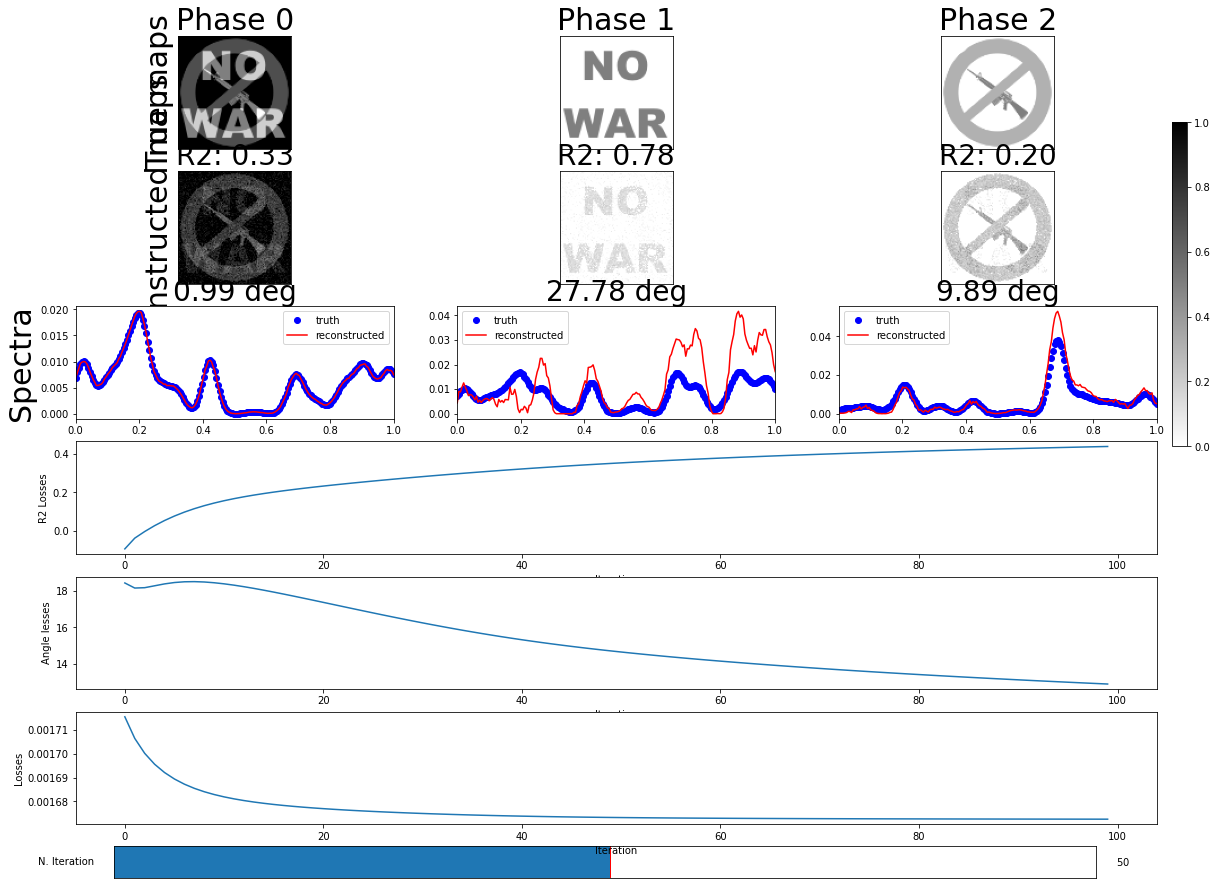

angles :  [0.9858446581724438, 9.891543437848338, 27.783965822259624]
mse :  [0.049326284734637335, 0.005258001756925944, 0.03449839863845807]
mae :  [0.15166787957499278, 0.04471310197928528, 0.09807250508393461]
r2 :  [0.32906875974855576, 0.7833296104835883, 0.20372399230455296]


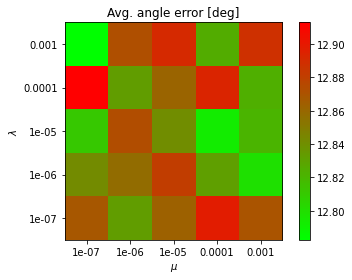

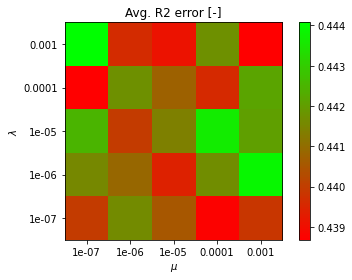

In [136]:

import time
from scipy import ndimage
import random


mu = 0
lambda_L = 0
force_simplex = False
Gused = None

params = {}
params["tol"]=1e-4
params["max_iter"] = 100
params["hspy_comp"] = False
params["verbose"] = 1
params["epsilon_reg"] = 1
params["linesearch"] = False
# params["shape_2d"] = shape_2d
params["n_components"] = K

n = 5
m = 5

downsampling_factors = [1]
angles = []
r2s = []

angle_max_exp = []
r2_max_exp = []
times_exp = []

pixels_side = 100
Ximg = Y.reshape((-1, pixels_side,pixels_side))

lambdas = [10**((i//n)-7) for i in range(n*m)]
mus = [10**((i%n)-7) for i in range(n*m)]
for j in range(n*m):
    angle_max_exp.append([])
    r2_max_exp.append([])
    times_exp.append([])

    Hflat =None
    W = None

    for i in range(len(downsampling_factors)):
        start_time = time.time()
        n = downsampling_factors[i]
        X = downsample(Ximg,n)
        Xflat = X.reshape((X.shape[0], -1))
        if (i > 0):
            factor = downsampling_factors[i-1]//downsampling_factors[i]
            H = Hflat.reshape((-1, pixels_side//n//factor, pixels_side//n//factor))
            H = H.repeat(factor, axis = 1).repeat(factor, axis = 2)
            Hflat = H.reshape((-1, pixels_side*pixels_side//n//n)) +0.001
            W =  W 

        
        est = SmoothNMF( n_components = 3,tol=0.0001, max_iter = 100, G = None, lambda_L=lambdas[j], mu=mus[j], force_simplex=False)

        if i > 0:
            D , Hs, Ws, G, losses = est.fit_transform(Xflat, W=W, H=Hflat, update_W=False)

        else:
            D , Hs, Ws, G, losses = est.fit_transform(Xflat, W=W, H=Hflat, update_W=True)


        Hflat = est.H_
        W = est.W_

        # Wdot = spim.phases
        Hdotflat_down = downsample_flat(Hdotflat, n, pixels_side)
        times_exp[-1].append(time.time()-start_time)

        angle, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
        r2 = ordered_r2(Hdotflat_down, Hflat, true_inds)

        angle_max_exp[-1].append(sum(angle)/len(angle))
        r2_max_exp[-1].append(sum(r2)/len(r2))

        plot_results(Ddot, D, Hdotflat_down, Hflat, pixels_side//n, Hs, Ws, G, losses)

    angles.append(sum(angle)/len(angle))
    r2s.append(sum(r2)/len(r2))
    

1
n = 5
m = 5
labels = ["$\mu$ ="+str(mus[i])+"$\lambda$ ="+str(lambdas[i]) for i in range(n*m)]

from matplotlib.colors import LinearSegmentedColormap

cmap_red_green = LinearSegmentedColormap.from_list("gradients", [(1,0,0),(0,1,0)], N=100)
cmap_green_red = LinearSegmentedColormap.from_list("gradients", [(0,1,0),(1,0,0)], N=100)



Z = [angle_max_exp[i][-1] for i in range(n*m)]
Z = np.array(Z)
Z = np.reshape(Z, (n,m))

plt.imshow(Z, cmap=cmap_green_red,origin='lower')
plt.yticks([i for i in range(n)], [str(10**((i)-7)) for i in range(n)])
plt.xticks([i for i in range(m)], [str(10**((i)-7)) for i in range(m)])
plt.ylabel("$\lambda$")
plt.xlabel("$\mu$")
cbar = plt.colorbar()
plt.title("Avg. angle error [deg]")
plt.draw()
plt.show()



Z = [r2_max_exp[i][-1] for i in range(n*m)]
Z = np.array(Z)
Z = np.reshape(Z, (n,m))
plt.imshow(Z, cmap=cmap_red_green,origin='lower')
plt.yticks([i for i in range(n)], [str(10**((i%n)-7)) for i in range(n)])
plt.xticks([i for i in range(m)], [str(10**((i%n)-7)) for i in range(m)])
plt.ylabel("$\lambda$")
plt.xlabel("$\mu$")
cbar = plt.colorbar()
plt.title("Avg. R2 error [-]")
plt.draw()
plt.show()




In [67]:
    D_it = G @ Ws[0]
    
    angles, true_inds = find_min_angle(Ddot.T, D_it.T, unique=True, get_ind=True)
 
    print(angles)

[5.0760319880113105, 23.99521143083888, 42.275349068771725]


In [17]:
plt.plot(j_hist, r2_hist)
plt.scatter(j_hist, r2_hist)
np_losses= np.array(losses_hist)
print(np_losses[np.array(j_hist)])
plt.plot(j_hist, np_losses[np.array(j_hist)])
plt.show()
plt.xlabel("Loss [-]")
plt.ylabel("Avg Angle error [deg]")
print(r2_hist)

# plt.plot(r2s_hist, losses_hist)
plt.scatter(losses_hist, r2s_hist)
plt.show()

fig, ax1 = plt.subplots()

color="tab:blue"
ax1.set_xlabel('Iteration [-]')
ax1.set_ylabel('R2 [-]', color=color)
ax1.plot(j_hist, r2_hist)
ax1.scatter(j_hist, r2_hist)
# ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('Loss [-]', color=color)  # we already handled the x-label with ax1
ax2.plot(j_hist, np_losses[np.array(j_hist)], color=color)
ax2.scatter(j_hist, np_losses[np.array(j_hist)], color=color)

# ax2.tick_params(axis='Loss [-]')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



NameError: name 'j_hist' is not defined

In [82]:
        
angles, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
mse = ordered_mse(Hdotflat, Hflat, true_inds)
print("angles : ", angles)
print("mse : ", mse)

angles :  [0.8838393524415845, 14.13358000674566, 45.06877279790232]
mse :  [0.030661881683458934, 0.0050570222862587715, 0.024413143232378726]


In [ ]:
plot_results(Ddot, D, Hdotflat, Hflat)

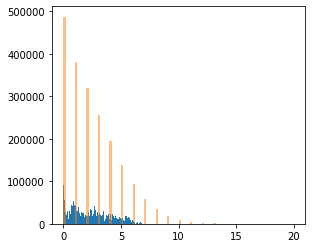

In [14]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.hist(Ydot.flatten()*n_poisson, 100);
plt.subplot(1,2,1)
plt.hist(Y.flatten()*n_poisson, 100, alpha=0.5);